# Py: Using Twitter to predict share price movements

**This notebook was originally created by Justin Sik-Kwok-Wong as an assignment response for the Data Analytics Applications subject in Semester 2, 2021. Although it is a student assignment response, the editors consider it to be high quality and a good demonstration of how to clean, transform and analyse real world natural language and financial data.**

**Data Analytics Applications is a Fellowship Applications (Module 3) subject with the Actuaries Institute that aims to teach students how to apply a range of data analytics skills, such as neural networks, natural language processing, unsupervised learning and optimisation techniques, together with their professional judgement, to solve a variety of complex and challenging business problems. The business problems used as examples in this subject are drawn from a wide range of industries.**

**Find out more about the course [here](https://www.actuaries.asn.au/education-program/fellowship/subjects-and-syllabus/data-analytics-applications-subject).**



**Structure of this notebook:**

In this notebook, the analysis is carried out in the following order:



1.   **Miscellaneous data checks on the Twitter, NEC stock and SVW stock data.** The purpose of this is to ensure that every field in the data provided agrees with the data specificatcions from the provided Data Dictionary. If any fields do not agree, we either transform the data to be of the right data type, or attempt to explain why it does not agree with the dictionary. 
2.   **Question 4(a) - Calculation of the response variable.** The response variables we calculate are: the change in stock price 10 minutes after a tweet; the change in stock price 1 hour after a tweet; and the change in stock price 1 day after a tweet. This is equivalent to holding the stock for 10 minutes, 1 hour or 1 day respectively, then selling it. We later investigate each response variable to identify the best holding period for the stock. **The reason for performing this step before Question 3** is because calculating a response variable is a data preparation step, so it is easier to perform this before modelling steps such as PCA and K-Means clustering (which require a split into training/testing/holdout steps). 
3.   **Question 3(a)ii. - Cleaning data.** In this section, we clean the tweet contents; this includes steps like removing non-ASCII characters and new-line characters, separating out re-tweets and URLs, parsing emojis into text, etc. We perform this step before Question 3(a)i. because it is easier to clean a full tweet rather than a tokenised tweet. 
4.   **Question 3(a)i. Extracting and tokenising data.** Here, we run the NLTK tokeniser (and remove stop-words from the English language). This splits the cleaned tweet text into individual tokens, or words. 
5.   **Question 3(a)iii. - Lemmatisation.** We run the NLTK word-net lemmatiser, which maps words to their base meaning. For example, 'stocks' would be lemmatised to its base, 'stock', to ensure they are treated in the same way. 
6.   **Question 3(a)iv. - Vectorisation.** Vectorisation is the process of converting tokens from a vocabulary into a matrix of features representing (roughly) the frequency and importance of each token. Before performing this step, we split the data into training, testing and an out-of-time holdout set. The out-of-time set is used to avoid data leakage when evaluating the model -- further explanation is found in this section. The TF-IDF vectoriser is then run on the training dataset only. 
7.   **Question 3(b) - Principal Components Analysis.** In this section, we first explain the advantages and disadvantages of PCA, then fit a PCA model on the training set only. 
8.   **Question 3(c) - K-means clustering.** Here, we fit a K-means clustering model on the training set only, and explain the number of clusters selected.
9.   **Question 3(d) - Evaluating clusters.** We employ internal validation processes (metrics) and manual validation processes (such as using a word cloud and checking if the clusters agree with our domain knowledge) to determine if the clustering output is reasonable.
10.   **Question 4(b) - Neural network model.** Here, we first define a number of helper functions to assist with preparing a modelling dataset (e.g. standardising predictors, one-hot encoding the response variable, etc.), scoring functions and diagnostic functions. We then fit numerous iterations of a neural network model, where we experiment with changing the features on the input dataset, the stock holding period (i.e. response variable), the hyperparameters and architecture of the model. We also include commentary and justification for each iteration. 
11.   **Question 4(c) - Tree-based model.** We fit various tree-based models (random forests and gradient boosting machines). The iterations test changing different aspects of the model, such as the predictors used, the stock holding period and hyperparameters of the model. We also include commentary and justification for each iteration. 
12.   **Question 4(d) - Model evaluation.** This section begins by re-fitting the model on the combined training-testing dataset, then evaluating it on the out-of-time holdout set. We combine the training and testing sets to ensure to utilise all available in-time data to train the model; and use an out-of-time holdout because this is representative of how the model would be used in practice. Finally, we evaluate the performance of each model using the following success measures: classification accuracy, precision, trading win rate, cumulative % return, outperformance over the market (i.e. alpha), volatility of returns, and the time taken to score the model. 

**Terminology used in this notebook:**

The way that training, testing and holdout sets are defined in machine learning often varies based on the author of the code, and is not clearly defined in the literature. This is how we will define them in this notebook:

*   **Training data** is a randomly sampled in-time dataset used to build the model.
*   **Testing data** is the remaining in-time data that was not used to build the model. We select between each iteration of the neural network and tree-based models based on which iteration has the best classification accuracy (among other metrics) on the testing dataset. 
*   **Holdout data** is the out-of-time dataset. It is not used to build any models; only to evaluate them. Using an in-time sample for evaluation would be invalid; for example, a model deployed in 2018 should not know of any tweets relating to COVID-19, otherwise data leakage issues result.  



## Load libraries and data

In [1]:
# Load all dependencies and libraries
# from google.colab import drive
import numpy as np
import pandas as pd
from collections import Counter
import datetime
import nltk
import time
import string
import subprocess
import sys
import re
import os
import random
import seaborn as sns
from numbers import Number
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import plotly.graph_objects as go 
import tensorflow as tf
from tensorflow import keras
import lightgbm as lgb
from xml.sax import saxutils 
import pickle
from wordcloud import WordCloud
from tqdm.keras import TqdmCallback

In [2]:
# Download nltk libraries

nltk.download('punkt') # Required for tokenisation
nltk.download('wordnet') # Required for lemmatisation
nltk.download('stopwords') # Required for removing stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jpoon\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jpoon\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jpoon\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [3]:
all_reqs = subprocess.check_output([sys.executable, '-m', 'pip', 'freeze'])
installed_packages = [j.decode().split('==')[0] for j in all_reqs.split()] # Get list of installed packages
# Use emoji package to assist with cleaning emojis from tweet text. We only install it if it is not already installed in the environment.
if 'emoji' not in installed_packages:
  %pip install emoji

import emoji


  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170283 sha256=3d29afb25af35ef46d25c087ff88cd3b0e6a67b9de9409016449e49778ca2d2d
  Stored in directory: c:\users\jpoon\appdata\local\pip\cache\wheels\7d\09\45\1ad33b3ac1e05d07355a3c81fe56c89837774fdb6665574765
Successfully built emoji


Download the dataset. The data dictionary for this can be found [here](https://actuariesinstitute.github.io/cookbook/_static/daa_datasets/DAA%202021%20S2%20Assignment%20&#45;%20data%20dictionary.xlsx).

In [4]:
dir_data = 'https://actuariesinstitute.github.io/cookbook/_static/daa_datasets/'

data_nec = pd.read_csv(dir_data + 'DAA_2021_S2_Assignment_data_NEC_prices.csv.zip')
data_svw = pd.read_csv(dir_data + 'DAA_2021_S2_Assignment_data_SVW_prices.csv.zip')

# deal with non-Unicode text such as emojis
data_tweet = pd.read_csv(dir_data + 'DAA_2021_S2_Assignment_data_tweets.csv.zip', encoding = "ISO-8859-1") 

In [5]:
# Set the seed to ensure that random elements of this analysis are reproducible.
# We set seeds in various packages to ensure that the results are fully reproducible. Simply setting the seed in Numpy is insufficient to ensure Neural Network outputs are consistent.
# See this discussion for further information: https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed = 420
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

# Set up session in TensorFlow Keras to help force randomness
tf.compat.v1.set_random_seed(seed)
sconf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads = 1, inter_op_parallelism_threads = 1)
tfsess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = sconf)
tf.compat.v1.keras.backend.set_session(tfsess) 

In [6]:
pd.options.mode.chained_assignment = None # Hide warnings when performing chained assignments

## Miscellaneous data checks

#### Data checks on Twitter data

In this sub-section, we first validate the Twitter data to ensure it meets the specifications from the data dictionary.

In [7]:
# First, check data types from Twitter data
data_tweet.dtypes

Unnamed: 0             int64
Unnamed: 0.1           int64
username              object
name                  object
tweet_id             float64
tweet_post_time       object
tweet_text            object
tweet_likes            int64
tweet_retweets         int64
user_followers         int64
user_friends           int64
user_likes             int64
user_tweets            int64
user_public_lists      int64
user_start_date       object
retweet               object
dtype: object

In [8]:
# Check structure of data by looking at top few rows
data_tweet.head(5)

,Unnamed: 0,Unnamed: 0.1,username,name,tweet_id,tweet_post_time,tweet_text,tweet_likes,tweet_retweets,user_followers,user_friends,user_likes,user_tweets,user_public_lists,user_start_date,retweet
0,0,0,@Channel7,Channel 7,1.410000e+18,29/06/2021 4:00,The future of justice begins with her. â¡ï¸\...,4,0,212355,2177,22933,28871,613,16/01/2013 0:23,FALSE
1,1,1,@Channel7,Channel 7,1.410000e+18,29/06/2021 1:49,RT @7NewsAustralia: Millions of Queenslanders ...,0,3,212355,2177,22933,28871,613,16/01/2013 0:23,7NewsAustralia
2,2,2,@Channel7,Channel 7,1.410000e+18,29/06/2021 1:45,RT @BigBrotherAU: The Live Grand Final is here...,0,3,212355,2177,22933,28871,613,16/01/2013 0:23,BigBrotherAU
3,3,3,@Channel7,Channel 7,1.410000e+18,29/06/2021 1:10,RT @7olympics: Graham Arnold has high hopes fo...,0,1,212355,2177,22933,28871,613,16/01/2013 0:23,7olympics
4,4,4,@Channel7,Channel 7,1.410000e+18,29/06/2021 0:55,RT @BigBrotherAU: It's time for Australia to d...,0,4,212355,2177,22933,28871,613,16/01/2013 0:23,BigBrotherAU


According to the data dictionary, the timestamps are given in the GMT/UTC timezone. We verify this through spot checks. 

Consider the first tweet in the dataset, which can be found here: https://twitter.com/Channel7/status/1409723300415160322

Twitter reports that this was posted on 29 June 2021 at 14:00 in Sydney time. This converts to 29 June 2021 at 04:00 in GMT/UTC, which agrees with the time given in the dataset. 

Therefore, the timestamps attached to the Twitter data appears to be given in the GMT/UTC timezone. 

Below, we define a function that checks if each column of the Twitter data matches the specifications in the data dictionary. 

In [9]:
def CheckTweetData(indata):
  '''
  This function checks each column individually to ensure it meets the specifications of the data dictionary, and prints output to identify columns that may not meet the specifications.

  indata is a DataFrame containing the tweet data. 
  '''

  # 1. Check username column. Expected: strings starting with '@'
  print('Checking column username. Expected type from data dictionary: str. Result: ' + str(isinstance(indata['username'][0], str)) )
  print('Checking column username. All entries expected to begin with @. Result: ' + str( all(j[0] == '@' for j in list(indata['username'])) ) ) 

  # 2. Check name (user's self-defined name), tweet_text, retweet. Expected: string. 
  # Note that retweet is specified as Boolean or string in the data dictionary, but since these are combined into one column, we expect Python to coerce it to string. 
  for j in ['name', 'tweet_text', 'retweet']:
    print('Checking column ' + j + '. Expected type from data dictionary: str. Result: ' + str(isinstance(indata[j][0], str)) )

  # 3. Check tweet_id (tweet identifier). Expected: numeric
  print('Checking column tweet_id. Expected type from data dictionary: float64 (numeric). Result: ' + str(isinstance(indata['tweet_id'][0], Number)) )

  # 4. Check tweet_post_time and user_start_date. For all variables, Expected: date-time prior to 29 June 2021, 4 pm
  for j in ['tweet_post_time', 'user_start_date']:
    is_correct_type = isinstance(indata[j][0], datetime.date) # check if it is actually the correct type
    print('Checking column ' + j + '. Expected type from data dictionary: datetime. Result: ' + str(is_correct_type) )
    # If this is indeed a date-time object, then check if the date is prior to 29 June 2021, 4:00 pm as specified in data dictionary.
    if is_correct_type:
      print('Checking column ' + j + '. All entries expected to be prior to 29 June 2021, 4:00 pm. Result: ' + str( all(indata[j] < pd.to_datetime('2021-06-29 16:00', format = '%Y-%m-%d %H:%M')) ) )

  # 5. Check tweet_likes, tweet_retweets, user_followers, user_friends, user_likes, user_tweets, user_public_lists. For all variables, Expected: numeric, values greater than or equal to 0
  for j in ['tweet_likes', 'tweet_retweets', 'user_followers', 'user_friends', 'user_likes', 'user_tweets', 'user_public_lists']:
    # First, check if the data type is numeric. 
    is_correct_type = isinstance(indata[j][0], Number) # check if it is actually the correct type
    print('Checking column ' + j + '. Expected type from data dictionary: float64 (numeric). Result: ' + str(is_correct_type) )
    # If it is indeed numeric, then check if greater than or equal to 0. 
    if is_correct_type:
      print('Checking column ' + j + '. All entries expected to be greater than or equal to 0. Result: ' + str(all(indata[j] >= 0)) )

  return # Return nothing, as the purpose of this function is just to check data structure. 

In [10]:
CheckTweetData(data_tweet)

Checking column username. Expected type from data dictionary: str. Result: True
Checking column username. All entries expected to begin with @. Result: True
Checking column name. Expected type from data dictionary: str. Result: True
Checking column tweet_text. Expected type from data dictionary: str. Result: True
Checking column retweet. Expected type from data dictionary: str. Result: True
Checking column tweet_id. Expected type from data dictionary: float64 (numeric). Result: True
Checking column tweet_post_time. Expected type from data dictionary: datetime. Result: False
Checking column user_start_date. Expected type from data dictionary: datetime. Result: False
Checking column tweet_likes. Expected type from data dictionary: float64 (numeric). Result: True
Checking column tweet_likes. All entries expected to be greater than or equal to 0. Result: True
Checking column tweet_retweets. Expected type from data dictionary: float64 (numeric). Result: True
Checking column tweet_retweets. 

In [11]:
# It appears that the only columns that fail the integrity checks are tweet_post_time and user_start_date, because Python has imported both as strings rather than date-times. 
# We now define a function to correct this and re-check the integrity.

def StrToDateCheck(indata, cols_to_convert, date_format = '%d/%m/%Y %H:%M', date_window_start = None, date_window_end = None):
  '''
  This function converts specified columns on the DataFrame to a date-time format. It then checks if all dates in the data fall within the relevant time window, if provided.

  indata is the DataFrame containing the columns we want to convert.

  cols_to_convert is a list of strings containing the names of columns to be converted to a date-time format.

  date_format is a str containing the format of the date. This tells Python how to parse the string into a date-time format.

  date_window_start is a date-time object. We check if all date-times in the column are AFTER date_window_start. Set to None to skip this check.

  date_window_end is a date-time object. We check if all date-times in the column are BEFORE date_window_end. Set to None to skip this check.
  '''

  indata_copy = indata.copy() # Make copy of the DataFrame to avoid accidentally overwriting the input data. We work on the copy.

  for j in cols_to_convert:
    # First, coerce to date-time object
    indata_copy[j] = pd.to_datetime(indata_copy[j], format = date_format)

    # Second, check if all date-times in the column are AFTER date_window_start.
    if date_window_start is not None:
      print('Are all entries in ' + j + ' after ' + str(date_window_start) + '? Result: ' + str(all(indata_copy[j] >= date_window_start)) )
    
    # Third, check if all date-times in the column are BEFORE date_window_end.
    if date_window_end is not None:
      print('Are all entries in ' + j + ' before ' + str(date_window_end) + '? Result: ' + str(all(indata_copy[j] <= date_window_end)) )
  
  # Output
  return indata_copy

In [12]:
data_tweet = StrToDateCheck(
    indata = data_tweet, 
    cols_to_convert = ['tweet_post_time', 'user_start_date'], 
    date_format = '%d/%m/%Y %H:%M', 
    date_window_start = None, 
    date_window_end = pd.to_datetime('2021-06-29 16:00', format = '%Y-%m-%d %H:%M') # Check if all tweets are prior to 29 June 2021, 4:00 pm 
    ) 

Are all entries in tweet_post_time before 2021-06-29 16:00:00? Result: True
Are all entries in user_start_date before 2021-06-29 16:00:00? Result: True


#### Data checks on stock data
In this sub-section, we validate the NEC and SVW stock data to ensure it meets the specifications from the data dictionary.

We first note that there appears to be an error in the data dictionary.

Column GMT specifies that all dates should be prior to 23 June 2021 6:00 AM (inclusive). However, Column SrcTime specifies that all dates should be prior to 23 June 2021 4:10 PM (inclusive). If we convert these both to the same timezone (noting SrcTime is Sydney time), they are not the same! The correct end-value for GMT should be **23 June 2021 6:10 AM**. 

In [13]:
def CheckStockData(indata):
  '''
  This function checks each column of the stock data individually to ensure it meets the specifications of the data dictionary, and prints output to identify columns that may not meet the specifications.

  indata is a DataFrame containing the stock data. 
  '''

  # 1. Check Code. Expected: string. All values should be the same, so we will print summary output for the user to manually check this. 
  print('Checking Code. Expected type from data dictionary: str. Result: ' + str(isinstance(indata['Code'][0], str)) )
  print('Printing the counts of Code. All values should be the same, and be equal to the stock ticker provided.')
  print(indata['Code'].value_counts())

  # 2. Check Exchange. Expected: string. All should be equal to 'ASX'. 
  is_correct_type = isinstance(indata['Exchange'][0], str)
  print('Checking Exchange. Expected type from data dictionary: str. Result: ' + str(is_correct_type) )
  if is_correct_type:
    print('Checking Exchange. All entries expected to be equal to ASX. Result: ' + str( all(j == 'ASX' for j in list(indata['Exchange'])) ) ) 
  
  # 3. Check SrcTime. Expected: date-time between 1 July 2020 10:00 AM and 23 June 2021 4:10 PM. 
  is_correct_type = isinstance(indata['SrcTime'][0], datetime.date)
  print('Checking SrcTime. Expected type from data dictionary: datetime. Result: ' + str(is_correct_type) )
  if is_correct_type:
    SrcTime_start = pd.to_datetime('2020-07-01 10:00:00', format = '%Y-%m-%d %H:%M:%S')
    SrcTime_end = pd.to_datetime('2021-06-23 16:10:00', format = '%Y-%m-%d %H:%M:%S')
    print('Checking SrcTime. Expected: all dates to be between ' + SrcTime_start + ' and  ' + SrcTime_end + '. Result: ' + str(all( (indata['SrcTime'] >= SrcTime_start) & (indata['SrcTime'] <= SrcTime_end) )))
  
  # 4. Check GMT. Expected: date-time between 1 July 2020 0:00 AM and 23 June 2021 6:00 AM
  is_correct_type = isinstance(indata['GMT'][0], datetime.date)
  print('Checking GMT. Expected type from data dictionary: datetime. Result: ' + str(is_correct_type) )
  if is_correct_type:
    GMT_start = pd.to_datetime('2020-07-01 00:00:00', format = '%Y-%m-%d %H:%M:%S')
    GMT_end = pd.to_datetime('2021-06-23 06:10:00', format = '%Y-%m-%d %H:%M:%S')
    print('Checking GMT. Expected: all dates to be between ' + GMT_start + ' and  ' + GMT_end + '. Result: ' + str(all( (indata['GMT'] >= GMT_start) & (indata['GMT'] <= GMT_end) )))
  
  # 5. Check Open, High, Low, Close, Volume, Value, Transactions. Expected: numeric greater than or equal to 0. 
  for j in ['Open', 'High', 'Low', 'Close', 'Volume', 'Value', 'Transactions']:
    is_correct_type = isinstance(indata[j][0], Number)
    print('Checking ' + j + '. Expected type from data dictionary: numeric. Result: ' + str(is_correct_type))
    # if it is indeed numeric, then check if non-negative.
    if is_correct_type:
      print('Checking ' + j + '. Expected: non-negative number. Result: ' + str(all(indata[j] >= 0)))
  
  return # Return nothing, as we are just checking data and not overwriting it. 

In [14]:
CheckStockData(data_svw)

Checking Code. Expected type from data dictionary: str. Result: True
Printing the counts of Code. All values should be the same, and be equal to the stock ticker provided.
SVW    9114
Name: Code, dtype: int64
Checking Exchange. Expected type from data dictionary: str. Result: True
Checking Exchange. All entries expected to be equal to ASX. Result: True
Checking SrcTime. Expected type from data dictionary: datetime. Result: False
Checking GMT. Expected type from data dictionary: datetime. Result: False
Checking Open. Expected type from data dictionary: numeric. Result: True
Checking Open. Expected: non-negative number. Result: True
Checking High. Expected type from data dictionary: numeric. Result: True
Checking High. Expected: non-negative number. Result: True
Checking Low. Expected type from data dictionary: numeric. Result: True
Checking Low. Expected: non-negative number. Result: True
Checking Close. Expected type from data dictionary: numeric. Result: True
Checking Close. Expected:

In [15]:
CheckStockData(data_nec)

Checking Code. Expected type from data dictionary: str. Result: True
Printing the counts of Code. All values should be the same, and be equal to the stock ticker provided.
NEC    9159
Name: Code, dtype: int64
Checking Exchange. Expected type from data dictionary: str. Result: True
Checking Exchange. All entries expected to be equal to ASX. Result: True
Checking SrcTime. Expected type from data dictionary: datetime. Result: False
Checking GMT. Expected type from data dictionary: datetime. Result: False
Checking Open. Expected type from data dictionary: numeric. Result: True
Checking Open. Expected: non-negative number. Result: True
Checking High. Expected type from data dictionary: numeric. Result: True
Checking High. Expected: non-negative number. Result: True
Checking Low. Expected type from data dictionary: numeric. Result: True
Checking Low. Expected: non-negative number. Result: True
Checking Close. Expected type from data dictionary: numeric. Result: True
Checking Close. Expected:

In [16]:
# Once again, the date-time columns (SrcTime and GMT) fail the integrity test because they were imported by Python as str. 
# We call the StrToDateCheck function to correct and check this. 

date_start_src = pd.to_datetime('2020-07-01 10:00:00', format = '%Y-%m-%d %H:%M:%S')
date_end_src = pd.to_datetime('2021-06-23 16:10:00', format = '%Y-%m-%d %H:%M:%S')
date_start_gmt = pd.to_datetime('2020-07-01 00:00:00', format = '%Y-%m-%d %H:%M:%S')
date_end_gmt = pd.to_datetime('2021-06-23 06:10:00', format = '%Y-%m-%d %H:%M:%S')

# Correct SVW data
data_svw = StrToDateCheck(data_svw, ['SrcTime'], '%d/%m/%YT%H:%M:%S', date_start_src, date_end_src) 
data_svw = StrToDateCheck(data_svw, ['GMT']    , '%d/%m/%YT%H:%M:%S', date_start_gmt, date_end_gmt) 

# Correct NEC data
data_nec = StrToDateCheck(data_nec, ['SrcTime'], '%d/%m/%YT%H:%M:%S', date_start_src, date_end_src) 
data_nec = StrToDateCheck(data_nec, ['GMT']    , '%d/%m/%YT%H:%M:%S', date_start_gmt, date_end_gmt) 

Are all entries in SrcTime after 2020-07-01 10:00:00? Result: True
Are all entries in SrcTime before 2021-06-23 16:10:00? Result: True
Are all entries in GMT after 2020-07-01 00:00:00? Result: True
Are all entries in GMT before 2021-06-23 06:10:00? Result: True
Are all entries in SrcTime after 2020-07-01 10:00:00? Result: True
Are all entries in SrcTime before 2021-06-23 16:10:00? Result: True
Are all entries in GMT after 2020-07-01 00:00:00? Result: True
Are all entries in GMT before 2021-06-23 06:10:00? Result: True


In [17]:
# We finally check over the summary statistics of the Open, High, Low, Close, Volume, Value and Transactions columns.
num_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Value', 'Transactions']
data_svw[num_cols].describe()

,Open,High,Low,Close,Volume,Value,Transactions
count,9114.000000,9114.000000,9114.000000,9114.000000,9.114000e+03,9.114000e+03,9114.000000
mean,2083.066820,2086.703972,2079.403171,2083.073458,1.416493e+04,2.924586e+05,197.567588
std,216.852388,216.809827,216.928580,216.834839,2.644853e+04,5.552493e+05,111.201974
min,1655.000000,1659.000000,1653.000000,1655.000000,1.330000e+02,3.088120e+03,1.000000
25%,1873.125000,1877.000000,1869.000000,1873.250000,5.180250e+03,1.074334e+05,123.000000
50%,2126.000000,2129.000000,2123.750000,2126.000000,8.465500e+03,1.736197e+05,172.000000
75%,2273.000000,2277.000000,2270.000000,2273.000000,1.422175e+04,2.917357e+05,242.000000
max,2423.000000,2425.000000,2419.000000,2425.000000,1.068486e+06,2.404094e+07,1920.000000


In [18]:
data_nec[num_cols].describe()

,Open,High,Low,Close,Volume,Value,Transactions
count,9159.000000,9159.000000,9159.000000,9159.000000,9.159000e+03,9.159000e+03,9159.000000
mean,231.942079,232.578502,231.280216,231.940359,1.347601e+05,3.134765e+05,111.542308
std,55.783443,55.918202,55.627477,55.777296,2.256624e+05,5.520338e+05,84.921939
min,131.000000,132.000000,129.500000,130.500000,3.000000e+00,8.880000e+00,1.000000
25%,172.500000,173.000000,172.000000,172.500000,3.282150e+04,7.311331e+04,56.000000
50%,237.500000,238.000000,237.000000,237.500000,7.269700e+04,1.596948e+05,92.000000
75%,285.500000,286.500000,285.000000,286.000000,1.460175e+05,3.371333e+05,141.000000
max,313.000000,316.000000,312.500000,313.500000,4.981097e+06,1.469424e+07,840.000000


In [19]:
# Finally, check structure of data to ensure it is as expected
data_nec.head()

,Unnamed: 0,Code,Exchange,SrcTime,GMT,Open,High,Low,Close,Volume,Value,Transactions
0,0,NEC,ASX,2020-07-01 10:00:00,2020-07-01 00:00:00,138.50,139.0,137.00,138.25,262997,362612.8575,177
1,1,NEC,ASX,2020-07-01 10:10:00,2020-07-01 00:10:00,138.50,139.0,137.50,137.75,255503,353482.3500,129
2,2,NEC,ASX,2020-07-01 10:20:00,2020-07-01 00:20:00,137.75,138.5,137.75,138.00,60596,83654.9675,47
3,3,NEC,ASX,2020-07-01 10:30:00,2020-07-01 00:30:00,138.50,139.5,138.50,139.50,138923,193207.1325,90
4,4,NEC,ASX,2020-07-01 10:40:00,2020-07-01 00:40:00,139.50,140.0,139.50,139.50,93188,130133.1275,72


In [20]:
data_svw.head()

,Unnamed: 0,Code,Exchange,SrcTime,GMT,Open,High,Low,Close,Volume,Value,Transactions
0,0,SVW,ASX,2020-07-01 10:00:00,2020-07-01 00:00:00,1739.0,1767.0,1730.0,1762.0,22760,397848.475,224
1,1,SVW,ASX,2020-07-01 10:10:00,2020-07-01 00:10:00,1764.0,1768.0,1743.0,1766.0,33921,596029.795,411
2,2,SVW,ASX,2020-07-01 10:20:00,2020-07-01 00:20:00,1766.0,1768.0,1758.0,1764.0,23738,418054.190,307
3,3,SVW,ASX,2020-07-01 10:30:00,2020-07-01 00:30:00,1764.0,1767.0,1756.0,1759.0,21058,370966.835,323
4,4,SVW,ASX,2020-07-01 10:40:00,2020-07-01 00:40:00,1760.0,1762.0,1754.0,1757.0,8933,157221.430,130


#### Additional checks - continuity of stock price data
One data oddity worth pointing out is that there are some discontinuities in the stock price data, although rare. Below, we show a discontinuity in the stock price data for SVW. The stock price data jumps from 16 April to 20 April. 16 April 2021 was a Friday, while 20 April 2021 was a Tuesday; it appears that Monday 19th April 2021 was skipped over entirely, despite not being a public holiday or weekend. 

Further investigation suggests that this is because SVW entered a [trading halt on the 19th of April 2021, because they were conducting a capital raising](https://clients3.weblink.com.au/pdf/SVW/02364553.pdf). This explains the discontinuity because no trades could have occurred on 19 April for SVW, and suggests that we must address trading halts carefully due to the oddities they cause in the data. 

In [21]:
data_svw.loc[7410:].head(10)

,Unnamed: 0,Code,Exchange,SrcTime,GMT,Open,High,Low,Close,Volume,Value,Transactions
7410,7410,SVW,ASX,2021-04-16 15:30:00,2021-04-16 05:30:00,2350.0,2353.0,2348.0,2348.0,12666,297719.995,339
7411,7411,SVW,ASX,2021-04-16 15:40:00,2021-04-16 05:40:00,2348.5,2352.0,2346.0,2350.0,13902,326711.710,296
7412,7412,SVW,ASX,2021-04-16 15:50:00,2021-04-16 05:50:00,2350.0,2354.0,2341.0,2342.0,49252,1156242.205,628
7413,7413,SVW,ASX,2021-04-16 16:10:00,2021-04-16 06:10:00,2343.0,2343.0,2343.0,2343.0,127654,2990933.220,117
7414,7414,SVW,ASX,2021-04-20 10:00:00,2021-04-20 00:00:00,2250.0,2272.0,2247.0,2248.0,57732,1299386.010,283
7415,7415,SVW,ASX,2021-04-20 10:10:00,2021-04-20 00:10:00,2249.0,2258.0,2240.0,2249.0,115439,2595999.650,1777
7416,7416,SVW,ASX,2021-04-20 10:20:00,2021-04-20 00:20:00,2250.0,2264.5,2243.0,2247.5,133347,3000569.945,1920
7417,7417,SVW,ASX,2021-04-20 10:30:00,2021-04-20 00:30:00,2249.0,2259.0,2240.0,2242.0,45905,1032785.485,606
7418,7418,SVW,ASX,2021-04-20 10:40:00,2021-04-20 00:40:00,2244.0,2254.0,2241.0,2249.0,17669,397493.135,292
7419,7419,SVW,ASX,2021-04-20 10:50:00,2021-04-20 00:50:00,2251.0,2251.0,2243.0,2249.0,14104,317093.740,270




---



## Question 4 (a) - Response variable

We perform Question 4 (a) prior to other sections. We join the Twitter and stock datasets at an earlier stage because the code is tidiest if data preparation steps like this are performed as early as possible.

In this section, we show the steps involved in merging the stock data onto the Twitter data. The goal is to measure the change in stock price that occurred:



1.   Immediately after a tweet (i.e. within 10 minutes, as this is the most granular stock data we have available)
2.   Within 1 hour of a tweet
3.   Within 1 day of a tweet



**Methodology for joining stock price data onto tweet data**

Ultimately, the goal is to measure how the stock price will have changed due to a tweet. This means we need to know the **latest possible stock price prior to a tweet**, as well as the **earliest possible stock price after a tweet** (the latter to determine if there is any immediate effect caused by a tweet). 

Firstly, we note that the stock price data is provided over 10 minute intervals. For example, stock data at 18/01/2021 15:00:00 represents the summary statistics (opening price at 15:00:00, closing price at 15:10:00, highest and lowest price during that window, total volume/value/transactions) of all trades occurring between 15:00:00 and 15:10:00 on 18/01/2021. 

**Tweets made during market hours**

Market hours on the ASX are 10am to 4pm (Sydney time) - see here: https://www2.asx.com.au/markets/market-resources/trading-hours-calendar/cash-market-trading-hours).

Consider a tweet made at 18/01/2021 15:06:00. The best available "prior" price is the Open for the 18/01/2021 15:00:00 window; and the earliest known price after is the Close for the 18/01/2021 15:00:00 window. 

**What happens at 4:10 pm?**

One oddity of the data is that at market close, the data window will often jump from 15:50:00 to 16:10:00 (see cell below for example). Where did the data for 16:00:00 go? 

The answer is the Closing Single Price Auction (CSPA -- see the ASX link above). Between 16:00:00 and 16:10:00, all trading is stopped, but buyers and sellers are still able to enter their orders into the market. If any buys and sells are matched, then these orders are immediately processed between 16:10:00 and 16:11:00. The equilibrium price after the auction is the closing price for the day. 

This means that there is no data (in most cases) at 16:00:00 because **there are actually no trades during that window**. (There are a handful of instances where 16:00:00 windows do appear, but these are likely to be fringe cases or data errors, and are immaterial. See cells below)

We discuss this in detail because it affects the methodology for joining on tweets that are made during the Closing Single Price Auction. Consider a tweet made at 16:06:00. The latest available stock price prior to the tweet is the Close at 15:50:00; while the earliest available stock price after the tweet is the Closing Single Price Auction price - i.e. the price at the 16:10:00 window. (It doesn't matter what price you use - Open, High, Low and Close are all the same because it is a **Single Price** -- all trades at the CSPA occur at the one equilibrium price). 

**What about tweets occurring outside of market hours?**

Consider a tweet occurring on Saturday. The latest known price prior to the tweet is the closing price on Friday (i.e. Friday 16:10:00 Close). The earliest known price after the tweet is the opening price on Monday (i.e. Monday 10:00:00 Open). 

This also holds true for tweets occurring at, say, 9pm on a Wednesday. Likewise, it also holds true for any tweets that occur during a company's trading halts. Note that trading halts actually do occur in the stock data provided - for example, [the 19 April 2021 announcement by SVW relating to a capital raising. ](https://clients3.weblink.com.au/pdf/SVW/02364553.pdf)

**Summary of the methodology for merging stock data**

This is how we will approach the merging of stock price data onto tweet data:

*   If the tweet occurs during market hours (10am to 4pm, Monday to Friday), then the Latest Price Prior is the Open Price of the relevant window, and the Earliest Price After is the Close Price of the relevant window.
*   If the tweet occurs after market hours or during the Closing Single Price Auction (i.e. all hours excluding the ones in the bullet above), then the Latest Price Prior is the Close Price of the previous window, and the Earliest Price After is the Open Price of the next window. 





In the output below, notice the SrcTime immediately jumps from 15:50:00 straight to 16:10:00 -- skipping over 16:00:00. 

In [22]:
data_svw.iloc[182:,].head()

,Unnamed: 0,Code,Exchange,SrcTime,GMT,Open,High,Low,Close,Volume,Value,Transactions
182,182,SVW,ASX,2020-07-07 15:40:00,2020-07-07 05:40:00,1771.0,1774.0,1764.0,1766.0,6967,123298.98,163
183,183,SVW,ASX,2020-07-07 15:50:00,2020-07-07 05:50:00,1766.0,1768.0,1759.0,1763.0,18001,317352.85,404
184,184,SVW,ASX,2020-07-07 16:10:00,2020-07-07 06:10:00,1766.0,1766.0,1766.0,1766.0,50198,886496.68,99
185,185,SVW,ASX,2020-07-08 10:00:00,2020-07-08 00:00:00,1767.0,1788.0,1767.0,1788.0,3080,54433.83,88
186,186,SVW,ASX,2020-07-08 10:10:00,2020-07-08 00:10:00,1782.5,1788.0,1764.0,1767.0,22487,398151.17,258


In the output below, we point out that there are a handful of observations where trades 'appear' to occur in the 16:00:00 window (1 time for SVW, 5 for NEC). 

These are likely to just be trades that occurred on the 'border' of a window (i.e. exactly at 16:00:00, no earlier or later). Either that or data errors.

Pay attention to the number of transactions. There are so few occurring on these 16:00:00 windows.

For the purpose of data cleaning/merging, we will treat these 16:00:00 observations as immaterial due to the extremely small number of occurrences. 

In [23]:
print(data_svw[(data_svw['SrcTime'].dt.time == pd.to_datetime('16:00:00').time())])
print(data_nec[(data_nec['SrcTime'].dt.time == pd.to_datetime('16:00:00').time())])

     Unnamed: 0 Code Exchange             SrcTime                 GMT    Open  \
332         332  SVW      ASX 2020-07-13 16:00:00 2020-07-13 06:00:00  1701.0   

       High     Low   Close  Volume    Value  Transactions  
332  1701.0  1701.0  1701.0     238  4048.38             1  
      Unnamed: 0 Code Exchange             SrcTime                 GMT   Open  \
5159        5159  NEC      ASX 2021-01-18 16:00:00 2021-01-18 05:00:00  229.0   
6270        6270  NEC      ASX 2021-03-02 16:00:00 2021-03-02 05:00:00  308.0   
6678        6678  NEC      ASX 2021-03-17 16:00:00 2021-03-17 05:00:00  296.0   
7381        7381  NEC      ASX 2021-04-15 16:00:00 2021-04-15 06:00:00  290.0   
9120        9120  NEC      ASX 2021-06-22 16:00:00 2021-06-22 06:00:00  304.0   

       High    Low  Close  Volume     Value  Transactions  
5159  229.0  229.0  229.0    2606   5967.74             4  
6270  309.0  308.0  309.0   10599  32715.94             7  
6678  296.0  296.0  296.0       3      8.88     

In [24]:
# Firstly, we add a flag to indicate whether a tweet occurred during market hours or not. 
# Tweet data is given in GMT/UTC timezone. ASX Market Open occurs at 10 AM Sydney time, which is midnight UTC on the same day.
# Likewise, ASX Market Close occurs at 4 PM Sydney time (6 AM UTC on same day)
# Therefore, no adjustments for days are needed.
# Tweets occurring during market hours are those which fall in Monday to Friday (daysofweek between 0 and 4 inclusive) between 0 AM and 6 AM
data_tweet['weekday_flag'] = [(j in [0, 1, 2, 3, 4]) for j in data_tweet['tweet_post_time'].dt.dayofweek]
# Day of week 0 = Monday, ..., 4 = Friday, 5 = Saturday, 6 = Sunday

# Flag if tweet is between 00:00 and 06:00 GMT (regardless of day)
data_tweet['btwn_00_06_flag'] = (data_tweet['tweet_post_time'].dt.time >= pd.to_datetime('00:00:00').time()) & (data_tweet['tweet_post_time'].dt.time <= pd.to_datetime('06:00:00').time())

# Combine together (i.e. weekday and between 00:00 and 06:00) to make market hours flag
data_tweet['market_hours_flag'] = (data_tweet['weekday_flag']) & (data_tweet['btwn_00_06_flag'])

# Print to check
data_tweet.head()

,Unnamed: 0,Unnamed: 0.1,username,name,tweet_id,tweet_post_time,tweet_text,tweet_likes,tweet_retweets,user_followers,user_friends,user_likes,user_tweets,user_public_lists,user_start_date,retweet,weekday_flag,btwn_00_06_flag,market_hours_flag
0,0,0,@Channel7,Channel 7,1.410000e+18,2021-06-29 04:00:00,The future of justice begins with her. â¡ï¸\...,4,0,212355,2177,22933,28871,613,2013-01-16 00:23:00,FALSE,True,True,True
1,1,1,@Channel7,Channel 7,1.410000e+18,2021-06-29 01:49:00,RT @7NewsAustralia: Millions of Queenslanders ...,0,3,212355,2177,22933,28871,613,2013-01-16 00:23:00,7NewsAustralia,True,True,True
2,2,2,@Channel7,Channel 7,1.410000e+18,2021-06-29 01:45:00,RT @BigBrotherAU: The Live Grand Final is here...,0,3,212355,2177,22933,28871,613,2013-01-16 00:23:00,BigBrotherAU,True,True,True
3,3,3,@Channel7,Channel 7,1.410000e+18,2021-06-29 01:10:00,RT @7olympics: Graham Arnold has high hopes fo...,0,1,212355,2177,22933,28871,613,2013-01-16 00:23:00,7olympics,True,True,True
4,4,4,@Channel7,Channel 7,1.410000e+18,2021-06-29 00:55:00,RT @BigBrotherAU: It's time for Australia to d...,0,4,212355,2177,22933,28871,613,2013-01-16 00:23:00,BigBrotherAU,True,True,True


In [25]:
# Sort data by date. This is needed prior to performing a rolling join (which we use to merge on the stock data)
data_tweet.sort_values('tweet_post_time', inplace=True)
data_nec.sort_values('GMT', inplace = True)
data_svw.sort_values('GMT', inplace = True)

# Also drop the weekday and between 00:00 - 06:00 flags as they are no longer needed (only used to construct market hours flag)
data_tweet.drop(['weekday_flag', 'btwn_00_06_flag'], axis = 1, inplace = True)

In [26]:
def MergeStockData(tweet_data, stock_data, stock_ticker, lag = 'zero'):
  '''
  tweet_data is a DataFrame containing the tweet data used. 
  stock_data is a DataFrame containing the stock data we want to merge onto the tweet data.
  stock_ticker is a str containing the name of the ticker. Used only to create the names of the final column output. 
  lag is a str that indicates how much lag to incorporate into the tweet. It can take values: 'zero', '1hour', '1day'. 

  If 'zero', that means that no lag is applied to the merge. So a tweet made at 04:03 will have the price at 04:00 and 04:10 merged on (i.e. measures the change in price at the smallest granularity).
  If '1hour', that means that at least 1 hour of lag is applied. A tweet made at 04:03 will have the price at 04:00 and 05:10 merged on (i.e. measuring the effect 1 hour after a tweet). 
  If '1day', that means that at least 1 day of lag is applied. A tweet made at 04:03 will have the price at 04:00 and 04:10 the NEXT DAY merged on (i.e. measuring the effect 1 day after a tweet).
  '''
  # Make copy of data that we perform modifications on. This is to avoid performing inplace modifications on the original inputs. 
  tweet_data_copy = tweet_data.copy()

  # Incorporate the selected lag into the merge.
  if lag == 'zero':
    tweet_data_copy['tweet_merge_col'] = tweet_data_copy['tweet_post_time']
    lag_label = '' # This is just used to name the output columns - to make it clear that it's a lagged change
  elif lag == '1hour':
    tweet_data_copy['tweet_merge_col'] = tweet_data_copy['tweet_post_time'] + datetime.timedelta(hours = 1)
    lag_label = '1h'
  elif lag == '1day':
    tweet_data_copy['tweet_merge_col'] = tweet_data_copy['tweet_post_time'] + datetime.timedelta(days = 1)
    lag_label = '1d'
  
  # Backward rolling join. This is used to get data 'prior' to a tweet. 
  tweet_data_copy = pd.merge_asof(
      left = tweet_data_copy,
      right = stock_data[['GMT', 'Open', 'Close']].rename({'GMT': 'GMT_prior', 'Open': 'Open_prior', 'Close': 'Close_prior'}, axis = 1), # Copy and rename to avoid clashes when we later do the forward-merge
      left_on = 'tweet_post_time', # Always take the price immediately before the tweet was posted
      right_on = 'GMT_prior',
      direction = 'backward'
  )

  # Backward rolling join on lagged data (if applicable). This is used to get data before or after a tweet (if lagged or not).
  tweet_data_copy = pd.merge_asof(
      left = tweet_data_copy,
      right = stock_data[['GMT', 'Open', 'Close']].rename({'GMT': 'GMT_bwd', 'Open': 'Open_bwd', 'Close': 'Close_bwd'}, axis = 1), # Copy and rename to avoid clashes when we later do the forward-merge
      left_on = 'tweet_merge_col', # Merging price on tweet post time (lagged by 1 hour or 1 day if provided)
      right_on = 'GMT_bwd',
      direction = 'backward'
  )

  # Forward rolling join on lagged data. This is used to get data 'after' a tweet (if lagged or not). 
  tweet_data_copy = pd.merge_asof(
      left = tweet_data_copy,
      right = stock_data[['GMT', 'Open', 'Close']].rename({'GMT': 'GMT_fwd', 'Open': 'Open_fwd', 'Close': 'Close_fwd'}, axis = 1), 
      left_on = 'tweet_merge_col', # Take the price immediately after, at least 1 hour after or at least 1 day after a tweet was posted
      right_on = 'GMT_fwd',
      direction = 'forward'
  )

  # Get stock price before and after a tweet, based on the rules above. 
  tweet_data_copy[stock_ticker + '_prior'] = np.where(
      tweet_data_copy['market_hours_flag'] == True,
      tweet_data_copy['Open_prior'], # If during market hours, then use Open price of current window
      tweet_data_copy['Close_prior'] # If outside of market hours, use close price of the prior window 
  )
  tweet_data_copy[stock_ticker + '_after' + lag_label] = np.where(
      tweet_data_copy['market_hours_flag'] == True,
      tweet_data_copy['Close_bwd'], # If during market hours, then the price after a tweet is the closing price in the current window.
      tweet_data_copy['Open_fwd'] # If outside of market hours, then the price after a tweet is the opening price when the market next opens (i.e. next window)
  )

  # If tweet is made BEFORE the first available stock data or AFTER the last available stock data, then set both before- and after- stock prices to NaN
  tweet_data_copy[stock_ticker + '_prior'] = np.where(
      (tweet_data_copy['tweet_post_time'] < min(stock_data['GMT'])) | (tweet_data_copy['tweet_post_time'] > max(stock_data['GMT'])),
      np.nan,
      tweet_data_copy[stock_ticker + '_prior']
  )
  tweet_data_copy[stock_ticker + '_after' + lag_label] = np.where(
      (tweet_data_copy['tweet_post_time'] < min(stock_data['GMT'])) | (tweet_data_copy['tweet_post_time'] > max(stock_data['GMT'])),
      np.nan,
      tweet_data_copy[stock_ticker + '_after' + lag_label]
  )

  # Drop un-needed columns
  tweet_data_copy.drop(labels = ['GMT_prior', 'Open_prior', 'Close_prior', 'GMT_bwd', 'Open_bwd', 'Close_bwd', 'GMT_fwd', 'Open_fwd', 'Close_fwd', 'tweet_merge_col'], axis = 1, inplace = True)

  # Calculate price change following tweet (with lag if involved)
  tweet_data_copy[stock_ticker + '_ch' + lag_label] = tweet_data_copy[stock_ticker + '_after' + lag_label] / tweet_data_copy[stock_ticker + '_prior'] - 1

  # Create categorical variable for Increase/Decrease/Stayed the same
  tweet_data_copy[stock_ticker + '_ch_cat' + lag_label] = np.select(
      [tweet_data_copy[stock_ticker + '_ch' + lag_label] > 0, tweet_data_copy[stock_ticker + '_ch' + lag_label] == 0, tweet_data_copy[stock_ticker + '_ch' + lag_label] < 0],
      ['Increased', 'Stayed same', 'Decreased'],
      default = 'NA'
  )

  # Also encode as a numeric variable
  tweet_data_copy[stock_ticker + '_ch_fl' + lag_label] = np.select(
      [tweet_data_copy[stock_ticker + '_ch' + lag_label] > 0, tweet_data_copy[stock_ticker + '_ch' + lag_label] == 0, tweet_data_copy[stock_ticker + '_ch' + lag_label] < 0],
      [1, 0, -1],
      default = np.nan
  )

  # Last checks - see if any Nulls occurred during the merge or divisions. 
  chk = tweet_data_copy[(tweet_data_copy['tweet_post_time'] >= min(stock_data['GMT'])) & (tweet_data_copy['tweet_post_time'] <= max(stock_data['GMT']))]
  print('Nulls found in price prior to tweet (where stock data is available): ' + str(chk[stock_ticker + '_prior'].isnull().sum()) )
  print('Nulls found in price after tweet (where stock data is available): ' + str(chk[stock_ticker + '_after'].isnull().sum()) )
  print('Nulls found in price change (where stock data is available): ' + str(chk[stock_ticker + '_ch'].isnull().sum()) )

  # Output
  return tweet_data_copy

**Check 1: Determine if any nulls are present in the merge.**

The presence of nulls indicates that there is either no stock data to merge, or that the merge has failed. Therefore, we test if any nulls occur in the time period where stock data IS present, to identify any failures in the merge. 

In [27]:
tw_merged = data_tweet 
for l in ['zero', '1hour', '1day']:
  tw_merged = MergeStockData(tw_merged, data_svw, 'SVW', lag = l)
  tw_merged = MergeStockData(tw_merged, data_nec, 'NEC', lag = l)

Nulls found in price prior to tweet (where stock data is available): 0
Nulls found in price after tweet (where stock data is available): 0
Nulls found in price change (where stock data is available): 0
Nulls found in price prior to tweet (where stock data is available): 0
Nulls found in price after tweet (where stock data is available): 0
Nulls found in price change (where stock data is available): 0
Nulls found in price prior to tweet (where stock data is available): 0
Nulls found in price after tweet (where stock data is available): 0
Nulls found in price change (where stock data is available): 0
Nulls found in price prior to tweet (where stock data is available): 0
Nulls found in price after tweet (where stock data is available): 0
Nulls found in price change (where stock data is available): 0
Nulls found in price prior to tweet (where stock data is available): 0
Nulls found in price after tweet (where stock data is available): 0
Nulls found in price change (where stock data is avai

**Check 2: Spot check to ensure the correct stock data has been merged on.**

We check that the stock prices from the correct time have been merged onto each tweet. 

In [28]:
# Check a randomly picked tweet from the time period where stock data is available (July 2020 - June 2021)
tw_merged.iloc[[100000]]

,Unnamed: 0,Unnamed: 0.1,username,name,tweet_id,tweet_post_time,tweet_text,tweet_likes,tweet_retweets,user_followers,...,NEC_ch_cat1h,NEC_ch_fl1h,SVW_after1d,SVW_ch1d,SVW_ch_cat1d,SVW_ch_fl1d,NEC_after1d,NEC_ch1d,NEC_ch_cat1d,NEC_ch_fl1d
100000,69079,70,@TheVoiceAU,The Voice Australia,1.280000e+18,2020-07-15 00:14:00,What an incredible Top 4 ð #TheVoiceAU \n\...,68,9,198318,...,Stayed same,0.0,1757.0,0.000569,Increased,1.0,141.5,0.021661,Increased,1.0


The tweet was posted at 15 July 2020, 00:14:00 GMT. The relevant window is the 2020-07-15 00:10:00 - 00:19:59 window. Below, we show that the SVW price prior to the tweet (i.e. at 00:10:00) was 1756 cents and immediately after (at 00:19:59) was 1733 cents. Indeed, these have been merged on correctly in the SVW_prior and SVW_after columns. The same is true for NEC, with values of 138.5 cents and 137.5 cents. 

In [29]:
data_svw[data_svw['GMT'] == pd.to_datetime('2020-07-15 00:10:00')]

,Unnamed: 0,Code,Exchange,SrcTime,GMT,Open,High,Low,Close,Volume,Value,Transactions
372,372,SVW,ASX,2020-07-15 10:10:00,2020-07-15 00:10:00,1756.0,1756.0,1716.0,1733.0,24315,420900.84,349


In [30]:
data_nec[data_nec['GMT'] == pd.to_datetime('2020-07-15 00:10:00')]

,Unnamed: 0,Code,Exchange,SrcTime,GMT,Open,High,Low,Close,Volume,Value,Transactions
371,371,NEC,ASX,2020-07-15 10:10:00,2020-07-15 00:10:00,138.5,138.75,137.25,137.5,161078,222138.3325,120


We next investigate if the one hour-lagged price has been merged on correctly. The ten-minute window one hour after the tweet would be 2020-07-15 01:10:00 - 01:19:59 GMT. The one-hour lagged SVW and NEC price merged on is 1739 cents and 138.5 cents respectively.

In [31]:
time_1h_after = pd.to_datetime('2020-07-15 01:10:00')
print('The value of SVW one hour after the tweet (SVW_after1h) should be: ' + str(data_svw.loc[data_svw['GMT'] == time_1h_after, 'Close'].values[0]))
print('The value of NEC one hour after the tweet (NEC_after1h) should be: ' + str(data_nec.loc[data_nec['GMT'] == time_1h_after, 'Close'].values[0]))

The value of SVW one hour after the tweet (SVW_after1h) should be: 1739.0
The value of NEC one hour after the tweet (NEC_after1h) should be: 138.5


Finally, we check if the one day-lagged price has been merged on correctly. The ten-minute window one day after the tweet would be 2020-07-16 00:10:00 - 00:19:59 GMT. The one-day lagged SVW and NEC price merged on is 1757 cents and 141.5 cents respectively.

In [32]:
time_1d_after = pd.to_datetime('2020-07-16 00:10:00')
print('The value of SVW one hour after the tweet (SVW_after1h) should be: ' + str(data_svw.loc[data_svw['GMT'] == time_1d_after, 'Close'].values[0]))
print('The value of NEC one hour after the tweet (NEC_after1h) should be: ' + str(data_nec.loc[data_nec['GMT'] == time_1d_after, 'Close'].values[0]))

The value of SVW one hour after the tweet (SVW_after1h) should be: 1757.0
The value of NEC one hour after the tweet (NEC_after1h) should be: 141.5


The correct prices have been merged on in each case, so we are satisfied that the merge is behaving correctly.

**Check 3: check that the correct direction has been calculated from the stock price movement.**

For example, we want to avoid cases where a price movement from 135 to 138 cents is flagged as a "Decrease". 

In [33]:
# First, subset to only the tweets where stock data is available. 
check3 = tw_merged[(tw_merged['tweet_post_time'] >= min(data_svw['GMT'])) & (tw_merged['tweet_post_time'] <= max(data_svw['GMT']))]

print('When the % change in NEC is > 0, the resulting change flagged is: ')
print(check3.loc[check3['NEC_ch'] > 0, 'NEC_ch_cat'].value_counts())

print('When the % change in NEC = 0, the resulting change flagged is: ')
print(check3.loc[check3['NEC_ch'] == 0, 'NEC_ch_cat'].value_counts())

print('When the % change in NEC is < 0, the resulting change flagged is: ')
print(check3.loc[check3['NEC_ch'] < 0, 'NEC_ch_cat'].value_counts())

print('When the % change in SVW is > 0, the resulting change flagged is: ')
print(check3.loc[check3['SVW_ch'] > 0, 'SVW_ch_cat'].value_counts())

print('When the % change in SVW = 0, the resulting change flagged is: ')
print(check3.loc[check3['SVW_ch'] == 0, 'SVW_ch_cat'].value_counts())

print('When the % change in SVW is < 0, the resulting change flagged is: ')
print(check3.loc[check3['SVW_ch'] < 0, 'SVW_ch_cat'].value_counts())

When the % change in NEC is > 0, the resulting change flagged is: 
Increased    17958
Name: NEC_ch_cat, dtype: int64
When the % change in NEC = 0, the resulting change flagged is: 
Stayed same    7947
Name: NEC_ch_cat, dtype: int64
When the % change in NEC is < 0, the resulting change flagged is: 
Decreased    20775
Name: NEC_ch_cat, dtype: int64
When the % change in SVW is > 0, the resulting change flagged is: 
Increased    21870
Name: SVW_ch_cat, dtype: int64
When the % change in SVW = 0, the resulting change flagged is: 
Stayed same    3735
Name: SVW_ch_cat, dtype: int64
When the % change in SVW is < 0, the resulting change flagged is: 
Decreased    21075
Name: SVW_ch_cat, dtype: int64


The output above shows that when the calculated % change in NEC is positive, the only change flagged is an Increase; and likewise, 0% changes are flagged as "Stayed same", and negative % changes are flagged as "Decreased". We are satisfied that this behaves correctly.

**Justification of the selected response variable(s):**

The selected response variables on the dataset are `NEC_ch_cat`, `NEC_ch_cat1h` and `NEC_ch_cat1d`, representing the immediate change in NEC's share price following a tweet, 1 hour after a tweet and 1 day after, respectively. The corresponding variables are also created for SVW, but we will not use them in our analysis. Note that for the remainder of the analysis in Question 4, we will select NEC as the television network we want to analyse. This is elaborated upon in Question 1 (in the assignment PDF file) - but in short, we select NEC because the majority of SVW's business relates to non-media enterprises like industrial services and energy:

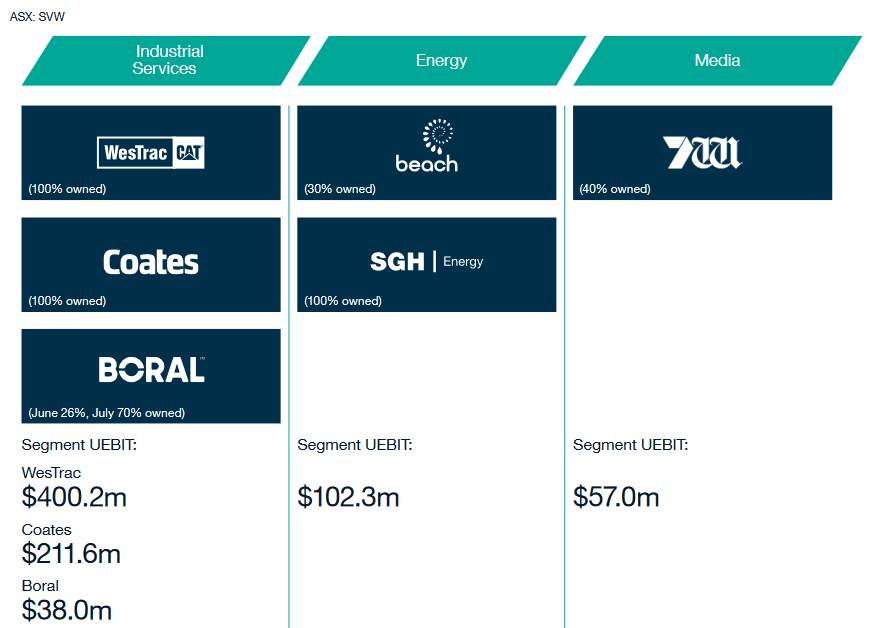

Source: [SVW Annual Report - 2021](https://www.sevengroup.com.au/assets/Annual-Reports/aab22ff81d/Annual-Report-2021.pdf). 

In comparison, the majority of NEC's assets relate to media businesses like Channel Nine, so using SVW for this share price analysis would be invalid as only a small proportion of its share price movements would relate to Channel 7 (and tweets about Channel 7). 

Note that the response variables selected are **categorical variables indicating whether the price Increased, Stayed the same or Decreased** (as opposed to the % movement in price) as this is what Question 4(a) specified. 

In practice, the use of lagged response variables relates to the testing of different holding periods for a stock. For example, the 1-day lagged response variable corresponds to buying a stock when a tweet is made, holding it for 1 day and then selling it. We later test each response variable to determine which trading strategy/holding period performs best. We structure the analysis in this way because knowing when to sell a stock is a critical part of any trading strategy. 

*   Testing the immediate price movement identifies if the stock moves immediately in relation to a tweet. (e.g. algorithms immediately buying the stock on a tweet, pushing the price up instantly)
*   Testing the one-hour lagged variable identifies if the stock takes time to move in relation to a tweet (e.g. human traders purchasing once they notice and read the tweet). 
*   Testing the one-day lagged variable also identifies the impact of overseas investors and traders, such as those based in America. For example, these tweets would typically be made outside of American business hours, and their corresponding purchases would occur the next day. 

In Question 4(b) and 4(c), we later find that the one-day response variable is the best performing, and we thus end up selecting it as the response variable. 



---



## **Question 3**
In this section, we apply various analytics techniques to the Twitter text data.

In [34]:
# We now subset the columns on the Twitter data, to drop off some of the helper columns created when merging the data.
cols_kept = ['username', 'name', 'tweet_post_time', 'tweet_text', 'tweet_likes', 'tweet_retweets', 
             'user_followers', 'user_friends', 'user_likes', 'user_tweets', 'user_public_lists', 'user_start_date', 'retweet', 
             'SVW_ch_cat', 'SVW_ch_cat1h', 'SVW_ch_cat1d', 'SVW_ch', 'SVW_ch1h', 'SVW_ch1d', 
             'NEC_ch_cat', 'NEC_ch_cat1h', 'NEC_ch_cat1d' ,'NEC_ch', 'NEC_ch1h', 'NEC_ch1d']
data_tweet_s = tw_merged[cols_kept]
data_tweet_s.shape

(147421, 25)

In [35]:
data_tweet_s.head(5)

,username,name,tweet_post_time,tweet_text,tweet_likes,tweet_retweets,user_followers,user_friends,user_likes,user_tweets,...,SVW_ch_cat1d,SVW_ch,SVW_ch1h,SVW_ch1d,NEC_ch_cat,NEC_ch_cat1h,NEC_ch_cat1d,NEC_ch,NEC_ch1h,NEC_ch1d
0,@darylsomers,Daryl Somers,2009-09-30 00:45:00,"make sure you tweet about Hey Hey tonight, usi...",2,6,4511,1,0,80,...,NA,NaN,NaN,NaN,NA,NA,NA,NaN,NaN,NaN
1,@darylsomers,Daryl Somers,2009-09-30 04:57:00,"if you're not already a fan, then join the Fan...",0,0,4511,1,0,80,...,NA,NaN,NaN,NaN,NA,NA,NA,NaN,NaN,NaN
2,@darylsomers,Daryl Somers,2009-09-30 04:59:00,@steven_noble check out the Facebook Fan Page ...,0,1,4511,1,0,80,...,NA,NaN,NaN,NaN,NA,NA,NA,NaN,NaN,NaN
3,@darylsomers,Daryl Somers,2009-09-30 05:21:00,very excited about Hey Hey It's Saturday - The...,0,0,4511,1,0,80,...,NA,NaN,NaN,NaN,NA,NA,NA,NaN,NaN,NaN
4,@darylsomers,Daryl Somers,2009-09-30 08:13:00,"A bit nervous, but mainly very excited! http...",0,0,4511,1,0,80,...,NA,NaN,NaN,NaN,NA,NA,NA,NaN,NaN,NaN


### **Question 3 (a)**

#### **Question 3 (a) (ii) - Clean data**
We clean the data prior to tokenisation because it is easier to operate on the entire string instead of iterating over each token within each tweet. 

In [36]:
# 0. Drop duplicate tweets. 
# Pandas checks for any rows where every single column is identical (i.e. an exact duplicate) and drops them.
# Reason: words in the duplicated tweets will receive too much 'weight' when modelling, so we need to remove them. 
print('Shape of data before dropping duplicates: ' + str(data_tweet_s.shape))
data_tweet_s = data_tweet_s.drop_duplicates()
print('Shape of data after dropping duplicates: ' + str(data_tweet_s.shape))

Shape of data before dropping duplicates: (147421, 25)
Shape of data after dropping duplicates: (144428, 25)


In [37]:
# 1. Extract 'RT' from retweet messages, and add retweet flag. 
# We are going to apply some minimal cleaning before tokenisation.
# We first note that retweet labels interfere with nltk.word_tokenize(). The retweet information is already captured by the retweet column and can thus be removed from tweet_text. 
# e.g. 'RT @MrTVAus:' gets tokenised into 'RT', '@', 'MrTVAus', ':' which likely adds little value when interpreting a tweet. So we will use Regex to remove this.
# Reason: RT appears in a huge number of tweets and doesn't actually contribute any additional useful information, so we instead separate them out of the text and contain it in a flag. 
data_tweet_s['tweet_text_clean'] = [re.sub(r'RT @.*: ', '', j) for j in list(data_tweet_s['tweet_text'])]
data_tweet_s['retweet_flag'] = [(1 if (j != 'FALSE') else 0) for j in list(data_tweet_s['retweet'])]

In [38]:
# 2. Extract URLs, and add URL flag
# Likewise, URLs interfere with tokenisation. 
# e.g. 'https://t.co/O7TNjEN7hJ' gets tokenised into 'https', ':', '//t.co/O7TNjEN7hJ' -- none of which will add much value when interpreting tweets. 
# So we will use Regex to flag them, add a 0/1 indicator if a URL is present, then remove them from the tweet text. 
# Reason: URLs also appear in a large number of tweets and simply cause difficulties when tokenising and vectorising, so we extract the presence of a URL and contain it in a flag. 
all_url_search = [re.search(r'http\S+', j) for j in list(data_tweet_s['tweet_text_clean'])] # Creates a list by searching if the string 'http' is found in any of the tweet texts
all_url_flag = [(1 if j else 0) for j in all_url_search] # Creates an indicator flag (0 or 1) if the 'http' string is found. 
data_tweet_s['url_flag'] = all_url_flag # Append to the dataframe
data_tweet_s['tweet_text_clean'] = [re.sub(r'http\S+', '', j) for j in list(data_tweet_s['tweet_text_clean'])]

**Check 1: spot check to see if URLs have been extracted correctly, and the URL flag correctly created.**

In [39]:
# First we pick a random tweet that has a URL in it.
print('Raw tweet text is: ' + data_tweet_s.loc[65456, 'tweet_text'])
print('Cleaned tweet text after removing URLs is: ' + data_tweet_s.loc[65456, 'tweet_text_clean'])
print('URL flag for this tweet is: ' + str(data_tweet_s.loc[65456, 'url_flag']))

Raw tweet text is: Weekend Today co-host Allison Langdon talks TV, career highlights and the joys of motherhood: https://t.co/4iiTlImthq https://t.co/LaQ4gTKsBu
Cleaned tweet text after removing URLs is: Weekend Today co-host Allison Langdon talks TV, career highlights and the joys of motherhood:  
URL flag for this tweet is: 1


Check 1 shows that URL extraction and URL flag creation is behaving correctly for this tweet.

In [40]:
# 3. Remove newline from tweet text
# Reason: new-line characters break many algorithms and may cause problems with the tokeniser. 
data_tweet_s['tweet_text_clean'] = [j.replace('\n', '') for j in list(data_tweet_s['tweet_text_clean'])]

In [41]:
# 4. Parse escaped HTML into regular text.
# For example, items like '&gt;' appear frequently in the tweet text. These are examples of unescaped HTML, and when printed should actually appear as '>' (i.e. 'greater than').
# We replace them accordingly (so that they can get captured when stripping out punctuation in the next step)
# Reason: Symbols like & and ; will get separated into their own token if not filtered out separately. 
data_tweet_s['tweet_text_clean'] = [saxutils.unescape(j) for j in list(data_tweet_s['tweet_text_clean'])]

In [42]:
# 5. Replace Emoji characters with their alternate-text. This replaces things like '😳' with 'emojiflushedemoji'.
# Reason: emojis can capture information or a message and should be retained, but we don't want them to be encoded as an actual word. 
# Note that I want to distinguish between an emoji and the word it represents, so that the model does not perceive them as the same thing.
# For example, I don't want '😳' to be processed identically to the actual word 'flushed', especially since the word 'flushed' can have many meanings (e.g. flushed the toilet), some of which are different to the emoji's meaning.
# Also, note that the standard syntax for emoji alt-text is to delimit with colon's. e.g. '😳' becomes ':flushed:'. 
# However, I have chosen to replace the : with ' emoji' because the : will get stripped later when filtering out punctuation. 
data_tweet_s['tweet_text_clean'] = [emoji.demojize(j, delimiters = (' emoji','emoji ') ) for j in list(data_tweet_s['tweet_text_clean'])]
# Many Emojis will have underscores separating their full name (e.g. :house_with_garden:). We remove the underscores to ensure that when stripping out punctuation, they don't separate into different words
# e.g. avoiding 'house_with_garden' becoming 'house with garden' 
data_tweet_s['tweet_text_clean'] = [re.sub(r'_', '', j) for j in list(data_tweet_s['tweet_text_clean'])] 

# Intended output: 
# '🏡' -> ' emojihouse_with_gardenemoji ' -> ' emojihousewithgardenemoji ' (noting the spaces around the start and end of the word - to ensure that emojis next to each other can be separated from each other)

**Check 2: spot check to see if emojis are parsed correctly into text.**

In [43]:
print('Raw tweet text is: ' + data_tweet_s.loc[98989, 'tweet_text'])
print('Cleaned tweet text is: ' + data_tweet_s.loc[98989, 'tweet_text_clean'])

Raw tweet text is: We're buzzing with excitement ð

#BBAU Tonight 7.30 on @Channel7 https://t.co/8y0J0IONB6
Cleaned tweet text is: We're buzzing with excitement ð#BBAU Tonight 7.30 on @Channel7 


Note that 😂 has been parsed into emojifacewithtearsofjoyemoji. This is intended behaviour and expected. We choose not to parse it into "face with tears of joy" because then the tokens will be treated equivalently to each word. (So words like "face" would become extremely common in the tokenised data, simply because of the presence of emojis). 

In [44]:
# 6. Insert spacing around punctuation to make it easier to clean them up
# Reason: passing words with punctuation into a tokeniser can sometimes cause problems - e.g. 'stop.' treated differently to 'stop'. We separate out punctuation to solve this. 
temp_pattern = re.compile(r"([.()!:#<>@|])")
data_tweet_s['tweet_text_clean'] = [temp_pattern.sub(" \\1 ", j) for j in list(data_tweet_s['tweet_text_clean'])] 

# We also observe a few instances of different apostrophes being used, which get treated differently by the tokenizer. So we replace them to ensure only one type of apostrophe exists. 
data_tweet_s['tweet_text_clean'] = [re.sub("’", "'", j) for j in list(data_tweet_s['tweet_text_clean'])] 
data_tweet_s['tweet_text_clean'] = [re.sub("“", '"', j) for j in list(data_tweet_s['tweet_text_clean'])] 
data_tweet_s['tweet_text_clean'] = [re.sub("”", '"', j) for j in list(data_tweet_s['tweet_text_clean'])] 
# Likewise, replace ellipsis character with three dots
data_tweet_s['tweet_text_clean'] = [re.sub("…", '...', j) for j in list(data_tweet_s['tweet_text_clean'])] 
# Replace em dashes with en dashes
data_tweet_s['tweet_text_clean'] = [re.sub("—", '-', j) for j in list(data_tweet_s['tweet_text_clean'])] 

In [45]:
# 7. Remove other symbols and punctuation
# Exclude apostrophe as that distinguish two different words - e.g. won't vs. wont
# Reason: passing punctuation into a tokeniser gives them their own token - e.g. "," becomes a token. This of course encodes no useful information, so we remove them. 
punct = string.punctuation.replace("'", "")
data_tweet_s['tweet_text_clean'] = [j.translate(str.maketrans('', '', punct)) for j in list(data_tweet_s['tweet_text_clean'])]

In [46]:
# 8. Remove other non-ASCII characters
# There are a lot of odd characters in the tweet texts that add no value and simply interfere with the tokenisation and vectorisation process.
# For example, box-drawing characters like ╬ and ╩ (which Twitter users presumably use to make pretty looking posts) are assigned their own tokens by the tokeniser if not treated appropriately.
# We remove these here. 
# Reason: characters like ╬ don't contain any useful information, so we remove them.
data_tweet_s['tweet_text_clean'] = [re.sub( r'[^\x00-\x7f]', r' ', j ) for j in list(data_tweet_s['tweet_text_clean'])] 

In [47]:
# 9. Lowercase all text
# Reason: ensure that things like "Words" are treated the same as "words", since their meaning is the same. 
data_tweet_s['tweet_text_clean'] = [j.lower() for j in list(data_tweet_s['tweet_text_clean'])]

**Check 3: verify that text has been lower-cased correctly.**

In [48]:
print('Raw tweet text is: ' + data_tweet_s.loc[77777, 'tweet_text'])
print('Cleaned tweet text is: ' + data_tweet_s.loc[77777, 'tweet_text_clean'])

Raw tweet text is: Love prevails! â¤ #MAFS
https://t.co/NanjaIRWu5
Cleaned tweet text is: love prevails         mafs


Check 3 shows that the text has been lower-cased correctly.

In [49]:
# 10. Create Corporate flag and Channel 9 flag
# In this section, we manually create other variables that may be of interest in modelling.
# corporate_flag represents accounts representing a company like Channel 7 or a television program run by a company, such as Farmer Wants A Wife
# We analyse this because we are interested in the ability of celebrities to move stock prices, and how this might compare to non-celebrities (like corporate accounts). 

# channel9_flag represents accounts for Channel 9, for shows broadcasted by Channel 9, or for celebrities whose main body of work is with Channel 9.
# At a later stage in the analysis (Question 4) we consider the impact on Channel 9's share price. 
# Reason: we are interested in measuring how the impact of a celebrity's tweets on stock prices compares to messages tweeted by corporate accounts like @Channel7. So we create this flag here. 

corporate_accounts = [
'@FarmerAustralia',
'@BHGAus',
'@GotTalentAU',
'@homeandawaytv2',
'@DancingAU',
'@THECHASEAUS',
'@SurvivorAU',
'@9Postcards',
'@NinjaWarriorAU',
'@thefrontbar7',
'@9DoctorDoctor',
'@9HotSeat_',
'@TVWEEKmag',
'@TheVoiceAU',
'@CarolsAustralia',
'@TheBlock',
'@MarriedAU',
'@LEGOMastersAU',
'@ACurrentAffair9',
'@BigBrotherAUNet',
'@60Mins',
'@Channel7',
'@Channel9',
'@sasaustralia',
'@Channel10AU',
'@AmazingGrace_S1',
'@NRLonNine',
'@7Cricket',
'@sunriseon7',
'@7horseracing',
'@TheTodayShow',
'@7AFL',
'@7NewsAustralia',
'@WeakestLinkAU',
'@9NewsAus'
]

channel9_accounts = [
'@AllisonLangdon',
'@karlstefanovic',
'@thelizhayes',
'@matty_russell',
'@SCrawf9',
'@Ken_Sutcliffe',
'@tracygrimshaw',
'@RebeccaMaddern9',
'@SurvivorAU',
'@9Postcards',
'@NinjaWarriorAU',
'@9DoctorDoctor',
'@9HotSeat_',
'@POTCFC',
'@CarolsAustralia',
'@TheBlock',
'@MarriedAU',
'@LEGOMastersAU',
'@ACurrentAffair9',
'@60Mins',
'@Channel9',
'@AmazingGrace_S1',
'@NRLonNine',
'@TheTodayShow',
'@WeakestLinkAU',
'@9NewsAus'
]

data_tweet_s['corporate_flag'] = [int(j) for j in data_tweet_s['username'].isin(corporate_accounts)]
data_tweet_s['channel9_flag'] = [int(j) for j in data_tweet_s['username'].isin(channel9_accounts)]


Final spot check to see if tweet text is cleaned correctly and relevant flags are created.

In [50]:
print('Raw text is: ' + data_tweet_s.loc[136615, 'tweet_text'])
print('Cleaned text is: ' + data_tweet_s.loc[136615, 'tweet_text_clean'])

Raw text is: The Queensland government has launched a new initiative to fill thousands of vacant jobs in the Sunshine State ð´âï¸
https://t.co/ZCvon3W95f
Cleaned text is: the queensland government has launched a new initiative to fill thousands of vacant jobs in the sunshine state           


In [51]:
data_tweet_s.loc[[136615]]

,username,name,tweet_post_time,tweet_text,tweet_likes,tweet_retweets,user_followers,user_friends,user_likes,user_tweets,...,NEC_ch_cat1h,NEC_ch_cat1d,NEC_ch,NEC_ch1h,NEC_ch1d,tweet_text_clean,retweet_flag,url_flag,corporate_flag,channel9_flag
136615,@sunriseon7,Sunrise,2021-05-19 20:07:00,The Queensland government has launched a new i...,5,0,462449,23285,7520,138929,...,Increased,Increased,0.007273,0.007273,0.050909,the queensland government has launched a new i...,0,1,1,0


This tweet shows that:


*   New-line characters are removed (the raw text spans two lines but cleaned spans one)
*   URLs were removed and the URL flag set to 1 
*   Emojis were parsed into their names
*   Text has been lower-cased
*   As the tweet was posted from a corporate account and not a celebrity's personal account (i.e. Sunrise on Channel 7), the corporate flag is set to 1. 
*   Sunrise is on Channel 7, so the Channel 9 flag is kept at 0. 

The output from the data cleaning process appears to be reasonable and working as intended.

#### **Question 3 (a) (i) - Extract and tokenise data**

In this step, we:


*   Tokenise the tweet text. We do this to ensure the keywords in a tweet are separated into their own items, so that they can easily be vectorised into a matrix of features later. 
*   Filter out stopwords. We do this because stopwords like "the" or "to" don't contain much useful information on their own, especially in the context of predicting the impact of words in a tweet on movements in a stock price.

We also include some checks on the data to ensure it is being cleaned correctly. Note that further checks on the data have been included in the Miscellanous Data Checks section of this notebook. We perform these checks to ensure that the data meets to specifications of the data dictionary, and is thus suitable for analysis.

In [52]:
# Here we split the key words in the cleaned tweet text into tokens
time_token_start = time.time()
ttoken = nltk.tokenize.TweetTokenizer() # Run the Tweet tokeniser
all_token_orig = [ttoken.tokenize(j) for j in list(data_tweet_s['tweet_text_clean'])] # loop tokeniser over every tweet
time_token_end = time.time()
print('Time taken to tokenize: {:.0f} seconds'.format(time_token_end - time_token_start))

Time taken to tokenize: 10 seconds


In [53]:
# Remove stopwords from the tokens
time_sw_start = time.time()
all_token = [[j for j in k if not j in nltk.corpus.stopwords.words('english')] for k in all_token_orig] # check if each word in each tweet is part of the stopword list
time_sw_end = time.time()
print('Time taken to remove stopwords: {:.0f} seconds'.format(time_sw_end - time_sw_start))

Time taken to remove stopwords: 843 seconds


**Check 1: testing what words are excluded as stopwords**

In [54]:
# Here, we check a few different words to see if they're present in the stopwords list, and consider whether they should be there or not. 
def check_stopword(word):
  print('Is "' + word + '" in the stopwords list? ' + str(word in nltk.corpus.stopwords.words('english')))
check_stopword('stock') # This is not in the stopwords list, as stock would be considered a keyword. 
check_stopword('the') # the is not a keyword, so part of the stopwords. 
check_stopword('out') # out is not a keyword of interest - not part of stopwords. 
check_stopword('television') # television is a word of interest, and isn't part of the stopwords list.

Is "stock" in the stopwords list? False
Is "the" in the stopwords list? True
Is "out" in the stopwords list? True
Is "television" in the stopwords list? False


The words checked appear to be fine - uninteresting words removed as part of the stopword list, and useful words are not, as expected.

**Check 2: checking the input before tokenisation and comparing against the output after tokenisation.**

In [55]:
print('Example raw tweet:')
print(data_tweet_s.iloc[2]['tweet_text'])

print('-----')
print('Example tweet after cleaning and tokenisation')
print(all_token[2])

Example raw tweet:
@steven_noble check out the Facebook Fan Page update - linking back to this username: http://www.facebook.com/heyheyitssaturday #heyhey
-----
Example tweet after cleaning and tokenisation
['stevennoble', 'check', 'facebook', 'fan', 'page', 'update', 'linking', 'back', 'username', 'heyhey']


This appears to be behaving correctly. We can see that key words such as "facebook", "fan", "page", "heyhey" (it's Saturday), etc. have been extracted from the tweet as tokens. Commonly used words in the English language (stop words) such as "the" and "to" are not included as tokens. Because each keyword receives its own token, the data is suitable for analysis. 

#### **Question 3 (a) (iii) - Lemmatisation**

In this step, we perform lemmatisation, which maps conjugates of a word to the base word. For example, "saves" could be lemmatised to its base word "save". We perform lemmatisation because it would not make sense to treat a word like "saves" as an entirely different word to "save", given they have the same base meaning. 

We choose to implement lemmatisation instead of stemming because it is a more sophisticated method that can capture other relationships between words. For example, stemming cannot convert "swam" to "swim", but lemmatisation can.

In [56]:
lemmatizer = nltk.stem.WordNetLemmatizer() # Initialise lemmatiser
all_token_l = [[lemmatizer.lemmatize(k) for k in j] for j in all_token] # For every tweet in all_token, apply the lemmatiser to every token in every tweet. 

**Check 1: compare tokens before and after lemmatisation**

In [57]:
def check_lemmatise(tweet_num):
  print('Example raw tweet:')
  print(data_tweet_s.iloc[tweet_num]['tweet_text'])
  print('-----')
  print('Example tweet after cleaning and tokenisation')
  print(all_token[tweet_num])
  print('-----')
  print('Example tweet after cleaning, tokenisation and lemmatisation')
  print(all_token_l[tweet_num])

check_lemmatise(15951)

Example raw tweet:
RT @ltlblkdress: And Sriani saves #dancingau again!! @DancingAU @ToddMcKenney
-----
Example tweet after cleaning and tokenisation
['sriani', 'saves', 'dancingau', 'dancingau', 'toddmckenney']
-----
Example tweet after cleaning, tokenisation and lemmatisation
['sriani', 'save', 'dancingau', 'dancingau', 'toddmckenney']


We can see that "saves" is lemmatised to "save", as they have the same base word. This is as expected, so the output is reasonable.

**Check 2: further comparison of tokens before and after lemmatisation**

In [58]:
check_lemmatise(88888)

Example raw tweet:
The town of Lake Conjola represents a lot of communities around Australia where fire came fast, unexpected and destroyed far more than was predicted. #60Mins https://t.co/2BQ2SeHgYW
-----
Example tweet after cleaning and tokenisation
['town', 'lake', 'conjola', 'represents', 'lot', 'communities', 'around', 'australia', 'fire', 'came', 'fast', 'unexpected', 'destroyed', 'far', 'predicted', '60mins']
-----
Example tweet after cleaning, tokenisation and lemmatisation
['town', 'lake', 'conjola', 'represents', 'lot', 'community', 'around', 'australia', 'fire', 'came', 'fast', 'unexpected', 'destroyed', 'far', 'predicted', '60mins']


Remark: we can see that some words like "communities" get lemmatised to their base word "community", as expected. However, some words don't - e.g. "represents" stays as such instead of being shortened to its base "represent"; and likewise "destroyed" doesn't get shortened to "destroy". This is likely because the WordNet Lemmatiser treats these words differently (depending on the part of speech, like noun/adjective/verb etc. and the tense (past, current, or future tense). So this is behaving as intended because the lemmatiser treats them differently

#### **Question 3 (a) (iv) - Vectorisation**
This section contains the following steps:



1.   Filtering the tweets to only those where we have relevant stock price data available. This is because we only have stock price data available between July 2020 and June 2021, so we can only analyse the effect of tweets on stock prices over this same period. Moreover, many of the tweets provided are from pre-2015, where the usage of Twitter (particularly for trading) was likely very different and much lower. 
2.   Splitting dataset into training, testing and holdout sets. The testing set will be used for selecting parameters and identifying how well the models capture signal, while the holdout set will be used for assessment/comparison of model performance in Question 4 (d). Further details below.
3.   Running the TF-IDF vectoriser from SKLearn on the training set. 

**Further details on train/test/holdout splits:**

We split the data into training/testing and holdout sets by time. This is to ensure that we can perform a valid back-test when validating the model.

Specifically, the training and testing sets are formed from all tweets occurring between the first available stock data (1 July 2020) and 14 May 2021. The holdout set is formed from all tweets occurring between 15 May 2021 and 23 June 2021 (the last available stock data). **We have chosen to split at this date as this ensures that the holdout set is roughly 20-25% of all rows, which is a standard size for the holdout set.** Note that there are a greater number of tweets occurring in more recent months, which is why the split occurs so late in the data.

We must split the data here because data from the "future" must not be allowed to enter the corpus, the TF-IDF matrix, the PCA weights, the clusters, or the models in Question 4. For example, a model built on 2018 data should not contain the word "COVID" in its corpus. In short, we use an out-of-time holdout set to avoid data leakage.

The training and testing sets will be split randomly. 80% of tweets occurring between 1 July 2020 and 30 April 2021 will be randomly selected to form the training set, while the remaining 20% will form the testing set. We use an in-time testing set because the purpose of the testing set is to assist with tweaking parameters to ensure that the model is able to best capture signal in the data. 

The benefit of this approach is that the testing set allows us to measure model performance after controlling for time trends (by using an in-time sample), while the holdout set allows for an accurate "simulation" of the model's performance by using an out-of-time sample.

**What is vectorisation and why do we do it?** Vectorisation is the process of converting an array of tokens into a matrix of numeric features, ready for use by a machine learning model. We choose the TF-IDF vectoriser (Term Frequency-Inverse Document Frequency) as a more sophisticated vectoriser compared to Bag of Words because it assigns higher weights to words when:


*   it appears more frequently in the tweet, and
*   it appears less frequently in the entire corpus, which ensures that common terms that appear in many tweets don't get given high weights as they're not likely to be of interest.

We perform this step because it ensures that the data is in a suitable form for a model to analyse. It is also useful compared to other vectorisation methods as it implicitly assigns lower weights to stop-words and other uninteresting words due to their high frequency in the corpus. 

In [59]:
# Append the tokens onto the dataframe. 
data_tweet_s['token'] = all_token_l

In [60]:
# Define the dates used to split into train/test/holdout sets
date_holdout_split = pd.to_datetime('2021-05-15 00:00', format = '%Y-%m-%d %H:%M') # This is where we split train/test from holdout

In [61]:
# Twitter training and testing sets
tweet_train_test = data_tweet_s.loc[(data_tweet_s['tweet_post_time'] >= date_start_gmt) & (data_tweet_s['tweet_post_time'] < date_holdout_split)]
# Twitter holdout set (Final date is one day before the last available stock data, so that we can test the use of lagged holding periods)
tweet_holdout = data_tweet_s.loc[(data_tweet_s['tweet_post_time'] >= date_holdout_split) & (data_tweet_s['tweet_post_time'] < date_end_gmt - datetime.timedelta(days = 1))]

# Get Twitter training and testing sets separately via random 80:20 split
tweet_train, tweet_test = train_test_split(tweet_train_test, test_size = 0.2, random_state = seed)

print('Shape of training set is ' + str(tweet_train.shape))
print('Shape of testing set is ' + str(tweet_test.shape))
print('Shape of holdout set is ' + str(tweet_holdout.shape))

Shape of training set is (28676, 31)
Shape of testing set is (7170, 31)
Shape of holdout set is (10139, 31)


In [62]:
def TransformTFIDF(train_data, score_data, max_tfidf_feat, stop_words = nltk.corpus.stopwords.words('english'), as_dense = False):
  '''
  train_data is a Pandas Series containing the words to train the TF-IDF model on.

  score_data is a Pandas Series containing the words to score the TF-IDF model on. 

  max_tfidf_feat is a integer representing the maximum number of TF-IDF features to fit. 
  Specify this if there is insufficient RAM to generate the full TF-IDF matrix.
  This will select the N most frequent words across all documents, and build the matrix using this. 

  stop_words is a list containing any words to exclude. Defaults to the NLTK English language stopwords. 

  as_dense is a Boolean specifying if the output should be coerced to a dense matrix before outputting.
  '''
  tfidf = TfidfVectorizer(stop_words = stop_words, max_features = max_tfidf_feat) # Initialise the TF-IDF vectoriser object
  # Explanation of options: 
  #   - We pass the NLTK list of English stopwords, and these get removed from the corpus before vectorisation. This helps in removing words with little meaning in this context, and reduces dimensionality.
  #   - We set the maximum number of features for the TF-IDF vectoriser to 2400.
  #     - When PCA is performed on the TF-IDF matrices, Google Colab often crashes. This is because PCA by nature operates on dense matrices rather than sparse. Therefore, it is not particularly memory efficient.
  #     - Setting max_features = N forces the model to construct the vocabulary by taking the top N features (by frequency) across the corpus. 
  model = tfidf.fit(list(train_data)) # Fit the TF-IDF model on the training dataset
  tfidf_train = model.transform(list(train_data)) # Score on the training set
  tfidf_score = model.transform(list(score_data)) # and also on the scoring dataset (usually test data)
  if as_dense: # If True, convert from sparse (original output) to dense. 
    tfidf_train = np.asarray(tfidf_train.todense())
    tfidf_score = np.asarray(tfidf_score.todense())
  print('Shape of TF-IDF training matrix is ' + str(tfidf_train.shape))
  print('Shape of TF-IDF scoring matrix is ' + str(tfidf_score.shape))
  return model, tfidf_train, tfidf_score # Return output

**Check 1: ensuring the vectorised features are of the correct shape**

In [63]:
tfidf_models = dict() # Initialise control object to store TF-IDF models
tfidf_models['train'], vec_train, vec_test = TransformTFIDF(tweet_train['tweet_text_clean'], tweet_test['tweet_text_clean'], 2400, as_dense = True)

Shape of TF-IDF training matrix is (28676, 2400)
Shape of TF-IDF scoring matrix is (7170, 2400)


We can see that before vectorisation, the training set had 28,676 rows; and after vectorisation, it still has 28,676 rows as expected. The number of columns is 2,400 - which is consistent with the maximum number of features we have selected. So this result is reasonable.

**Check 2: check some of the TF-IDF weights to see if they make sense**

In [64]:
tfidf_wgts = pd.DataFrame({
    'token': tfidf_models['train'].vocabulary_.keys(),
    'tfidf_wgt': tfidf_models['train'].vocabulary_.values()
})
tfidf_wgts.sample(10, random_state = seed)

,token,tfidf_wgt
1238,"(50, bbl10, warning, tonight, show, may, theli...","(46, 233, 2312, 2175, 1913, 1350, 2136, 39, 2,..."
2257,"(50, bbl10, warning, tonight, show, may, theli...","(46, 233, 2312, 2175, 1913, 1350, 2136, 39, 2,..."
691,"(50, bbl10, warning, tonight, show, may, theli...","(46, 233, 2312, 2175, 1913, 1350, 2136, 39, 2,..."
2365,"(50, bbl10, warning, tonight, show, may, theli...","(46, 233, 2312, 2175, 1913, 1350, 2136, 39, 2,..."
2130,"(50, bbl10, warning, tonight, show, may, theli...","(46, 233, 2312, 2175, 1913, 1350, 2136, 39, 2,..."
721,"(50, bbl10, warning, tonight, show, may, theli...","(46, 233, 2312, 2175, 1913, 1350, 2136, 39, 2,..."
1772,"(50, bbl10, warning, tonight, show, may, theli...","(46, 233, 2312, 2175, 1913, 1350, 2136, 39, 2,..."
59,"(50, bbl10, warning, tonight, show, may, theli...","(46, 233, 2312, 2175, 1913, 1350, 2136, 39, 2,..."
455,"(50, bbl10, warning, tonight, show, may, theli...","(46, 233, 2312, 2175, 1913, 1350, 2136, 39, 2,..."
2276,"(50, bbl10, warning, tonight, show, may, theli...","(46, 233, 2312, 2175, 1913, 1350, 2136, 39, 2,..."


We've shown the TF-IDF weights for a random sample of words. It is clear that common words like "among" and "content" have been assigned low TF-IDF weights presumably due to appearing in many different tweets in the corpus. Conversely, rare words like "surge", or names like "Turner" or "Zealand" receive higher weights due to appearing across fewer tweets in the corpus. Therefore, the TF-IDF weights look reasonable and make sense.



---




### **Question 3 (b)**

#### **Question 3 (b) (i) - Advantages and disadvantages of PCA**

**Advantage 1: Reduced dimensionality:**

PCA allows us to reduce the dimensionality of the dataset by only selecting the principal components that explain the most variability in the dataset. This means that models fit on the principal components can perform better than those fit on the original data by reducing the extent of overfitting (since fewer features are passed into the model). It may also speed up the fitting of a model significantly.   

This is a relevant consideration in the building of a stock trading algorithm because overfitting can cause the model to incorporate the significant amounts of noise that are present in Twitter data. Furthermore, models need to be able to score new tweets quickly so that it is able to identify and act on potentially market-moving tweets. 

In addition, many algorithms like K-means clustering (used in this analysis) suffer from the Curse of Dimensionality. In the case of K-means clustering, this occurs because the way that distance between points is measured (Euclidean distance) becomes less precise as the number of dimensions grows. This means it becomes increasingly difficult to identify distinct clusters. When clustering documents such as tweets, the resulting data can have thousands of predictors and thus it is critical to reduce dimensionality (via PCA) in this sort of problem. 

**Advantage 2: Removing correlated features:**

PCA identifies linear combinations of features that explain the most variability in the data. The resulting principal components are uncorrelated with each other. Fitting models on uncorrelated features can have many benefits. 

For example, if certain tokens have similar meanings and appear to affect stock prices in the same way, it doesn’t make sense to include both features into a model separately. Multicollinearity in the model simply degrades performance by making coefficient estimates unstable. It also becomes difficult to identify which tokens are highly predictive of price movement if many are highly correlated. Removing these correlated features makes the model more robust and stable.  

**Disadvantage 1: Time complexity:**

The PCA algorithm is of [(up to) cubic complexity](https://alekhyo.medium.com/computational-complexity-of-pca-4cb61143b7e5), primarily because the covariance matrix computations involved are very intensive. So while PCA is an effective method of reducing dimensionality, one of the critical disadvantages of PCA is that it can take a very long time to run on larger datasets, especially those with a huge number of features like the vectorized Twitter data. This time complexity also means that PCA scales up poorly on data with larger numbers of features. 

PCA can also require very large amounts of memory, and the fund may not have access to sufficiently powerful computers to train these models. This is because standard PCA methods only generate dense matrices rather than memory-efficient sparse matrices (as PCA must centre the data before computation). Alternative dimensionality reduction methods like Truncated Singular Value Decomposition (which work on sparse matrices) may be more practical for high-dimensionality datasets such as the Twitter data.  

**Disadvantage 2: Loss of interpretability:**

The features created by applying PCA are linear combinations of the original features. This means it can be difficult to interpret model output since it will be built on transformations of the original features. 

In the context of the Twitter analysis, the variables are no longer the tokens but rather a weighted sum of all (or many of) the tokens in the dataset. This means it is difficult to understand which words or tokens are important predictors of stock price movements because each input variable into the model is a mash-up (linear combination) of the original tokens. 


#### **Question 3 (b) (ii) - Principal components analysis**

**What is PCA and why is this being undertaken?** Principal Components Analysis is an algorithm used to reduce the dimensionality of data by taking linear transformations of features that capture the largest variability in the data. We are doing this because building models on all features can be extremely time consuming and computationally expensive, so reducing the dimensionality of the data can speed things up considerably. Furthermore, running a clustering algorithm on a very high-dimensional dataset (i.e. too many columns) can weaken the model's ability to identify clusters -- see the above section on the Curse of Dimensionality. Therefore, we reduce the dimensionality of the dataset prior to running these models. 

Note that we only fit the PCA model on the training dataset, and score it on the testing set. This is to avoid data leakage between the training and testing datasets. For example, it would not make sense to build a neural network in Question 4(b) using the principal components as predictors, if the principal components were constructed using both training and testing data. 

In [65]:
def FitPCA(train_data, score_data = None, n_components = None):
  '''
  This function calculates the principal components on the training data, and then also scores it on the other dataset provided.

  train_data is a NumPy ndarray containing the training data.

  score_data (optional) is a NumPy ndarray containing the data to score on (usually a testing dataset).

  n_components (optional) is an integer specifying how many principal components to fit in the model. 
  '''
  # Firstly, scale all features in the dataset to have zero mean and unit variance.
  sc = StandardScaler() # Initialise scaler object
  sc.fit(train_data) # Fit PCA model to the training dataset
  sc_train = sc.transform(train_data) # Score on training data
  if score_data is not None:
    sc_score = sc.transform(score_data) # and the scoring/testing dataset, if provided
  
  # Secondly, fit the PCA model on the scaled components
  if n_components is None:
    model = PCA() # Initialise PCA object
  else:
    model = PCA(n_components = n_components)
  time_pca_start = time.time() # Benchmarking performance
  model.fit(train_data) # Fit the PCA model
  time_pca_end = time.time() # Benchmarking performance
  print('Time taken to fit PCA model: {:.0f} seconds'.format(time_pca_end - time_pca_start))
  pca_train = model.transform(train_data) # Score on the training dataset
  print('Shape of training principal components is ' + str(pca_train.shape))
  if score_data is not None:
    pca_score = model.transform(score_data) # Score on the scoring (e.g. testing) dataset if provided
    print('Shape of scoring principal components is ' + str(pca_score.shape))
    return model, pca_train, pca_score
  else:
    return model, pca_train

In [66]:
def ChartExplainedVariance(model):
  '''
  This function takes the PCA model, extracts and charts the % of variance explained by each variable.

  model is the PCA model object.
  '''

  expl_var = pd.DataFrame({
      'Principal Component': range(1, 1 + len(model.explained_variance_ratio_)),
      'Explained Variance': model.explained_variance_ratio_
  })
  top_expl_var_chart = expl_var.head(10).plot.bar(x = 'Principal Component', y = 'Explained Variance')
  all_expl_var_chart = expl_var.plot.line(x = 'Principal Component', y = 'Explained Variance')

  # Output
  print('Showing the bar chart of the top 10 most important variables:')
  print(top_expl_var_chart)
  print('Showing the % variance explained for all principal components:')
  print(all_expl_var_chart)
  return expl_var

In [67]:
pca_models = dict() # Initialise control object to store PCA models
pca_models['train_full'], pca_all_comp = FitPCA(vec_train) # This fits a PCA model and returns all principal components. 
# The goal is to fit all principal components and then plot the explained variance proportions, so we can select an appropriate number of components to use (i.e. at the elbow) and refit the PCA model. 

Time taken to fit PCA model: 23 seconds
Shape of training principal components is (28676, 2400)


Showing the bar chart of the top 10 most important variables:
AxesSubplot(0.125,0.125;0.775x0.755)
Showing the % variance explained for all principal components:
AxesSubplot(0.125,0.125;0.775x0.755)


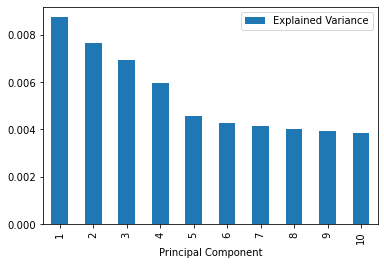

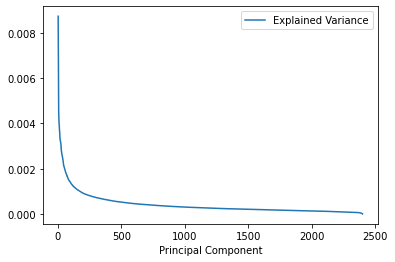

In [68]:
pca_expl_var_data = ChartExplainedVariance(pca_models['train_full'])
del pca_all_comp # no longer needed after charting

In [69]:
print('The proportion of variance explained by the first 100 Principal Components is: ' + str(pca_expl_var_data.head(100)['Explained Variance'].sum()))

The proportion of variance explained by the first 100 Principal Components is: 0.2451019462205348


**Justifying the reduced dimension size selected:**

We have chosen to use **100 principal components**. It is clear from the above explained variance chart that there is an elbow around 100 components, indicating that there is diminishing returns from including later principal components. This makes sense, as the first few principal components will capture the greatest variation in the data. Including more than 100 features here will simply cause models to take longer to fit, increase the potential for over-fitting and introduce noise into the data. 

It is worth noting that using 100 features only captures about 23% of the data, as shown above. However, to capture a large portion of the variation, you would need to use a large number of principal components, which defeats the purpose of dimensionality reduction. Below, we show that in order to explain approximately 80% of the variance, you need to retain 1200 (or 50%) of the features. 

In [70]:
print('The proportion of variance explained by the first 1200 Principal Components is: ' + str(pca_expl_var_data.head(1200)['Explained Variance'].sum()))

The proportion of variance explained by the first 1200 Principal Components is: 0.8102909227717932


Another reason for choosing a smaller number of components like 100 is the fact that we later use these principal components in the K-means clustering algorithm. Passing the entire TF-IDF matrix (2400 features), or a large number of PCA features (e.g. the 1200 features used to capture 80% of the data) would significantly weaken the power of the clustering algorithm, because clustering using Euclidean distance performs poorly in extremely high-dimensional spaces. See the discussion in Question 3 (b) (i) on the Curse of Dimensionality for further information.

**Check 1: ensure that the dimension of the output data has been reduced correctly.**
 

In [71]:
pca_thresh = 100 # There is an elbow at about 100 principal components. The amount of explained variance drops off heavily afterwards (diminishing returns)
pca_models['train_reduced'], vec_pca_train, vec_pca_test = FitPCA(vec_train, score_data = vec_test, n_components = pca_thresh)

Time taken to fit PCA model: 5 seconds
Shape of training principal components is (28676, 100)
Shape of scoring principal components is (7170, 100)


The input data (i.e. TF-IDF matrix) had 2400 features. The output above has the same number of rows, but only 100 features, as we have chosen to use 100 principal components. Therefore, the algorithm is behaving as expected and the results are reasonable.

In [72]:
pca_expl_var_data['Explained Variance'].shift(1)

0            NaN
1       0.008744
2       0.007652
3       0.006921
4       0.005945
          ...   
2395    0.000014
2396    0.000014
2397    0.000013
2398    0.000009
2399    0.000005
Name: Explained Variance, Length: 2400, dtype: float64

**Check 2: ensure that the explained variance of the principal components are in descending order**

The PCA algorithm ensures that the first principal component (PC) explains the largest proportion of variance, the second PC explains the 2nd most, etc. We check that this is actually true of the PC's that we have calculated.

In [73]:
# Calculate the explained variance of PC2 - PC1, PC3 - PC2, PC4 - PC3, ...
diff_expl_var = pca_expl_var_data['Explained Variance'] - pca_expl_var_data['Explained Variance'].shift(1)
# Explained variance(PC1) should be > Explained variance(PC2) etc., so this difference should be negative.
print('How many differences in the explained variances of consecutive principal components are negative?')
print((diff_expl_var.iloc[1:] < 0).value_counts())

How many differences in the explained variances of consecutive principal components are negative?
True    2399
Name: Explained Variance, dtype: int64


All consecutive differences are negative, meaning that the explained variance of principal components are indeed in descending order. This can also be seen in the line chart of principal components above. So, the algorithm is behaving as expected.


---



### **Question 3 (c) - K-means clustering**

**What is K-means clustering and why are we undertaking this step?** K-means clustering is an algorithm that partitions a dataset into K clusters by minimising the variation within each cluster. This helps to ensure that observations in a cluster are sufficiently similar by having a low Euclidean distance between each other. We are undertaking this step to see if we can identify distinct topics in the Twitter dataset, as the "topic" of a tweet may be a useful predictive feature in determining the effect on a television network's stock price. 

Currently, we apply K-means clustering to the data after dimensionality reduction has been applied using PCA. This helps to avoid the Curse of Dimensionality -- see Question 3 (b) (i) for further explanation. 

In [74]:
def FitKMeans(indata, num_cluster, scaler, seed):
  '''
  indata is a Numpy array containing the data to be clustered.

  num_cluster is an integer - the number of clusters to be fitted.

  scaler is a StandardScaler object specifying how to pre-process the data (typically, scaling to mean 0 and variance 1).
  '''

  time_kmeans_start = time.time() # Benchmark time taken
  
  kmeans = KMeans(n_clusters = num_cluster, random_state = seed) # Initialise K-Means object
  kmeans_pipeline = make_pipeline(scaler, kmeans) # Pre-process data as defined in scaler
  kmeans_pipeline.fit(indata) # Fit to data

  time_kmeans_end = time.time()
  print('Completed model fit with ' + str(num_cluster) + ' clusters in ' + str(time_kmeans_end - time_kmeans_start) + ' seconds.')

  return kmeans, kmeans_pipeline

In [75]:
def FitAllKMeans(indata, max_clusters, seed):
  '''
  FitAllKMeans is a wrapper function to fit many K-means clustering models, calculate their inertia and plot them to assist in the selection of the best model. 

  indata is a NumPy ndarray or Pandas DataFrame containing the data to fit the clustering model on. 

  max_clusters is an integer representing the maximum number of clusters to test the model on. The function will test fitting 1 cluster, 2 clusters, ..., max_clusters clusters, and record their inertia.
  '''
  sc = StandardScaler() # Initialise scaling object. We pre-process the data to ensure all features range from 0 to 1, to ensure no feature dominates simply due to having a larger scale. 
  models = []
  pipelines = []
  wcss = []
  for K in range(1, max_clusters + 1): # add 1 since indexing starts at 0
    temp_model, temp_pipe = FitKMeans(indata = indata, num_cluster = K, scaler = sc, seed = seed) # Train model with K clusters
    models.append(temp_model) # Store the model in model control object
    pipelines.append(temp_pipe) # Store pipeline object
    wcss.append(temp_model.inertia_) # Store the WCSS
  wcss_df = pd.DataFrame({'Number of clusters': range(1, max_clusters+1), 'WCSS': wcss}) # Construct DataFrame to help in plotting the WCSS
  wcss_df.plot.line(x = 'Number of clusters', y = 'WCSS') # Plot line chart of inertia by number of clusters
  return models, pipelines # Output

Completed model fit with 1 clusters in 2.6634321212768555 seconds.
Completed model fit with 2 clusters in 0.7061207294464111 seconds.
Completed model fit with 3 clusters in 1.0930681228637695 seconds.
Completed model fit with 4 clusters in 1.2219057083129883 seconds.
Completed model fit with 5 clusters in 1.6626670360565186 seconds.
Completed model fit with 6 clusters in 1.9394936561584473 seconds.
Completed model fit with 7 clusters in 2.2197017669677734 seconds.
Completed model fit with 8 clusters in 2.147968053817749 seconds.
Completed model fit with 9 clusters in 2.3601841926574707 seconds.
Completed model fit with 10 clusters in 2.9084455966949463 seconds.
Completed model fit with 11 clusters in 3.350172281265259 seconds.
Completed model fit with 12 clusters in 3.2100353240966797 seconds.


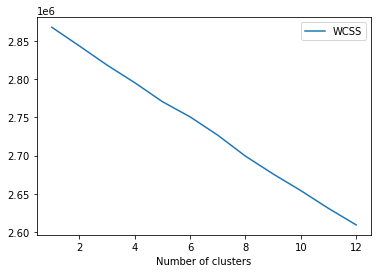

In [76]:
max_num_clusters = 12 # We test the performance of varying numbers of clusters, up to 12 clusters. 
km_obj, kmeans_train = FitAllKMeans(indata = vec_pca_train, max_clusters = max_num_clusters, seed = seed)

**Justifying the selected number of clusters:**

It is difficult to justify any selection of clusters here because there appears to be no elbow in the plot of within-cluster variation. Since we are looking for a **small number** of clusters, but no clear elbow exists, we will simply select `k = 4` clusters. The clusters are evaluated in Question 3(d) and they also appear to have reasonably distinct "topics". Moreover, we show in Question 3(d) via the internal validation metrics that using 4 clusters generates  better all-round results compared to 3 clusters, and sometimes better than using 2 clusters too. Refer to that section for further explanation.

In [77]:
def GetClusterLabels(model, score_data, score_data_2 = None, print_output = True):
  '''
  GetClusterLabels is a wrapper function to help quickly extract the cluster labels.

  model is the KMeans model fitted that we want to score with.

  score_data is a NumPy ndarray or Pandas DataFrame containing the data we want to score.

  score_data_2 (optional) is a NumPy ndarray or Pandas DataFrame containing another dataset we want to score.
  '''
  cluster1 = [str(j) for j in model.predict(score_data)] # Score KMeans model on dataset. Pass through str() to ensure Python knows they are categorical, not numeric. 
  cluster1_counts = [[x,cluster1.count(x)] for x in set(cluster1)]

  if print_output:
    print('Distribution of clusters on first dataset: ')
    print(cluster1_counts)

  if score_data_2 is not None:
    cluster2 = [str(j) for j in model.predict(score_data_2)] # Repeat on second dataset if provided
    cluster2_counts = [[x,cluster2.count(x)] for x in set(cluster2)]
    if print_output:
      print('Distribution of clusters on second dataset: ')
      print(cluster2_counts)
    return cluster1, cluster2 # Output 
  else:
    return cluster1

**Check 1: checking the distribution of clusters**

We check how cluster labels are distributed on the training and testing set to:



*   ensure we don't somehow have more clusters than we intended to create 
*   check if the number of observations in each cluster is reasonably balanced.



In [78]:
selected_K = 4 # Number of clusters we have selected
selected_kmeans_model = kmeans_train[selected_K - 1] # Subtract 1 because Python indexes at 0; so model 0 has 1 cluster, model 1 has 2 clusters, etc. 
tweet_train['cluster'], tweet_test['cluster'] = GetClusterLabels(model = selected_kmeans_model, score_data = vec_pca_train, score_data_2 = vec_pca_test)

Distribution of clusters on first dataset: 
[['2', 1660], ['1', 383], ['0', 400], ['3', 26233]]
Distribution of clusters on second dataset: 
[['2', 352], ['1', 102], ['0', 105], ['3', 6611]]


Remark: The correct number of clusters has been created, so it is behaving as expected. The number of observations in each cluster is quite unbalanced, but selecting different values of `K` (different numbers of clusters) often seems to cause even more unbalanced cluster labels. 


---



### **Question 3 (d) - Evaluating the clusters**

In this section, we will perform both internal validation and manual validation. The purpose of the internal validation is to determine if we have selected an appropriate number of clusters. However, the manual validation step is more important in identifying if the clusters are logical. Finally, we include an assessment on whether the clusters identified by the K-means algorithm are actually useful in predicting share price movements.

#### **Internal validation**

To perform internal validation, we calculate the following metrics:


*   Davies-Bouldin index (lower is better)
*   Silhouette score (best value = 1, worst value = -1)
*   Calinski-Harabasz score (higher is better)

**Using internal validation metrics:** It is worth noting that most internal clustering validation metrics simply produce heuristic scores, and there is no particular threshold for what is considered, say, a "good Davies-Bouldin score". The correct way to use internal validation metrics is to compare different clustering models using the same criteria. 

Therefore, we will score the various clustering models fitted above (from 2 clusters up to 12 clusters) on the testing dataset, calculate internal validation metrics and compare their performance.

In [79]:
def InternalValidation(min_num_cluster = 2, max_num_cluster = 12):
  '''
  This function scores the clustering models fitted on the training and testing dataset, then calculates internal validation metrics 
  (Davies-Bouldin index, Silhouette score and Calinski-Harabasz score) on all of the clustering models. 
  '''
  labels_train = dict()
  labels_test = dict()
  db_index = dict()
  silh_sc = dict()
  ch_score = dict()
  for k in range(2,12+1):
    labels_train[k], labels_test[k] = GetClusterLabels(model = kmeans_train[k - 1], score_data = vec_pca_train, score_data_2 = vec_pca_test, print_output = False)
  for k in range(2,12+1):
    db_index[k] = metrics.davies_bouldin_score(X = vec_pca_test, labels = labels_test[k])
    silh_sc[k] = metrics.silhouette_score(X = vec_pca_test, labels = labels_test[k])
    ch_score[k] = metrics.calinski_harabasz_score(X = vec_pca_test, labels = labels_test[k])
  out = pd.DataFrame({
      'Number of clusters': labels_train.keys(),
      'Davies-Bouldin index': db_index.values(),
      'Silhouette score': silh_sc.values(),
      'Calinski-Harabasz score': ch_score.values()
  })
  return out

In [80]:
InternalValidation(2, 12)

,Number of clusters,Davies-Bouldin index,Silhouette score,Calinski-Harabasz score
0,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)","(2.6946837448795957, 2.4782693562006344, 3.198...","(0.06859713662637984, 0.1196067008324075, 0.05...","(40.79652115516318, 80.46172693934132, 66.3409..."
1,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)","(2.6946837448795957, 2.4782693562006344, 3.198...","(0.06859713662637984, 0.1196067008324075, 0.05...","(40.79652115516318, 80.46172693934132, 66.3409..."
2,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)","(2.6946837448795957, 2.4782693562006344, 3.198...","(0.06859713662637984, 0.1196067008324075, 0.05...","(40.79652115516318, 80.46172693934132, 66.3409..."
3,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)","(2.6946837448795957, 2.4782693562006344, 3.198...","(0.06859713662637984, 0.1196067008324075, 0.05...","(40.79652115516318, 80.46172693934132, 66.3409..."
4,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)","(2.6946837448795957, 2.4782693562006344, 3.198...","(0.06859713662637984, 0.1196067008324075, 0.05...","(40.79652115516318, 80.46172693934132, 66.3409..."
5,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)","(2.6946837448795957, 2.4782693562006344, 3.198...","(0.06859713662637984, 0.1196067008324075, 0.05...","(40.79652115516318, 80.46172693934132, 66.3409..."
6,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)","(2.6946837448795957, 2.4782693562006344, 3.198...","(0.06859713662637984, 0.1196067008324075, 0.05...","(40.79652115516318, 80.46172693934132, 66.3409..."
7,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)","(2.6946837448795957, 2.4782693562006344, 3.198...","(0.06859713662637984, 0.1196067008324075, 0.05...","(40.79652115516318, 80.46172693934132, 66.3409..."
8,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)","(2.6946837448795957, 2.4782693562006344, 3.198...","(0.06859713662637984, 0.1196067008324075, 0.05...","(40.79652115516318, 80.46172693934132, 66.3409..."
9,"(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)","(2.6946837448795957, 2.4782693562006344, 3.198...","(0.06859713662637984, 0.1196067008324075, 0.05...","(40.79652115516318, 80.46172693934132, 66.3409..."


Comparing the various internal validation metrics by the number of clusters fitted, it is clear that the best model would have either 2 or 4 clusters. The 2-cluster model achieves a superior Davies-Bouldin index (which factors intra-cluster variation and inter-cluster variation) and Silhouette score (which captures the mean intra-cluster variation and mean nearest-cluster variation). 

However, the 4-cluster model is far superior by the Calinski-Harabasz score. This metric captures the within-cluster dispersion and between-cluster dispersion, where a higher metric is better. So overall, the 4-cluster model selected in Question 3(c) seems to perform reasonably well.

#### **Manual validation**

We perform manual validation by manually reviewing the clustering outcomes and evaluating if they are intuitive or not, based on the television-related domain knowledge we have accumulated in Question 1. We do this by analysing the word-cloud for each cluster, which shows the most frequent keywords in each cluster. 

##### **Plotting a word-cloud to identify frequent words in each cluster**

In [81]:
# We will first generate a word-cloud to understand which words are important in each cluster. 
def CreateWordCloud(indata, text_col_name = 'tweet_text_clean', cluster_col_name = 'cluster', hidden_words = []):
  '''
  indata is a DataFrame containing the data to be used in the WordCloud. 

  text_col_name is a str. It is the name of the column in indata containing the text to be plotted in the WordCloud.

  cluster_col_name is a str. It is the name of the column in indata containing the clusters to be analysed. 

  hidden_words is a list of strings containing words to be excluded from the WordCloud. 
  '''
  # Get the number of unique clusters from the cluster column
  unique_clusters = set(indata[cluster_col_name])
  num_unique_cluster = len(unique_clusters)

  # Initialise object to store WordClouds
  all_wordclouds = []

  for K in sorted(unique_clusters):
    all_text_in_cluster = indata.loc[indata['cluster'] == K, 'tweet_text_clean']
    for h in hidden_words:
      # For every hidden word "h" in the list of hidden words, remove them from all_text_in_cluster (i.e. by replacing with an empty string)
      all_text_in_cluster = [w.replace(h, '') for w in list(all_text_in_cluster)]
    # Combine all of the text in all_text_in_cluster into one single string. This will then be passed into the WordCloud function. 
    all_tokens_in_cluster = ' '.join(all_text_in_cluster)
    
    # Pass into WordCloud function 
    temp_wc = WordCloud(
        width = 800,
        height = 600,
        background_color = 'white',
        collocations = False,
        min_font_size = 10
    ).generate(all_tokens_in_cluster)

    # Display WordCloud
    print('Displaying WordCloud for cluster ' + str(K) + ' below.')
    plt.figure(figsize = (8, 6))
    plt.imshow(temp_wc)
    plt.axis('off')
    
    # Store WordCloud object in case the user wants make use of them later
    all_wordclouds.append(temp_wc)

  return all_wordclouds

Displaying WordCloud for cluster 0 below.
Displaying WordCloud for cluster 1 below.
Displaying WordCloud for cluster 2 below.
Displaying WordCloud for cluster 3 below.


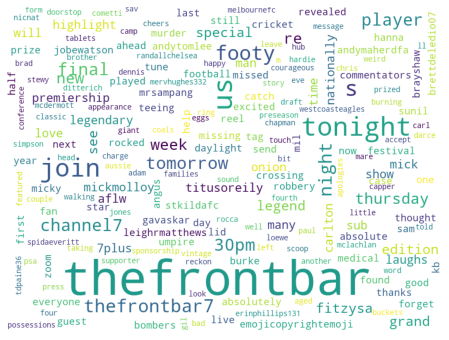

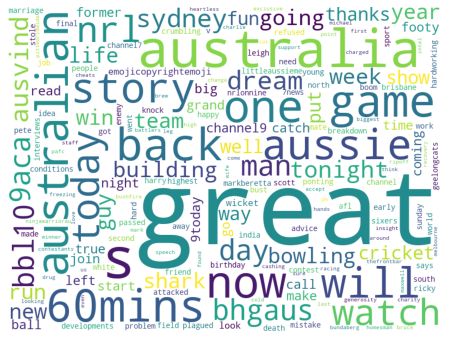

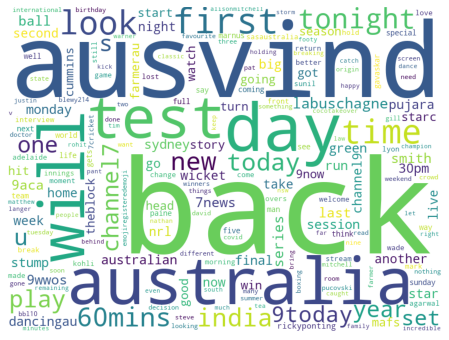

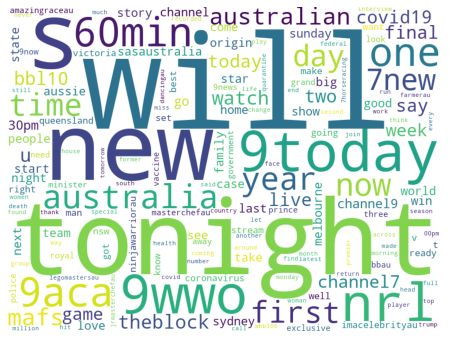

In [82]:
wordclouds_training = CreateWordCloud(indata = tweet_test, text_col_name = 'tweet_text_clean', cluster_col_name = 'cluster')

**Remarks:** based off the television-related domain knowledge obtained in Question 1, there seems to be a handful of discernible "topics" captured by the clusters:



*   **The first cluster broadly captures Australian news-related events.** For example, 7new is the hashtag used for Channel 7 News tweets. 9aca represents A Current Affair on Channel 9, one of the highest-rating and longest-running news and affairs program on television. 60min (Channel Nine's 60 Minutes) is a similar program. 9today is the tag used for Channel Nine's The Today Show, a popular morning news/breakfast show. The keyword covid19 is also found, which is a significant event in the news over the training dataset period. In Question 1, we collected domain knowledge relating to the most highly viewed television shows in Australia. Many of these are found in this cluster, such as 7 News (ranked 2nd most popular) and A Current Affair (ranked 5th most popular). This provides some confirmation that the clustering model is indeed capturing popular Australian news programmes. 
*   **The second cluster appears to be capturing Australian reality TV shows.** For example, 'mafs' is the tag used to refer to Channel 7's Married At First Sight, a popular dating reality show. MasterchefAU is the tag for Channel 10's Masterchef, a reality show where contestants compete by cooking the best food for a panel of judges. The Block is also observed in this list - a reality show focusing on a number of couples renovating their homes. 
*   **The third cluster captures NRL-related tweets.** The NRL keyword here is obvious. 9wwos is the hashtag used to capture tweets relating to Channel Nine's Wide World of Sports, of which NRL is one of their highest rating programs and frequently pulls the highest viewership figures across all networks. Some NRL teams also feature in the word-cloud, such as the (Brisbane) Broncos, (Penrith) Panthers and (Melbourne) Storm. "Origin" also appears, representing State of Origin. In Question 1, we also found that major sporting broadcasts like State of Origin dominate the ratings of all other television programmes when they are live. Rugby-related emojis are also featured.
*   **The fourth cluster captures a lot of cricket-related tweets** (although a number of news-related keywords appear too). For example, BBL10 refers to the 10th season of Big Bash League, a professional men's cricket competition in Australia. WBBL06 is the equivalent cricket league for women. AusVInd is a hashtag that captures tweets relating to cricket matches between Australia and India. There are also numerous keywords such as 'Australia' and 'game' that may relate to cricket. However, some of the keywords in this cluster bear no relation to cricket (e.g. 'theblock') and thus this cluster may be poorly defined.



Therefore, based off our manual validation, it is clear that there are distinct "topics" captured by each cluster, and each cluster relates to news, sports or reality shows broadcasted on free-to-air television. So the clustering output seems reasonable. 

#### **Plotting the top 2 principal components by cluster**

Another visualisation we can use to assist in evaluating the clusters is to chart the clusters by the first two principal components. We select the first two because, by the definition of PCA, they explain the largest proportion of variance in the data. 

Ideally, tweets assigned the same cluster should "group up" together and be distinct from other clusters. 

In [83]:
def PlotClustersByPrincipalComponents(prin_comp1, prin_comp2, cluster_labels):
  '''
  prin_comp1 is a Numpy array containing the values of the first principal component.

  prin_comp2 is a Numpy array containing the values of the second principal component.

  cluster_labels is a Numpy array containing the cluster labels. 
  '''
  num_unique_clusters = len(set(cluster_labels))
  prin_comp_clustered = pd.DataFrame({
      'prin_comp1': prin_comp1,
      'prin_comp2': prin_comp2,
      'cluster': cluster_labels
  })
  prin_comp_plot = sns.scatterplot(x = 'prin_comp1', y = 'prin_comp2', data = prin_comp_clustered, hue = 'cluster')
  print(prin_comp_plot)
  return prin_comp_plot

AxesSubplot(0.125,0.125;0.775x0.755)


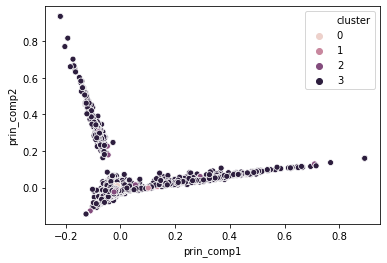

In [84]:
PlotClustersByPrincipalComponents(vec_pca_test[:, 0], vec_pca_test[:, 1], tweet_test['cluster'].ravel())

**Remarks:** Clusters 0, 1 and 2 (news, reality TV and NRL) appear to be quite distinct from each other. The imbalance in the clusters assigned is quite evident, with Cluster 0 permeating through other clusters. Cluster 3 (cricket) is poorly defined and this is evident through both the word-cloud (which contained a mix of cricket, news and other TV-related topics like The Block) and the chart by principal components. 

This result may be expected -- the news, NRL and reality TV-related clusters are quite distinct from each other, and the last 'cluster' simply captures all remaining data points that didn't fall into the previous three topics. 

It is clear from the internal and manual validation above that while three of the clusters are distinct and relate to specific topics, the results of the clustering algorithm can sometimes be unreliable. 



**Assessing the value of these clusters in the context of using tweets to predict share price movements:** 

While our manual validation of the clusters suggests that there are distinct topics captured, these topics are of very little value in predicting share price movements. For example, a cluster relating to news adds no value to predicting the stock-specific movements of Channel 7 and Channel 9. Rather, news and current affairs tweets are more likely to impact the broader Australian market (e.g. a tweet informing readers about a pandemic unfolding would have impacts upon the entire market). 

There may be some value in identifying tweets relating to large sporting events such as NRL and State of Origin. One could argue that this is indicative of strong viewership of these shows, and thus potentially higher advertising revenue, which should be reflected in a share price. 

However, we believe that this is unlikely to be the case due to the nature of advertising contracts. Higher viewership doesn't actually translate to greater revenue or profit unless the television network is actually able to secure advertising contracts with a higher profit margin (and this would only be done the next year, or whenever the contracts are renewed). Therefore, information derived from tweets on sports or TV shows like The Block or Married At First Sight (many of these tweets are simply just discussion amongst fans and celebrities) would not generate any useful insights into the profitability or revenue of Seven or Nine Network. 

As such, we believe that these clusters are not particularly useful in the context of using tweets to predict share price movements. 

Going forward, we will test the value added by including the cluster label as a predictor in the Neural Network and Tree-based model, but if it adds no significant value then we will likely exclude it from the final model. 



---



## **Question 4**

The chosen television network for Question 4 is NEC - **Nine Entertainment**. 

Please find Question 4 (a) above (before Question 3). The reason for presenting the analysis in this order is explained in that section. The reason for selecting NEC as the network of interest is also explained in that section.

### **Variables we've chosen not to use at all in the analysis**
This section is relevant to both Question 4(b) and 4(c), as it covers the reasoning for not using certain variables in the analysis. 

We do not fit models using any of the following variables:


*   Tweet likes
*   User followers
*   User friends
*   User likes
*   User tweets (number of tweets)
*   User public lists

This is because the aforementioned variables are collected as at the date of data extraction, and therefore would not reflect how it would be used in a trading context.

Consider the following hypothetical example. A tweet made in 2019 has accumulated 1 million likes, and in hindsight we can see a large upward impact on the stock price. In theory, it makes sense that the number of likes on a tweet could be a powerful predictor as it captures how many people have viewed (and thus potentially acted upon) that tweet. 

However, **at the time that tweet was posted, it would not have had 1 million likes** - it may have had much fewer. An algorithm that trades as soon as a tweet is posted would NOT have access to information such as the number of likes, because the tweet would have 0 likes when it is first posted. By the time it has accumulated 1 million likes, the stock price may have already jumped sharply, and the time window to make a profitable trade would have closed. 

We also do not include information like username, account name, tweet ID or tweet post time in the model. Tweet post time would not be a useful predictor as new tweets will obviously always have a tweet post time in the future (relative to when the model was trained). Tweet ID would not contain any useful information for predicting share price movements. While username/account name could potentially be predictive if certain individuals are known to be able to move share prices, this would require some a priori knowledge on such individuals.



### **Question 4 (b) - Neural network**
In this section, we fit a neural network to the cleaned/merged Twitter data to predict the movements of NEC and SVW. 


#### **Neural Network fitting - helper functions**

This sub-section contains helper functions used to assist in the data preparation and fitting of neural network models. 

In [85]:
# Define function for plotting the model performance over the epochs
def ModelFitByEpoch(model_hist):
  plt.plot(model_hist.history['accuracy'], color='dodgerblue')
  plt.plot(model_hist.history['val_accuracy'], color='orange')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()

In [86]:
def OHETransform(encoder, vec):
  '''
  OHETransform is a wrapper function to one-hot encode a given vector based using the supplied encoder. 

  encoder is the Encoder to be applied (settings to be supplied there). 

  vec is a Pandas series to be one-hot encoded.
  '''
  vec_1d = vec.values.ravel() # Transform into 1D array for use with the encoder
  encoded_vec = encoder.transform(vec_1d)
  out = keras.utils.to_categorical(encoded_vec)
  return out

#### **Scoring and goodness of fit - helper functions**

The functions in this sub-section are used to help with the scoring and measuring of goodness of fit for both the Neural Network models of this section, and the GBMs in Question 4 (c). 

In [87]:
def ScoreModel(model, indata, model_type = 'nn', encoder = None):
  '''
  The ScoreModel function is a wrapper function to unify the functions for scoring the Neural Network and GBM models fitted as part of this analysis.

  If the model outputs a probability of being assigned to a class, then this function also handles the allocation to a class.

  An observation will be allocated to the class that it has the highest probability of belonging to.

  model is a model object (Keras Neural Network or LightGBM Clasifier) that we are using to score.

  indata is a NumPy ndarray or Pandas DataFrame containing the predictors we want to score. 

  model_type is a string that either takes the value 'nn' or 'gbm', and this should correspond to the type of model supplied under the model parameter. 

  encoder is the object used to encode the response variable, such as a LabelEncoder or OneHotEncoder. This is needed for Neural Network models because the inputs are provided
  to the model as a one-hot encoded array without labels; so the labels must instead be extracted from the encoder. This is not needed for GBMs and can be ignored. 
  '''

  time_score_start = time.time()
  
  if model_type == 'nn':
    prob = model.predict(indata) # Score model
    pred_class_id = np.argmax(prob, axis = 1) # Retrieve the class with the highest probability, across rows
    if encoder is not None:
      num_class = len(encoder.classes_) # If encoder is supplied, get the number of classes
      pred_class_name = np.select([pred_class_id == j for j in range(num_class)], encoder.classes_) # Then assign the class labels - whichever class has the highest probability.
    else:
      print('You have provided a neural network model but not supplied the encoder used to one-hot encode the response variable. Supply the encoder and retry.')
  
  if model_type == 'gbm':
    pred_class_name = model.predict(indata)
  
  time_score_end = time.time()
  print('Time taken to score model: {:.0f} seconds'.format(time_score_end - time_score_start))
  
  return pred_class_name # Return the class labels corresponding to indata

In [88]:
def CalculateFitMetrics(true_values, pred_values, class_order):
  '''
  The CalculateFitMetrics function compiles a number of goodness of fit metrics that are relevant to Multi-Class classification problems.

  The fit metrics calculated are: accuracy score, precision score, recall score, F1 score, confusion matrix. Support is just the exposure, i.e. number of true responses in that class.

  true_values is a Pandas series, NumPy ndarray or list containing the true response values. 

  pred_values is a Pandas series, NumPy ndarray or list containing the predicted response values. 

  class_order is a list containing the names of the classes in the response variable, in the order you want them charted. The confusion matrix will chart them in this order. 
  '''

  metrics_dict = metrics.classification_report(true_values, pred_values, output_dict = True) # This function calculates accuracy, precision, recall, F1 and support
  metrics_df = pd.DataFrame(metrics_dict).transpose() # Transpose to get into a neat format

  conf_mat = metrics.confusion_matrix(true_values, pred_values, labels = class_order) # Generate confusion matrix
  conf_df = pd.DataFrame(data = conf_mat,
                         columns = ['Predicted: ' + j for j in class_order],
                         index = ['Actual: ' + j for j in class_order]) # Turn into DataFrame and assign labels
  print(sns.heatmap(conf_df, annot = True, fmt = 'd', cmap = 'YlGnBu')) # Generate confusion matrix image

  return metrics_df # Output the classification metrics summary

#### **Modelling data preparation**
This sub-section contains the following final data preparation steps to ensure data is in the right format for modelling:



*   Adding other useful fields to the modelling data, like the retweet and URL flags, and the cluster label.
*   Standardisation of the input data, as is necessary for use in Neural Network and GBM models.
*   One-hot encoding of the response variable, where necessary.



In [89]:
def PrepareModellingData(train_x, test_x, train_y, test_y, train_other_predictors, test_other_predictors):
  '''
  This function is designed to prepare both the predictors and response variables for use in the Neural Network and GBM models. The following steps are involved:

  - Concatenating prepared data with any additional predictors of interest provided

  - Normalising and standardising the predictors used
  
  - One-hot encoding the response variables used
  '''
  # Combine input X-values with other predictors
  train_x_comb = pd.concat([pd.DataFrame(train_x).set_index(train_other_predictors.index), train_other_predictors], axis = 1)
  test_x_comb = pd.concat([pd.DataFrame(test_x).set_index(test_other_predictors.index), test_other_predictors], axis = 1)

  # Normalise and standardise X-values
  sc = StandardScaler()
  sc.fit(train_x_comb)
  train_x_comb_sc = sc.transform(train_x_comb)
  test_x_comb_sc = sc.transform(test_x_comb)

  # One-hot encode the Y-values
  enc = LabelEncoder()
  enc.fit(train_y.loc[:, ['NEC_ch_cat']].values.ravel()) # Get the levels of the response variable

  out_train_y = dict()
  out_test_y = dict()

  # Extract response variables as both categorical values and as one-hot encoded arrays
  for j in ['', '1h', '1d']:
    var_name = 'NEC_ch_cat' + j # The naem of teh variable (zero-lagged, one hour-lagged and one day-lagged)
    out_train_y['ch_cat' + j] = train_y.loc[:, var_name] # Extract response variable from train data
    out_train_y['ch_ohe' + j] = OHETransform(enc, train_y.loc[:, var_name]) # And also one-hot encode it
    out_test_y['ch_cat' + j] = test_y.loc[:, var_name] # repeat from test data
    out_test_y['ch_ohe' + j] = OHETransform(enc, test_y.loc[:, var_name])
  
  return train_x_comb_sc, test_x_comb_sc, out_train_y, out_test_y, enc # Output the prepared X and Y values from both the training and testing datasets. Also return the encoder to assist with other steps.

In [90]:
# Initialise various objects to assist with data prep
y_vars = ['NEC_ch_cat', 'NEC_ch_cat1h', 'NEC_ch_cat1d']
other_pred = ['retweet_flag', 'url_flag', 'corporate_flag', 'channel9_flag', 'cluster']
other_pred_no_cl = ['retweet_flag', 'url_flag', 'corporate_flag', 'channel9_flag']
training_x = dict()
testing_x = dict()

# Prepare the principal components data to be used as predictors
training_x['pca'], testing_x['pca'], train_y, test_y, y_enc  = PrepareModellingData(vec_pca_train, vec_pca_test, tweet_train[y_vars], tweet_test[y_vars], tweet_train[other_pred], tweet_test[other_pred])
# and also the TF-IDF matrix (and the y-values)
training_x['tfidf'], testing_x['tfidf'], train_y, test_y, y_enc  = PrepareModellingData(vec_train, vec_test, tweet_train[y_vars], tweet_test[y_vars], tweet_train[other_pred], tweet_test[other_pred])
# and the TF-IDF matrix without the cluster labels
training_x['tfidf_nc'], testing_x['tfidf_nc'], train_y, test_y, y_enc  = PrepareModellingData(vec_train, vec_test, tweet_train[y_vars], tweet_test[y_vars], tweet_train[other_pred_no_cl], tweet_test[other_pred_no_cl])

In [91]:
# Initialise modelling control object. This dict will store the models and their history. 
nn_models = dict()

In [92]:
y_order = ['Increased', 'Stayed same', 'Decreased'] # When we show the confusion matrix, this is the order in which the matrix will be plotted



---


#### **Neural Network iteration 1**

This is intended to be a simple baseline neural network model using the Principal Components.

*   Built on the Principal Components
*   Response variable is the % change in NEC's price with zero lag (i.e. immediate change)
*   2 layers of 80 hidden neurons
*   ReLU activation functions for hidden neurons
*   Softmax activation function at the end (which we use because this is a multi-class classification problem)


In [93]:
def FitNNstr1():
  # Define the model structure
  model = keras.Sequential()
  model.add(keras.layers.Dense(80, activation = 'relu'))
  model.add(keras.layers.Dense(80, activation = 'relu'))
  model.add(keras.layers.Dense(3, activation = 'softmax'))
  # Compile the model
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  return model

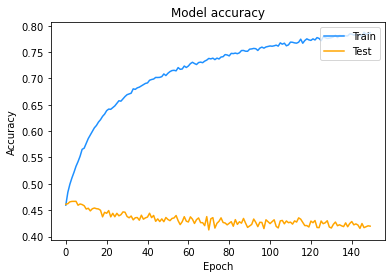

In [94]:
model_vers = 'v1'
nn_models[model_vers] = dict()
nn_models[model_vers]['model'] = FitNNstr1()
nn_models[model_vers]['model_history'] = nn_models[model_vers]['model'].fit(training_x['pca'], train_y['ch_ohe'], validation_data = (testing_x['pca'], test_y['ch_ohe']), epochs = 150, batch_size = 64, verbose = 0, callbacks=[TqdmCallback(verbose=1)])
ModelFitByEpoch(nn_models[model_vers]['model_history'])

Time taken to score model: 0 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.475690,0.527095,0.500075,3174.000000
Increased,0.419592,0.381023,0.399378,2698.000000
Stayed same,0.256027,0.237288,0.246301,1298.000000
accuracy,0.419665,0.419665,0.419665,0.419665
macro avg,0.383769,0.381802,0.381918,7170.000000
weighted avg,0.414814,0.419665,0.416243,7170.000000


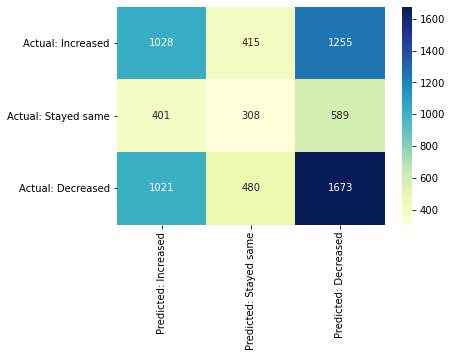

In [95]:
nn_models[model_vers]['y_pred'] = ScoreModel(nn_models[model_vers]['model'], testing_x['pca'], model_type = 'nn', encoder = y_enc) # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat'], nn_models[model_vers]['y_pred'], y_order)

*Commentary on Neural Network version 1:*

The model slowly captures the signal on the training dataset, but appears to plateau off at around 80% training accuracy. Conversely, the accuracy on the testing set has only deteriorated at later epochs. This suggests that some signal is being lost by using the Principal Components as the input features, as the model is not even able to achieve full accuracy on the training set. It is also over-fitting as the testing set accuracy deteriorates. 

Next, we investigate the performance using the TF-IDF features.



---



#### **Neural Network iteration 2**

The training data has been changed to the TF-IDF matrix from the Principal Components between Iteration 1 and Iteration 2. The structure of the neural network is identical to Iteration 1 (so we will use the same function to fit it). 

*   Built on the TF-IDF matrix
*   Response variable is the % change in NEC's price with zero lag (i.e. immediate change)
*   2 layers of 80 hidden neurons
*   ReLU activation functions for hidden neurons
*   Softmax activation function at the end (which we use because this is a multi-class classification problem)


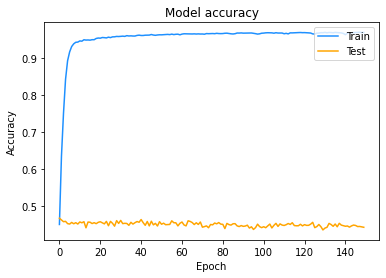

In [96]:
model_vers = 'v2'
nn_models[model_vers] = dict()
nn_models[model_vers]['model'] = FitNNstr1() # We're keeping the Neural Network Structure 1 defined above; only thing we're switching out is the input matrix. 
nn_models[model_vers]['model_history'] = nn_models[model_vers]['model'].fit(training_x['tfidf'], train_y['ch_ohe'], validation_data = (testing_x['tfidf'], test_y['ch_ohe']), epochs = 150, batch_size = 64, verbose = 0, callbacks=[TqdmCallback(verbose=1)])
ModelFitByEpoch(nn_models[model_vers]['model_history'])

Time taken to score model: 0 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.504505,0.546944,0.524868,3174.000000
Increased,0.450501,0.416605,0.432890,2698.000000
Stayed same,0.252026,0.239599,0.245656,1298.000000
accuracy,0.442259,0.442259,0.442259,0.442259
macro avg,0.402344,0.401049,0.401138,7170.000000
weighted avg,0.438477,0.442259,0.439711,7170.000000


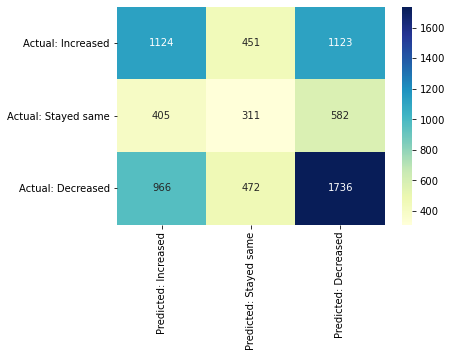

In [97]:
nn_models[model_vers]['y_pred'] = ScoreModel(nn_models[model_vers]['model'], testing_x['tfidf'], model_type = 'nn', encoder = y_enc) # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat'], nn_models[model_vers]['y_pred'], y_order)

*Commentary on Neural Network version 2:*

On the TF-IDF features, the training accuracy approaches 100% very quickly, suggesting that the TF-IDF features are able to fully capture signal in the dataset. However, classification accuracy on the testing set remains stable at around 44%. Despite the larger number of features, it doesn't take a significantly longer amount of time to fit the model on the TF-IDF features. 

Moreover, the precision metric has improved for every class (Increase, Decrease and Stayed same). The precision metric is useful because it captures how frequently a model's predictions were correct (in other words, if it recommends a trade, how often is the trade profitable?) - so improving this statistic is critical. 

Therefore, we will progress with Iteration 2 since:


*   Testing set performance is stronger on the TF-IDF features
*   The neural network is actually able to capture the variation in the training data, whereas some signal was being lost using the Principal Components
*   The fitting time isn't significantly longer

Next, we test removing the cluster variable as a feature.


---


#### **Neural Network iteration 3**

In this iteration, we test how much value the clustering adds to the model by removing it and measuring the decrease in the goodness of fit on the testing set. All other features of the model are identical to Iteration 2. 

*   Built on the TF-IDF matrix (excluding the cluster variable)
*   Response variable is the % change in NEC's price with zero lag (i.e. immediate change)
*   2 layers of 80 hidden neurons
*   ReLU activation functions for hidden neurons
*   Softmax activation function at the end (which we use because this is a multi-class classification problem)


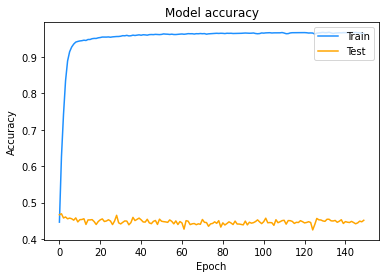

In [98]:
model_vers = 'v3'
nn_models[model_vers] = dict()
nn_models[model_vers]['model'] = FitNNstr1() # We're keeping the Neural Network Structure 1 defined above; only thing we're switching out is the input matrix. 
nn_models[model_vers]['model_history'] = nn_models[model_vers]['model'].fit(training_x['tfidf_nc'], train_y['ch_ohe'], validation_data = (testing_x['tfidf_nc'], test_y['ch_ohe']), epochs = 150, batch_size = 64, verbose = 0, callbacks=[TqdmCallback(verbose=1)])
ModelFitByEpoch(nn_models[model_vers]['model_history'])

Time taken to score model: 0 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.509742,0.560491,0.533914,3174.000000
Increased,0.452136,0.423647,0.437428,2698.000000
Stayed same,0.273438,0.242681,0.257143,1298.000000
accuracy,0.451464,0.451464,0.451464,0.451464
macro avg,0.411772,0.408940,0.409495,7170.000000
weighted avg,0.445287,0.451464,0.447503,7170.000000


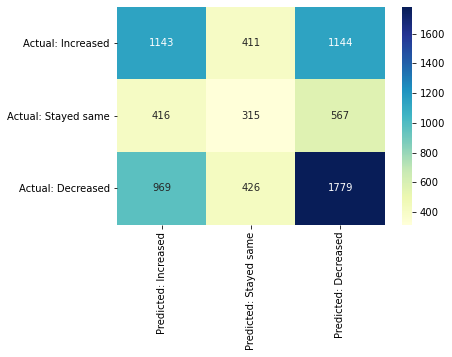

In [99]:
nn_models[model_vers]['y_pred'] = ScoreModel(nn_models[model_vers]['model'], testing_x['tfidf_nc'], model_type = 'nn', encoder = y_enc) # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat'], nn_models[model_vers]['y_pred'], y_order)

*Commentary on Neural Network version 3:*

The model in fact performs better on the testing set after removing the cluster label as a feature. Because the clusters don't make too much sense in the context of predicting a share price movement, it is likely that the cluster labels were simply adding noise to the model. The neural network was fitting to clusters that didn't encode any useful information in the context of predicting share price movements. 

Going forward, we will build models without the cluster variable.




---


#### **Neural Network iteration 4**

Next, we investigate changing the response variable used in the model. The previous iterations have used the "lag-zero" response, i.e. the change in stock price immediately after a tweet. 

We now investigate how the model performs when predicting stock price movements well after a tweet. In Iteration 4, we instead change the response variable to the % change in price **1 hour after** a given tweet. This allows us to incorporate the theory that other (human) traders may take a while to recognise and act upon a tweet.

The structure of the neural network itself is the same.

*   Built on the TF-IDF features (without the cluster variable)
*   Response variable is the % change in NEC's price 1 hour after a tweet
*   2 layers of 80 hidden neurons
*   ReLU activation functions for hidden neurons
*   Softmax activation function at the end (which we use because this is a multi-class classification problem)


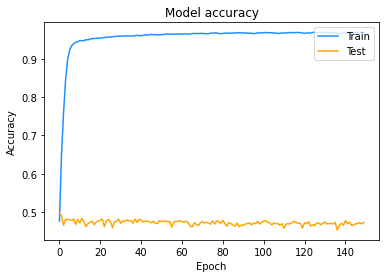

In [100]:
model_vers = 'v4'
nn_models[model_vers] = dict()
nn_models[model_vers]['model'] = FitNNstr1() # We're keeping the Neural Network Structure 1 defined above; only thing we're switching out is the response variable. 
nn_models[model_vers]['model_history'] = nn_models[model_vers]['model'].fit(training_x['tfidf_nc'], train_y['ch_ohe1h'], validation_data = (testing_x['tfidf_nc'], test_y['ch_ohe1h']), epochs = 150, batch_size = 64, verbose = 0, callbacks=[TqdmCallback(verbose=1)])
ModelFitByEpoch(nn_models[model_vers]['model_history'])

Time taken to score model: 0 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.527412,0.584625,0.554547,3291.000000
Increased,0.468271,0.447855,0.457836,2867.000000
Stayed same,0.233333,0.179842,0.203125,1012.000000
accuracy,0.472803,0.472803,0.472803,0.472803
macro avg,0.409672,0.404107,0.405169,7170.000000
weighted avg,0.462257,0.472803,0.466275,7170.000000


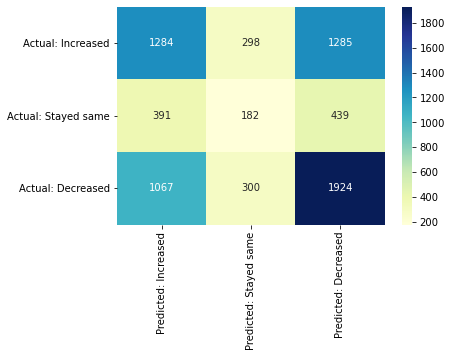

In [101]:
nn_models[model_vers]['y_pred'] = ScoreModel(nn_models[model_vers]['model'], testing_x['tfidf_nc'], model_type = 'nn', encoder = y_enc) # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat1h'], nn_models[model_vers]['y_pred'], y_order)

*Commentary on Neural Network version 4:*

The model has superior performance when trained on the 1 hour-lagged response variable (i.e. the change in price 1 hour after a tweet). The classification accuracy has improved markedly, and the precision on both the Increase and Decrease classes has also improved substantially. 

This may be a result of the 1-hour lagged share price movements being less noisy (since they are "averaged" over a longer time period). Less noise allows the model to capture signal more effectively.

We now investigate the performance when trained on the 1 day-lagged response variable.

---



#### **Neural Network iteration 5**

In Iteration 5, we change the response variable to the % change in stock price **1 day** after a tweet. This allows us to incorporate the theory that stock prices may take much longer to move. A reason for this is that the largest volumes of money come from overseas investors such as American investment funds. ASX market hours may be outside of business hours for many of these investment funds. 

The structure of the neural network itself is the same.

*   Built on the Principal Components
*   Response variable is the % change in NEC's price 1 day after a tweet
*   2 layers of 80 hidden neurons
*   ReLU activation functions for hidden neurons
*   Softmax activation function at the end (which we use because this is a multi-class classification problem)


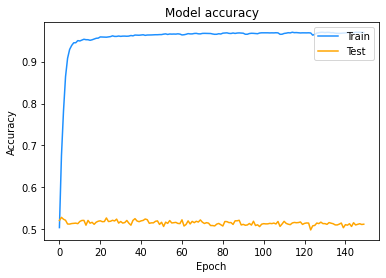

In [102]:
model_vers = 'v5'
nn_models[model_vers] = dict()
nn_models[model_vers]['model'] = FitNNstr1() # We're keeping the Neural Network Structure 1 defined above; only thing we're switching out is the response variable. 
nn_models[model_vers]['model_history'] = nn_models[model_vers]['model'].fit(training_x['tfidf_nc'], train_y['ch_ohe1d'], validation_data = (testing_x['tfidf_nc'], test_y['ch_ohe1d']), epochs = 150, batch_size = 64, verbose = 0, callbacks=[TqdmCallback(verbose=1)])
ModelFitByEpoch(nn_models[model_vers]['model_history'])

Time taken to score model: 1 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.547685,0.563235,0.555351,3487.000000
Increased,0.504827,0.518388,0.511518,3127.000000
Stayed same,0.227882,0.152878,0.182992,556.000000
accuracy,0.511855,0.511855,0.511855,0.511855
macro avg,0.426798,0.411500,0.416621,7170.000000
weighted avg,0.504195,0.511855,0.507360,7170.000000


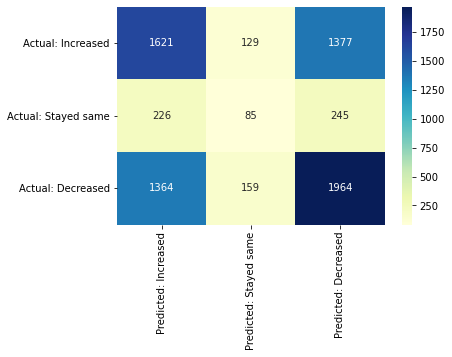

In [103]:
nn_models[model_vers]['y_pred'] = ScoreModel(nn_models[model_vers]['model'], testing_x['tfidf_nc'], model_type = 'nn', encoder = y_enc) # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat1d'], nn_models[model_vers]['y_pred'], y_order)

*Commentary on Neural Network version 5:*

There is a marked increase in the test set accuracy between Iterations 4 and 5. This suggests that making use of the % change in stock price 1 day after a tweet may be a more appropriate response variable. There are numerous reasons for this:

*   Price movements over a 1 day period are typically more stable than price movements over a 10 minute or 1 hour interval. This reduces the amount of noise in the response variable and allows the model to perform better. 
*   Information contained in a tweet may not be reflected in the price within 10 minutes, unless there is significant presence from algorithmic traders on the market. Over a 1 day period, it is more likely that human traders will catch wind of any valuable news contained in a tweet, and be able to act accordingly. 

There is also a large increase in the precision for both the Increase and Decrease classes, which is extremely important in ensuring trades recommended by the model are profitable.



We now consider the impact of changes to the architecture of the model.

---



#### **Neural Network iteration 6**

In Iteration 6, we change the architecture of the model, while retaining use of the 1-day % change in price. Iteration 6 includes an additional layer with 40 neurons. This allows us to test if incorporating additional complexity into the model structure could allow it to better capture signal (e.g. more complex interactions). 

*   Built on the TF-IDF features
*   Response variable is the % change in NEC's price 1 day after a tweet
*   3 layers in total. 2 layers of 80 hidden neurons and 1 layer of 40 hidden neurons. 
*   ReLU activation functions for hidden neurons
*   Softmax activation function at the end (which we use because this is a multi-class classification problem)


In [104]:
def FitNNstr2():
  # Define the model structure
  model = keras.Sequential()
  model.add(keras.layers.Dense(80, activation = 'relu'))
  model.add(keras.layers.Dense(80, activation = 'relu'))
  model.add(keras.layers.Dense(40, activation = 'relu'))
  model.add(keras.layers.Dense(3, activation = 'softmax'))
  # Compile the model
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  return model

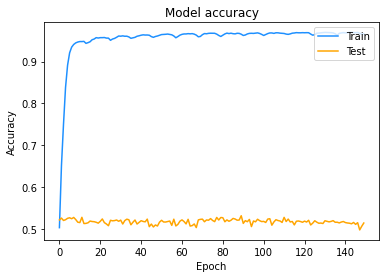

In [105]:
model_vers = 'v6'
nn_models[model_vers] = dict()
nn_models[model_vers]['model'] = FitNNstr2() 
nn_models[model_vers]['model_history'] = nn_models[model_vers]['model'].fit(training_x['tfidf_nc'], train_y['ch_ohe1d'], validation_data = (testing_x['tfidf_nc'], test_y['ch_ohe1d']), epochs = 150, batch_size = 64, verbose = 0, callbacks=[TqdmCallback(verbose=1)])
ModelFitByEpoch(nn_models[model_vers]['model_history'])

Time taken to score model: 1 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.545581,0.561227,0.553294,3487.000000
Increased,0.510407,0.525424,0.517806,3127.000000
Stayed same,0.233516,0.152878,0.184783,556.000000
accuracy,0.513947,0.513947,0.513947,0.513947
macro avg,0.429835,0.413176,0.418628,7170.000000
weighted avg,0.506042,0.513947,0.509241,7170.000000


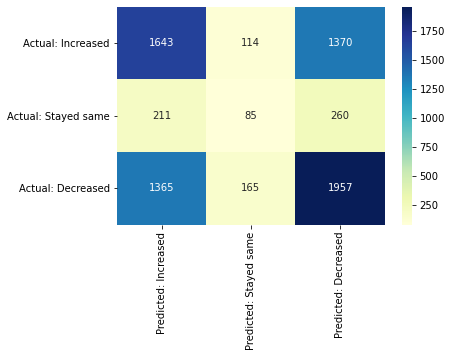

In [106]:
nn_models[model_vers]['y_pred'] = ScoreModel(nn_models[model_vers]['model'], testing_x['tfidf_nc'], model_type = 'nn', encoder = y_enc) # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat1d'], nn_models[model_vers]['y_pred'], y_order)

*Commentary on Neural Network version 6:*

Adding additional complexity to the model has caused a deterioriation in model performance. This is to be expected as greater levels of complexity often cause over-fitting of the model. 

---



#### **Neural Network iteration 7**

Between Iteration 6 and Iteration 7, the only difference is that we instead use only 1 hidden layer of 80 neurons. That is, we are testing lower levels of model complexity, in case Iteration 5 happens to be over-fitting the data. 

*   Built on the Principal Components
*   Response variable is the % change in NEC's price 1 day after a tweet
*   1 layer of 80 hidden neurons
*   ReLU activation functions for hidden neurons
*   Softmax activation function at the end (which we use because this is a multi-class classification problem)


In [107]:
def FitNNstr3():
  # Define the model structure
  model = keras.Sequential()
  model.add(keras.layers.Dense(80, activation = 'relu'))
  model.add(keras.layers.Dense(3, activation = 'softmax'))
  # Compile the model
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  return model

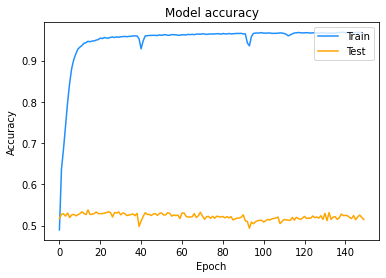

In [108]:
model_vers = 'v7'
nn_models[model_vers] = dict()
nn_models[model_vers]['model'] = FitNNstr3() # We're keeping the Neural Network Structure 1 defined above; only thing we're switching out is the response variable. 
nn_models[model_vers]['model_history'] = nn_models[model_vers]['model'].fit(training_x['tfidf_nc'], train_y['ch_ohe1d'], validation_data = (testing_x['tfidf_nc'], test_y['ch_ohe1d']), epochs = 150, batch_size = 64, verbose = 0, callbacks=[TqdmCallback(verbose=1)])
ModelFitByEpoch(nn_models[model_vers]['model_history'])

Time taken to score model: 1 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.543574,0.640379,0.588018,3487.000000
Increased,0.523136,0.437480,0.476489,3127.000000
Stayed same,0.199105,0.160072,0.177468,556.000000
accuracy,0.514644,0.514644,0.514644,0.514644
macro avg,0.421938,0.412644,0.413992,7170.000000
weighted avg,0.507948,0.514644,0.507542,7170.000000


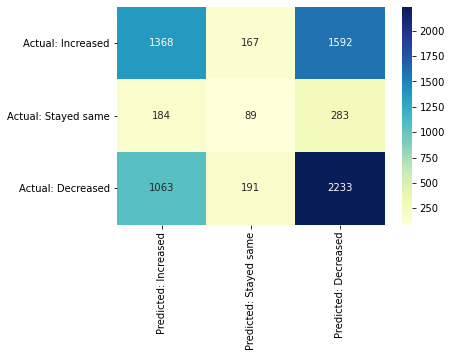

In [109]:
nn_models[model_vers]['y_pred'] = ScoreModel(nn_models[model_vers]['model'], testing_x['tfidf_nc'], model_type = 'nn', encoder = y_enc) # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat1d'], nn_models[model_vers]['y_pred'], y_order)

*Commentary on Neural Network version 7:*

Interestingly, the model has slightly poorer performance (both classification accuracy and the precision on Increase and Decrease classes) with lower levels of complexity (1 layer only) as well. This could be a result of the 1-layer model not being able to fully capture signal in the data; alternatively, it could just be noise or random variation (especially since the performance loss is so small). 

The 2-layer model (i.e. Iteration 5) performed best. We will progress with this model, and next experiment with changes to the number of neurons within each layer.

---



#### **Neural Network iteration 8**

We continue using the structure with 2 hidden layers, but now consider a different number of neurons. In Iteration 8, we test the use of 2 layers of 120 neurons. 

*   Built on the Principal Components
*   Response variable is the % change in NEC's price 1 day after a tweet
*   2 layers of 120 hidden neurons
*   ReLU activation functions for hidden neurons
*   Softmax activation function at the end (which we use because this is a multi-class classification problem)


In [110]:
def FitNNstr4():
  # Define the model structure
  model = keras.Sequential()
  model.add(keras.layers.Dense(120, activation = 'relu'))
  model.add(keras.layers.Dense(120, activation = 'relu'))
  model.add(keras.layers.Dense(3, activation = 'softmax'))
  # Compile the model
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  return model

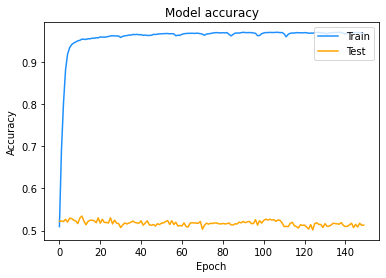

In [111]:
model_vers = 'v8'
nn_models[model_vers] = dict()
nn_models[model_vers]['model'] = FitNNstr4() # We're keeping the Neural Network Structure 1 defined above; only thing we're switching out is the response variable. 
nn_models[model_vers]['model_history'] = nn_models[model_vers]['model'].fit(training_x['tfidf_nc'], train_y['ch_ohe1d'], validation_data = (testing_x['tfidf_nc'], test_y['ch_ohe1d']), epochs = 150, batch_size = 64, verbose = 0, callbacks=[TqdmCallback(verbose=1)])
ModelFitByEpoch(nn_models[model_vers]['model_history'])

Time taken to score model: 0 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.556322,0.555205,0.555763,3487.00000
Increased,0.505835,0.526703,0.516058,3127.00000
Stayed same,0.223502,0.174460,0.195960,556.00000
accuracy,0.513250,0.513250,0.513250,0.51325
macro avg,0.428553,0.418789,0.422594,7170.00000
weighted avg,0.508495,0.513250,0.510546,7170.00000


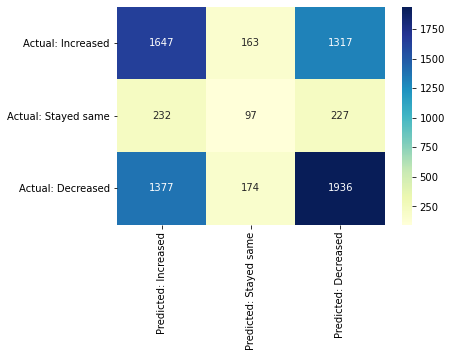

In [112]:
nn_models[model_vers]['y_pred'] = ScoreModel(nn_models[model_vers]['model'], testing_x['tfidf_nc'], model_type = 'nn', encoder = y_enc) # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat1d'], nn_models[model_vers]['y_pred'], y_order)

*Commentary on Neural Network version 8:*

Increasing the complexity in the neural network model (through more neurons) has resulted in negligible change to the model. We next experiment with fewer neurons. 

---



#### **Neural Network iteration 9**

Given that the reduced complexity in Iteration 8 appears to have little impact on testing set accuracy, we now experiment with a further reduction in complexity. Iteration 9 now has 2 layers of 50 neurons. 

*   Built on the Principal Components
*   Response variable is the % change in NEC's price 1 day after a tweet
*   2 layers of 50 hidden neurons
*   ReLU activation functions for hidden neurons
*   Softmax activation function at the end (which we use because this is a multi-class classification problem)


In [113]:
def FitNNstr5():
  # Define the model structure
  model = keras.Sequential()
  model.add(keras.layers.Dense(50, activation = 'relu'))
  model.add(keras.layers.Dense(50, activation = 'relu'))
  model.add(keras.layers.Dense(3, activation = 'softmax'))
  # Compile the model
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  return model

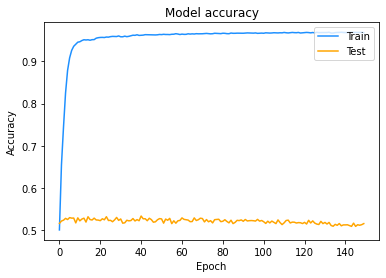

In [114]:
model_vers = 'v9'
nn_models[model_vers] = dict()
nn_models[model_vers]['model'] = FitNNstr5() # We're keeping the Neural Network Structure 1 defined above; only thing we're switching out is the response variable. 
nn_models[model_vers]['model_history'] = nn_models[model_vers]['model'].fit(training_x['tfidf_nc'], train_y['ch_ohe1d'], validation_data = (testing_x['tfidf_nc'], test_y['ch_ohe1d']), epochs = 150, batch_size = 64, verbose = 0, callbacks=[TqdmCallback(verbose=1)])
ModelFitByEpoch(nn_models[model_vers]['model_history'])

Time taken to score model: 0 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.555212,0.566676,0.560886,3487.000000
Increased,0.508848,0.524145,0.516383,3127.000000
Stayed same,0.207692,0.145683,0.171247,556.000000
accuracy,0.515481,0.515481,0.515481,0.515481
macro avg,0.423918,0.412168,0.416172,7170.000000
weighted avg,0.508043,0.515481,0.511262,7170.000000


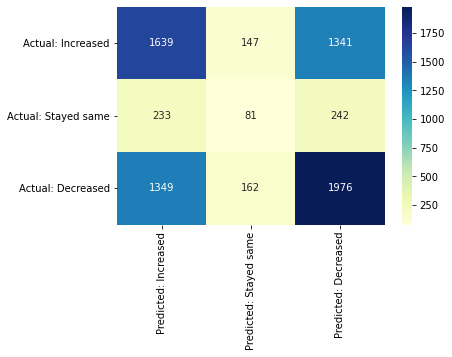

In [115]:
nn_models[model_vers]['y_pred'] = ScoreModel(nn_models[model_vers]['model'], testing_x['tfidf_nc'], model_type = 'nn', encoder = y_enc) # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat1d'], nn_models[model_vers]['y_pred'], y_order)

*Commentary on Neural Network version 9:*

The model performance has deteriorated with fewer neurons. The classification accuracy, precision on the increase class and on the decrease class have each fallen by about 1%. The recall has also dropped, suggesting that this model performs more poorly in capturing profitable trading opportunities when they arise. Overall, this model seems inferior; perhaps 2 layers of 50 neurons is not enough to capture the variability in the data. 

Iteration 5 continues to perform the best, so we will continue with this.


---



#### **Neural Network iteration 10**

In Iteration 10, we experiment with changing the activation function used for the hidden layers. Note that it is [generally rare for neural networks to have different activation functions across its hidden layers](https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/). We also do not test changing the output layer's activation function, because softmax is an ideal activation function for a classification problem like this. 

For this iteration, we will choose to use a sigmoid activation function, instead of ReLU. 

*   Built on the Principal Components
*   Response variable is the % change in NEC's price 1 day after a tweet
*   2 hidden layers of 80 neurons
*   Sigmoid activation functions for hidden neurons
*   Softmax activation function at the end (which we use because this is a multi-class classification problem)


In [116]:
def FitNNstr6():
  # Define the model structure
  model = keras.Sequential()
  model.add(keras.layers.Dense(80, activation = 'sigmoid'))
  model.add(keras.layers.Dense(80, activation = 'sigmoid'))
  model.add(keras.layers.Dense(3, activation = 'softmax'))
  # Compile the model
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  return model

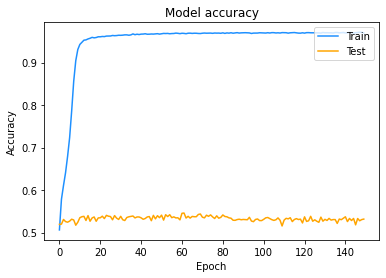

In [117]:
model_vers = 'v10'
nn_models[model_vers] = dict()
nn_models[model_vers]['model'] = FitNNstr6() # We're keeping the Neural Network Structure 1 defined above; only thing we're switching out is the response variable. 
nn_models[model_vers]['model_history'] = nn_models[model_vers]['model'].fit(training_x['tfidf_nc'], train_y['ch_ohe1d'], validation_data = (testing_x['tfidf_nc'], test_y['ch_ohe1d']), epochs = 150, batch_size = 64, verbose = 0, callbacks=[TqdmCallback(verbose=1)])
ModelFitByEpoch(nn_models[model_vers]['model_history'])

Time taken to score model: 0 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.558053,0.605105,0.580627,3487.00000
Increased,0.523733,0.522226,0.522978,3127.00000
Stayed same,0.254613,0.124101,0.166868,556.00000
accuracy,0.531660,0.531660,0.531660,0.53166
macro avg,0.445466,0.417144,0.423491,7170.00000
weighted avg,0.519555,0.531660,0.523400,7170.00000


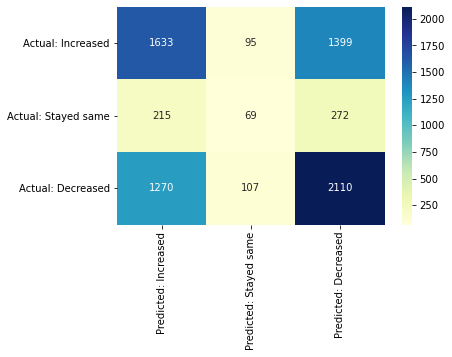

In [118]:
nn_models[model_vers]['y_pred'] = ScoreModel(nn_models[model_vers]['model'], testing_x['tfidf_nc'], model_type = 'nn', encoder = y_enc) # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat1d'], nn_models[model_vers]['y_pred'], y_order)

*Commentary on Neural Network version 10:*

It is worth noting that the sigmoid activation function is often considered an inferior choice compared to ReLU (which is the modern standard). This is because they suffer from the 'vanishing gradient' problem, which happens when the gradient of the loss function approaches zero after adding too many hidden layers to the network. 

Given that all the neural networks we have experimented with have been shallow, and that [some sources suggest sigmoid functions can perform better in classification problems](https://www.analyticsvidhya.com/blog/2020/01/fundamentals-deep-learning-activation-functions-when-to-use-them/), we have chosen to investigate the use of sigmoid activation anyway.

Iteration 10's classification accuracy and precision on all three classes has improved markedly. The recall on the Increase class has fallen by about 2% from Iteration 5 suggesting that Iteration 10 is poorer at correctly predicting share price increases when they occur. However, the recall on the Decrease class has improved a lot. Overall, Iteration 10 seems superior to all prior iterations, so we will progress with that.


---



#### **Neural Network iteration 11**

In Iteration 11, we again experiment with a different activation function. Here, we will run the model using a hyperbolic tangent activation function, which is frequently used and behaves similarly to the sigmoid activation function.

*   Built on the Principal Components
*   Response variable is the % change in NEC's price 1 day after a tweet
*   2 hidden layers of 80 neurons
*   Sigmoid activation functions for hidden neurons
*   Tanh activation function at the end (which we use because this is a multi-class classification problem)


In [119]:
def FitNNstr7():
  # Define the model structure
  model = keras.Sequential()
  model.add(keras.layers.Dense(80, activation = 'tanh'))
  model.add(keras.layers.Dense(80, activation = 'tanh'))
  model.add(keras.layers.Dense(3, activation = 'softmax'))
  # Compile the model
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  return model

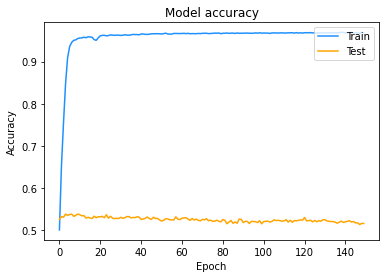

In [120]:
model_vers = 'v11'
nn_models[model_vers] = dict()
nn_models[model_vers]['model'] = FitNNstr7() # We're keeping the Neural Network Structure 1 defined above; only thing we're switching out is the response variable. 
nn_models[model_vers]['model_history'] = nn_models[model_vers]['model'].fit(training_x['tfidf_nc'], train_y['ch_ohe1d'], validation_data = (testing_x['tfidf_nc'], test_y['ch_ohe1d']), epochs = 150, batch_size = 64, verbose = 0, callbacks=[TqdmCallback(verbose=1)])
ModelFitByEpoch(nn_models[model_vers]['model_history'])

Time taken to score model: 1 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.562014,0.560080,0.561046,3487.000000
Increased,0.513211,0.527982,0.520492,3127.000000
Stayed same,0.184100,0.158273,0.170213,556.000000
accuracy,0.514923,0.514923,0.514923,0.514923
macro avg,0.419775,0.415445,0.417250,7170.000000
weighted avg,0.511425,0.514923,0.513052,7170.000000


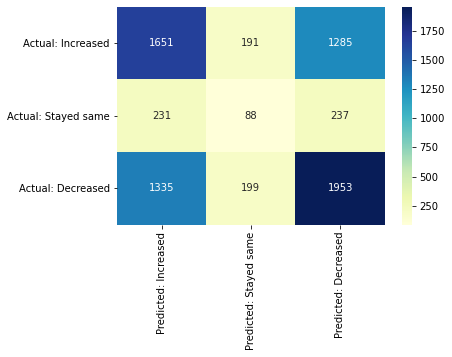

In [121]:
nn_models[model_vers]['y_pred'] = ScoreModel(nn_models[model_vers]['model'], testing_x['tfidf_nc'], model_type = 'nn', encoder = y_enc) # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat1d'], nn_models[model_vers]['y_pred'], y_order)

*Commentary on Neural Network version 11:*

The tanh activation function is generally considered inferior for similar reasons to the sigmoid function (i.e. it suffers from the vanishing gradient problem). This iteration appears to have performed more poorly than both Iteration 5 (identical but using ReLU activation) and Iteration 10 (identical but using Sigmoid activation). So we will progress with Iteration 10.

---



#### **Final Neural Network selection**

Iteration 10 will be the final neural network model selected. We summarise the model and **justify the selections** here.

*   The predictors used are the TF-IDF vectors. We use these as predictors because: 1) The principal components were only able to explain 23% of the variation in the data, as shown in Question 3(b)ii., which means a lot of potential signal will be missed. 2) The model had superior performance on the testing set when fitted on the TF-IDF features compared to the Principal Components, and 3) Model fit time is not significantly higher on the TF-IDF features, so there are no run-time or memory-related issues.
*   The response variable used is the change in NEC's stock price 1 day after a tweet. We use this because the model performance significantly improves when predicting the price movement 1 day after a tweet, suggesting there is less noise over longer time frames. In the context of trading, this is equivalent to purchasing the share on a tweet, holding it for a day and then selling. 
*   The model architecture is 1 hidden layer of 100 neurons. We choose a shallow structure because there is a significant amount of noise in the data, so less complex, shallower models help to reduce over-fitting. 
*   The activation function for the hidden layer is Sigmoid. The main drawback of sigmoid functions (the vanishing gradient problem, as explained in Iteration 9) is not a significant problem for a shallow model like this, and [sources suggest that sigmoid activation can perform better for classification problems](https://www.analyticsvidhya.com/blog/2020/01/fundamentals-deep-learning-activation-functions-when-to-use-them/). 
*   This is followed by an output layer of 3 neurons using the Softmax activation function. Softmax is the standard output activation function for a classification problem because it returns the probabilities of each class. 3 neurons are used because there are 3 classes for the output - that the share price 'Increased', 'Stayed same' and 'Decreased'. 
*   We use a batch size of 64 (meaning that 64 rows are propagated through the neural network as part of the gradient descent algorithm). According to [Keskar et al.](https://arxiv.org/abs/1609.04836), smaller batch sizes (between 32 and 512 data points) are standard, and that larger batch sizes can often result in significant degradation in the model performance, as well as potentially causing memory issues due to using too large a batch.
*    We train over 150 epochs. We select this because the model is able to fully capture the variation in the training set by then. We can then cut off the training earlier if we observe over-fitting occurring (via a decrease in the test set performance).



#### **Checks on the final neural network model**
In this section, we perform numerous checks on the results of the final neural network model. These include both simple sense checks as well as more detailed actual vs expected charts to identify if the model captures variation in the data adequately.

**Check 1: ensure predicted probabilities add up to 100%**

In [122]:
test_set_pred = nn_models['v10']['model'].predict(testing_x['tfidf_nc'])
pd.DataFrame(test_set_pred.sum(axis = 1)).describe()

,0
count,7.170000e+03
mean,1.000000e+00
std,5.686448e-08
min,9.999998e-01
25%,9.999999e-01
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


Values range from 0.9999998 (which is likely just a floating point/precision error) to 1, meaning that the probabilities do indeed sum up to 100%. The predictions are behaving as expected.

**Check 2: ensure only three classes can be predicted by the model**

In [123]:
test_set_pred.shape[1]

3

The model predicts the probability of each class occurring, with each column representing a different class. There are only 3 columns in the predicted output, meaning it can only yield 3 different classes (Increase/Stayed same/Decrease), as expected.

**Check 3: Actual vs Expected plot by corporate flag**

First, we construct the function to create Actual vs Expected charts. These charts are useful in diagnosing potential misfits in the model, which we can recognise when the expected line deviates significantly from the actual line.

In [124]:
def AvsE(indata, actual, pred, by_var, plot_class, return_data = False):
  '''
  This function plots the actual vs expected proportions by the given variable. 

  indata is the Pandas DataFrame containing the data used. 

  actual is a string containing the name of the 'Actual' column.

  pred is a string containing the name of the 'Predicted' column.

  by_var is a string containing the name of the variable to calculate the Actual vs Expected by.
  
  plot_class is a string containing the class to plot (e.g. 'Increased').

  return_data is True if you want to output the data used to create the chart, and False by default. 
  '''
  actual_prop = pd.crosstab(indata[by_var], indata[actual])
  actual_prop['total'] = actual_prop.sum(axis = 1)
  actual_prop['inc_prop'] = actual_prop[plot_class] / actual_prop['total']

  pred_prop = pd.crosstab(indata[by_var], indata[pred])
  pred_prop['total'] = pred_prop.sum(axis = 1)
  pred_prop['inc_prop'] = pred_prop[plot_class] / pred_prop['total']

  expos = indata[by_var].value_counts()

  # Generate the Actual vs Expected chart
  plt.bar(x = expos.index, height = expos.values, color = 'lightgray')
  plt.ylabel('Exposure')
  plt.xlabel(by_var)
  axes2 = plt.twinx()
  axes2.plot(actual_prop.index, actual_prop['inc_prop'])
  axes2.plot(pred_prop.index, pred_prop['inc_prop'])
  axes2.set_ylim(0, 1)
  axes2.set_ylabel('Actual/predicted proportion')
  plt.title('Actual vs Expected proportion by ' + by_var)
  plt.legend(['Actual', 'Predicted'])
  plt.show()

  if return_data:
    return actual_prop, pred_prop, expos

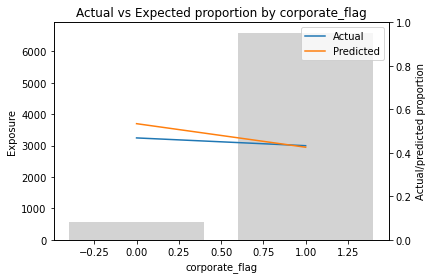

In [125]:
tweet_test['nn_pred'] = nn_models['v10']['y_pred']
AvsE(tweet_test, actual = 'NEC_ch_cat1d', pred = 'nn_pred', by_var = 'corporate_flag', plot_class = 'Increased')

The corporate flag signifies when a tweet was made by a corporate account (1) or a celebrity (0), which is worth investigating because the fund manager hypothesised a 'strong relationship between television networks and **celebrities** who frequently post to Twitter'. 

We can see that on the testing set, the model is able to capture any signal generated by celebrities appropriately, since the orange line is very close to the blue line (particularly on the Increase class - i.e. when stock prices increase). 

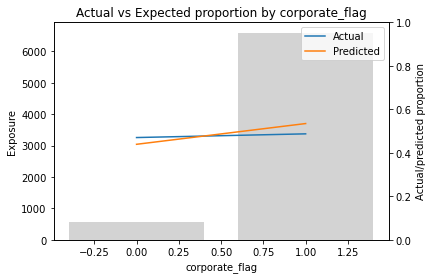

In [126]:
AvsE(tweet_test, actual = 'NEC_ch_cat1d', pred = 'nn_pred', by_var = 'corporate_flag', plot_class = 'Decreased')

We see a slight misfit when predicting stock price Decreases using the corporate flag. 

**Check 4: Actual vs Expected plot by cluster**

Another check worth performing is to see if removing the cluster label from the list of predictors was the correct decision. We can achieve this by using an Actual vs Expected chart by the cluster label. 

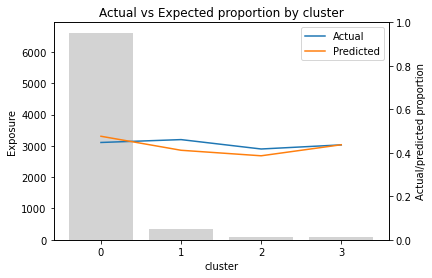

In [127]:
# A vs E when the stock price Increases
AvsE(tweet_test, actual = 'NEC_ch_cat1d', pred = 'nn_pred', by_var = 'cluster', plot_class = 'Increased')

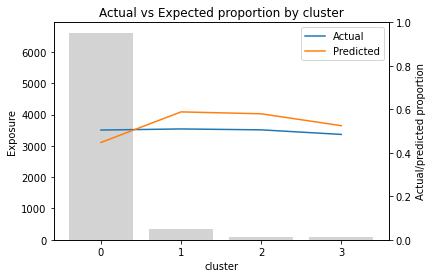

In [128]:
# A vs E when the stock price Decreases
AvsE(tweet_test, actual = 'NEC_ch_cat1d', pred = 'nn_pred', by_var = 'cluster', plot_class = 'Decreased')

Despite the final neural network model not including the cluster label as a predictor, the Predicted line matches quite closely to the Actual line in the top chart (on the Increase class). This suggests that whatever information was encoded by the clusters was captured by other predictors anyway. There is a slight misfit on the Decrease class, but it is not particularly large. 

From the checks performed, we are satisfied that the neural network both passes simple sense checks and produces reasonable results by capturing the variability in the data.


---



### **Question 4 (c) - Tree-based model**
In this section, we fit a gradient boosting machine model using the LightGBM package to predict whether a share price increased, decreased or stayed the same.


#### **GBM Modelling functions**

In this section, we construct a number of helper functions to fit the GBM and extract useful diagnostics. These functions will be applied in the sections afterwards to construct various iterations of the model.

In [129]:
def PlotFeatureImportance(model, wn_num = None):
  '''
  PlotFeatureImportance is a wrapper function to extract the feature importance metrics from the GBM, tabulate and chart them.

  model is the LightGBM model object that we want to extract feature importances from.

  wn_num is an integer identifying the column number that contains the white noise column (for performing the white noise test). If no such column exists, then this can be ignored. 
  '''
  # Firstly, create the feature importance table
  importance_table = pd.DataFrame({'importance': model.feature_importances_}) # Extract importance from model object
  importance_table['feature_number'] = np.arange(len(importance_table)) # Assign the number of the feature
  importance_table.sort_values(by = 'importance', inplace = True, ascending = False) # Sort by impotrance
  importance_table['importance_rank'] = np.arange(len(importance_table)) # Assign the rank of that variable, by importance
  importance_table['importance_sc'] = importance_table['importance'] / np.sum(importance_table['importance']) # Scale the importances so they add to 100%.
  # This makes it easier to interpret the feature importance metrics on a relative scale.

  # Now, chart the importances as a line chart. 
  plt.plot(importance_table['importance_rank'], importance_table['importance_sc']) # Plot scaled importance in order from most to least important
  if wn_num is not None:
    wn_imp = importance_table.loc[importance_table['feature_number'] == wn_num, 'importance_sc'].values[0]
    plt.axhline(y = wn_imp, color = 'r', linestyle = 'dashed')
    plt.legend(['Scaled importance', 'Importance of white noise'], loc='upper right')
  plt.title('Scaled importance of all features, from highest to lowest')
  plt.ylabel('Scaled importance (adds to 100%)')
  plt.xlabel('Importance rank')
  plt.show()

  return importance_table # Output the table for the user 

In [130]:
def PlotFitByRound(model):
  '''
  This function charts the fit metrics of the model (multi-classification error and multi-classification log-loss, for the probabilities of each class) by epoch. 

  model is a LGBMClassifier model object, from Microsoft's LightGBM package. 
  '''
  # Prepare a DataFrame to summarise the output
  fit_by_epoch = pd.DataFrame({
      'multi_error' : model.evals_result_['valid_0']['multi_error'],
      'multi_logloss' : model.evals_result_['valid_0']['multi_logloss']
  })
  fit_by_epoch['epoch'] = np.arange(len(fit_by_epoch))

  # Chart the multi-classification error and multi-classification log-loss together
  plt.plot(model.evals_result_['valid_0']['multi_error'], color = 'dodgerblue')
  plt.title('Multi-class error on evaluation set')
  plt.ylabel('Classification error')
  plt.xlabel('Epoch')
  plt.show()


  plt.plot(model.evals_result_['valid_0']['multi_logloss'], color = 'orange')
  plt.title('Multi-class log-loss on evaluation set')
  plt.ylabel('Multi-class log-loss')
  plt.xlabel('Epoch')
  plt.show()

  return fit_by_epoch # Return prepared table for user

In [131]:
gbm_models = dict() # Initialise control object to store GBM models and other metrics

---

#### GBM iteration 1

Iteration 1 is a simple GBM model using the Principal Components. (Cluster label included as a predictor)

*   Built on the Principal Components
*   Response variable is the % change in NEC's price with zero lag (i.e. immediate change)
*   Model set to perform multi-class classification, with the goal of optimising (multi-class) classification error. 
*   40 leaves
*   Maximum depth of 5
*   Learning rate of 15%
*   Training for 600 rounds with early stopping after 50 rounds of no improvement


In [132]:
def FitGBMstr1(train_x, train_y, test_x, test_y, seed = 123):
  # In this function, we construct a GBM with the purpose of multi-class classification.
  # Hyper-parameters are set to reasonable baseline figures.
  model = lgb.LGBMClassifier(
      boosting_type = 'gbdt', # Gradient-boosted decision tree is the basic GBM method
      objective = 'multiclass', # Ensure it performs multi-class classification
      num_leaves = 40,
      max_depth = 5,
      learning_rate = 0.15, # Lower learning rates preferable to avoid over-fitting
      n_estimators = 600, # Number of epochs. We will plot by this to identify where to stop fitting
      random_state = seed
  )
  model.fit(X = train_x, y = train_y, eval_set = (test_x, test_y), eval_metric = 'multi_error', verbose = 10, early_stopping_rounds = 50)
  return model

In [133]:
model_vers = 'v1'
gbm_models[model_vers] = dict()
gbm_models[model_vers]['model'] = FitGBMstr1(training_x['pca'], train_y['ch_cat'],  testing_x['pca'], test_y['ch_cat'])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's multi_error: 0.534728	valid_0's multi_logloss: 1.02093
[20]	valid_0's multi_error: 0.530404	valid_0's multi_logloss: 1.01528
[30]	valid_0's multi_error: 0.526778	valid_0's multi_logloss: 1.01285
[40]	valid_0's multi_error: 0.528452	valid_0's multi_logloss: 1.01157
[50]	valid_0's multi_error: 0.530265	valid_0's multi_logloss: 1.01123
[60]	valid_0's multi_error: 0.526639	valid_0's multi_logloss: 1.01019
[70]	valid_0's multi_error: 0.526778	valid_0's multi_logloss: 1.00944
[80]	valid_0's multi_error: 0.52636	valid_0's multi_logloss: 1.00898
[90]	valid_0's multi_error: 0.525105	valid_0's multi_logloss: 1.00939
[100]	valid_0's multi_error: 0.52636	valid_0's multi_logloss: 1.00907
[110]	valid_0's multi_error: 0.525802	valid_0's multi_logloss: 1.00927
[120]	valid_0's multi_error: 0.525662	valid_0's multi_logloss: 1.01026
[130]	valid_0's multi_error: 0.52371	valid_0's multi_logloss: 1.01067
Early stopping, best iterati

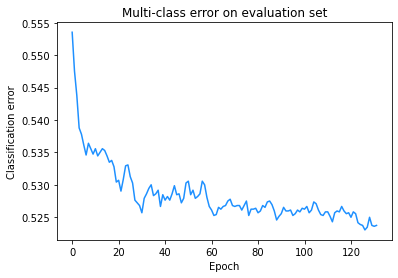

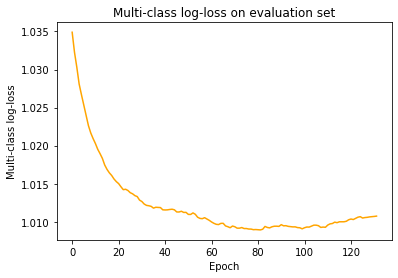

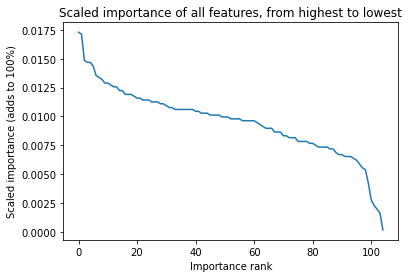

,importance,feature_number,importance_rank,importance_sc
10,106,10,0,0.017292
0,105,0,1,0.017129
29,91,29,2,0.014845
87,90,87,3,0.014682
90,90,90,4,0.014682
...,...,...,...,...
102,17,102,100,0.002773
101,14,101,101,0.002284
103,12,103,102,0.001958
100,10,100,103,0.001631


In [134]:
PlotFitByRound(gbm_models[model_vers]['model']) # Chart the fit metrics by epoch/training round, on the validation set
PlotFeatureImportance(gbm_models[model_vers]['model']) # Chart the feature importances

Time taken to score model: 0 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.477927,0.764020,0.588021,3174.000000
Increased,0.465288,0.350259,0.399662,2698.000000
Stayed same,0.446154,0.022342,0.042553,1298.000000
accuracy,0.474059,0.474059,0.474059,0.474059
macro avg,0.463123,0.378874,0.343412,7170.000000
weighted avg,0.467419,0.474059,0.418396,7170.000000


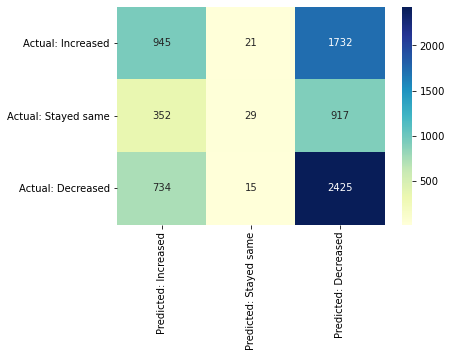

In [135]:
gbm_models[model_vers]['y_pred'] = ScoreModel(gbm_models[model_vers]['model'], testing_x['pca'], model_type = 'gbm') # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat'], gbm_models[model_vers]['y_pred'], y_order)

*Commentary on GBM version 1:*

The model appears to predict decreases in share price much more frequently than increases. 

The model yields an accuracy of 47% on the test set, which appears reasonable but it is worth noting that an accuracy of 3174/7170 = 44% is still obtainable by predicting Decreases only. So the model's performance may simply be a result of the imbalance.

In the next iteration, we experiment with modelling using the TF-IDF matrix instead of the Principal Components.

---

#### GBM iteration 2

In Iteration 2, we instead experiment with building the GBM model on the TF-IDF features. All other aspects of the model are left unchanged, so that we can isolate the effect of this change. 

*   Built on the TF-IDF features (with the cluster variable included)
*   Response variable is the % change in NEC's price with zero lag (i.e. immediate change)
*   Model set to perform multi-class classification, with the goal of optimising (multi-class) classification error. 
*   40 leaves
*   Maximum depth of 5
*   Learning rate of 15%
*   Training for 600 rounds with early stopping after 50 rounds of no improvement

##### **Commentary on the white noise test**

We choose not to implement the white noise test. The white noise test refers to including a white noise variable as part of the predictors. Any variables whose importance falls below the white noise variable gets removed. 

The reason for not including the white noise test relates to the bias inherent in the importance calculations of tree-based models. [Parr et al. explain this bias here](https://explained.ai/rf-importance/). This explanation applies to both random forest and gradient boosting machine models. In summary, the reason is that tree-based models split more frequently on variables where it can create splits. Consider a binary variable and a fully continuous variable. Only one posible split can be made on a binary variable (between 0 and 1), but many different cuts could be considered for a fully continuous variable. Importance metrics are determined based on the splits made in a tree. Therefore, tree-based importance metrics are inherently biased towards fully continuous variables. 

In the context of this problem, TF-IDF features are direct tranformations of word counts, which are discrete variables. White noise is a fully continuous variable. Therefore, the importance algorithm will be heavily biased towards the white noise variable, and suggest that one should remove all features from the model except the white noise variable. This is, of course, nonsensical. We do not run this test here, but our prior experiments confirm this bias, with the white noise variable always dominating all of the 2400 TF-IDF features. 

In [136]:
model_vers = 'v2'
gbm_models[model_vers] = dict()
gbm_models[model_vers]['model'] = FitGBMstr1(training_x['tfidf'], train_y['ch_cat'], testing_x['tfidf'], test_y['ch_cat'])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's multi_error: 0.53682	valid_0's multi_logloss: 1.02195
[20]	valid_0's multi_error: 0.529847	valid_0's multi_logloss: 1.01676
[30]	valid_0's multi_error: 0.52636	valid_0's multi_logloss: 1.01324
[40]	valid_0's multi_error: 0.523431	valid_0's multi_logloss: 1.01076
[50]	valid_0's multi_error: 0.521478	valid_0's multi_logloss: 1.00921
[60]	valid_0's multi_error: 0.521339	valid_0's multi_logloss: 1.00793
[70]	valid_0's multi_error: 0.519526	valid_0's multi_logloss: 1.00691
[80]	valid_0's multi_error: 0.518828	valid_0's multi_logloss: 1.00633
[90]	valid_0's multi_error: 0.516039	valid_0's multi_logloss: 1.0055
[100]	valid_0's multi_error: 0.515342	valid_0's multi_logloss: 1.00502
[110]	valid_0's multi_error: 0.514923	valid_0's multi_logloss: 1.00456
[120]	valid_0's multi_error: 0.51311	valid_0's multi_logloss: 1.00411
[130]	valid_0's multi_error: 0.512831	valid_0's multi_logloss: 1.00371
[140]	valid_0's multi_error: 

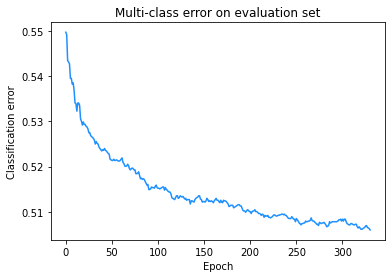

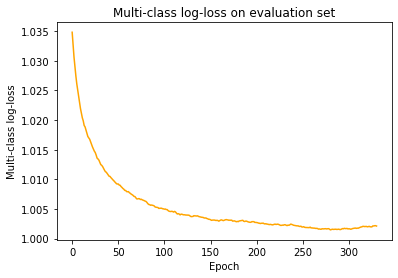

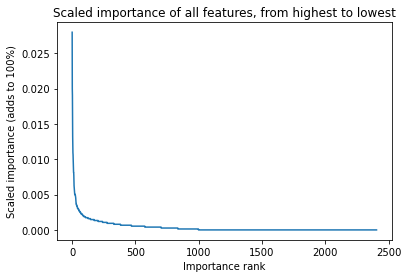

,importance,feature_number,importance_rank,importance_sc
2403,210,2403,0,0.027974
2139,150,2139,1,0.019981
2400,143,2400,2,0.019049
2401,109,2401,3,0.014520
1243,99,1243,4,0.013188
...,...,...,...,...
1115,0,1115,2400,0.000000
165,0,165,2401,0.000000
1112,0,1112,2402,0.000000
1107,0,1107,2403,0.000000


In [137]:
PlotFitByRound(gbm_models[model_vers]['model']) # Chart the fit metrics by epoch/training round, on the validation set
PlotFeatureImportance(gbm_models[model_vers]['model']) # Chart the feature importances

Time taken to score model: 0 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.489438,0.817580,0.612317,3174.000000
Increased,0.501410,0.329503,0.397674,2698.000000
Stayed same,0.484211,0.035439,0.066045,1298.000000
accuracy,0.492329,0.492329,0.492329,0.492329
macro avg,0.491686,0.394174,0.358679,7170.000000
weighted avg,0.492997,0.492329,0.432656,7170.000000


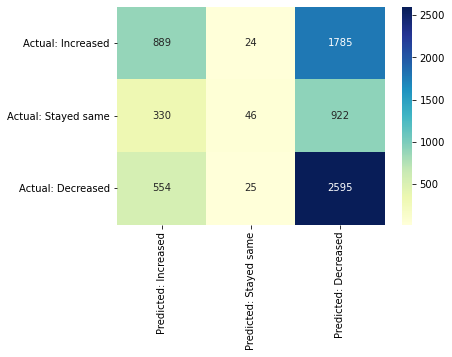

In [138]:
gbm_models[model_vers]['y_pred'] = ScoreModel(gbm_models[model_vers]['model'], testing_x['tfidf'], model_type = 'gbm') # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat'], gbm_models[model_vers]['y_pred'], y_order)

*Commentary on GBM version 2:*

This model has superior performance to Iteration 1. However, it is worth noting that this model also appears to suffer from a heavily imbalance towards predicting Decreases in share prices. 

However, we will go forward using this model, because its precision score is higher on all three classes. Precision indicates how likely a trade is to be correct given a specific trade is recommended, and thus a good indication of the win rate. 

---

#### GBM iteration 3

In Iteration 3, the only change is that we remove the cluster variable to test how much value it adds to the model. 

*   Built on the TF-IDF features (with the cluster variable excluded)
*   Response variable is the % change in NEC's price with zero lag (i.e. immediate change)
*   Model set to perform multi-class classification, with the goal of optimising (multi-class) classification error. 
*   40 leaves
*   Maximum depth of 5
*   Learning rate of 15%
*   Training for 600 rounds with early stopping after 50 rounds of no improvement

In [139]:
model_vers = 'v3'
gbm_models[model_vers] = dict()
gbm_models[model_vers]['model'] = FitGBMstr1(training_x['tfidf_nc'], train_y['ch_cat'], testing_x['tfidf_nc'], test_y['ch_cat'])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's multi_error: 0.53682	valid_0's multi_logloss: 1.02194
[20]	valid_0's multi_error: 0.529847	valid_0's multi_logloss: 1.01676
[30]	valid_0's multi_error: 0.526918	valid_0's multi_logloss: 1.01324
[40]	valid_0's multi_error: 0.523849	valid_0's multi_logloss: 1.01064
[50]	valid_0's multi_error: 0.521757	valid_0's multi_logloss: 1.00911
[60]	valid_0's multi_error: 0.522315	valid_0's multi_logloss: 1.00851
[70]	valid_0's multi_error: 0.518828	valid_0's multi_logloss: 1.00708
[80]	valid_0's multi_error: 0.516457	valid_0's multi_logloss: 1.00645
[90]	valid_0's multi_error: 0.517852	valid_0's multi_logloss: 1.00574
[100]	valid_0's multi_error: 0.517852	valid_0's multi_logloss: 1.0052
[110]	valid_0's multi_error: 0.5159	valid_0's multi_logloss: 1.00467
[120]	valid_0's multi_error: 0.515063	valid_0's multi_logloss: 1.00395
[130]	valid_0's multi_error: 0.514505	valid_0's multi_logloss: 1.00366
[140]	valid_0's multi_error: 

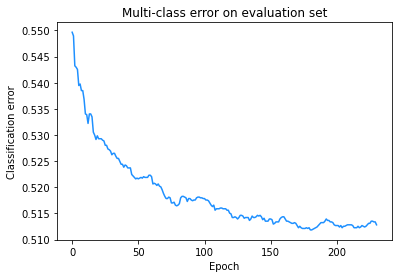

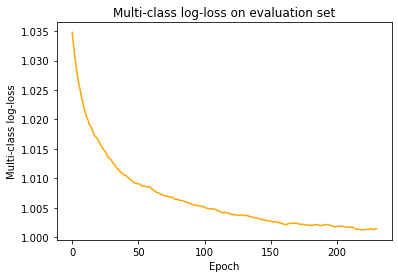

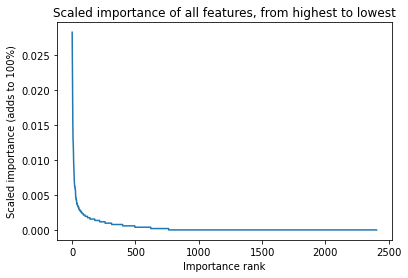

,importance,feature_number,importance_rank,importance_sc
2403,146,2403,0,0.028213
2139,131,2139,1,0.025314
2400,106,2400,2,0.020483
137,96,137,3,0.018551
2401,84,2401,4,0.016232
...,...,...,...,...
1031,0,1031,2399,0.000000
1030,0,1030,2400,0.000000
133,0,133,2401,0.000000
1028,0,1028,2402,0.000000


In [140]:
PlotFitByRound(gbm_models[model_vers]['model']) # Chart the fit metrics by epoch/training round, on the validation set
PlotFeatureImportance(gbm_models[model_vers]['model']) # Chart the feature importances

Time taken to score model: 0 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.482030,0.840895,0.612788,3174.000000
Increased,0.506394,0.293551,0.371656,2698.000000
Stayed same,0.565217,0.030046,0.057059,1298.000000
accuracy,0.488145,0.488145,0.488145,0.488145
macro avg,0.517880,0.388164,0.347168,7170.000000
weighted avg,0.506257,0.488145,0.421448,7170.000000


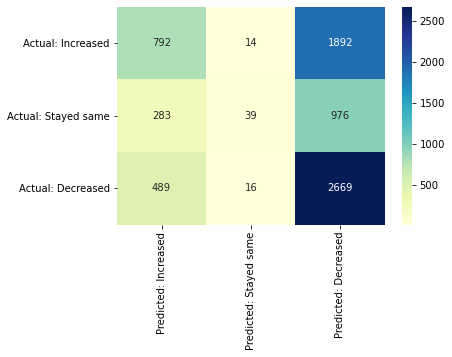

In [141]:
gbm_models[model_vers]['y_pred'] = ScoreModel(gbm_models[model_vers]['model'], testing_x['tfidf_nc'], model_type = 'gbm') # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat'], gbm_models[model_vers]['y_pred'], y_order)

*Commentary on GBM version 3:*

Classification accuracy is extremely similar (in fact slightly better) than Iteration 2, while also being slightly more balanced. Despite slightly lower precision metrics, we will go forward with Iteration 3 since the cluster variable seems to be adding very little to the model.

---

#### GBM iteration 4

For Iteration 4, we now consider the model's performance when changing the response variable from a zero-lagged variable (i.e. the % change in NEC's share price immediately after a tweet, with no lag) to a 1 hour-lagged variable (the % change in NEC's share price at least 1 hour after a tweet). 

*   Built on the TF-IDF matrix (excluding the cluster variable)
*   Response variable is the % change in NEC's price 1 hour after a tweet
*   Model set to perform multi-class classification, with the goal of optimising (multi-class) classification error. 
*   40 leaves
*   Maximum depth of 5
*   Learning rate of 15%
*   Training for 600 rounds with early stopping after 50 rounds of no improvement

In [142]:
model_vers = 'v4'
gbm_models[model_vers] = dict()
gbm_models[model_vers]['model'] = FitGBMstr1(training_x['tfidf_nc'], train_y['ch_cat1h'], testing_x['tfidf_nc'], test_y['ch_cat1h'])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's multi_error: 0.520223	valid_0's multi_logloss: 0.985382
[20]	valid_0's multi_error: 0.513947	valid_0's multi_logloss: 0.980109
[30]	valid_0's multi_error: 0.509763	valid_0's multi_logloss: 0.977048
[40]	valid_0's multi_error: 0.506555	valid_0's multi_logloss: 0.975093
[50]	valid_0's multi_error: 0.50516	valid_0's multi_logloss: 0.973705
[60]	valid_0's multi_error: 0.5053	valid_0's multi_logloss: 0.972826
[70]	valid_0's multi_error: 0.505858	valid_0's multi_logloss: 0.971736
[80]	valid_0's multi_error: 0.50251	valid_0's multi_logloss: 0.970828
[90]	valid_0's multi_error: 0.501395	valid_0's multi_logloss: 0.970168
[100]	valid_0's multi_error: 0.500837	valid_0's multi_logloss: 0.969461
[110]	valid_0's multi_error: 0.501674	valid_0's multi_logloss: 0.969619
[120]	valid_0's multi_error: 0.499163	valid_0's multi_logloss: 0.969257
[130]	valid_0's multi_error: 0.49749	valid_0's multi_logloss: 0.968903
[140]	valid_0's m

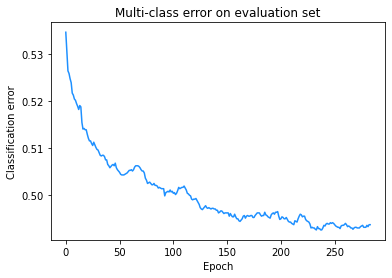

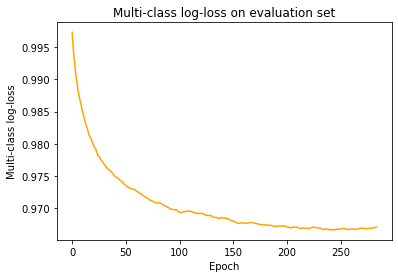

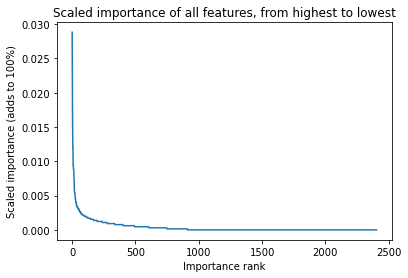

,importance,feature_number,importance_rank,importance_sc
2403,187,2403,0,0.028818
2139,151,2139,1,0.023270
2400,135,2400,2,0.020804
2401,107,2401,3,0.016489
137,89,137,4,0.013716
...,...,...,...,...
1117,0,1117,2399,0.000000
1115,0,1115,2400,0.000000
203,0,203,2401,0.000000
1113,0,1113,2402,0.000000


In [143]:
PlotFitByRound(gbm_models[model_vers]['model']) # Chart the fit metrics by epoch/training round, on the validation set
PlotFeatureImportance(gbm_models[model_vers]['model']) # Chart the feature importances

Time taken to score model: 0 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.502938,0.806138,0.619426,3291.000000
Increased,0.519978,0.335891,0.408137,2867.000000
Stayed same,0.511628,0.021739,0.041706,1012.000000
accuracy,0.507392,0.507392,0.507392,0.507392
macro avg,0.511515,0.387923,0.356423,7170.000000
weighted avg,0.510978,0.507392,0.453398,7170.000000


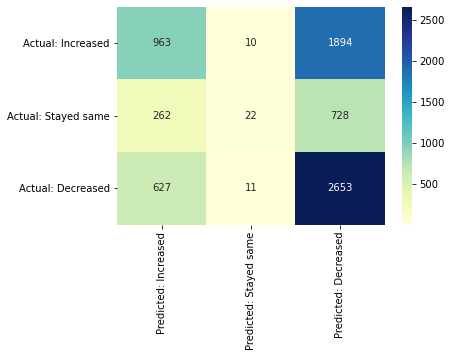

In [144]:
gbm_models[model_vers]['y_pred'] = ScoreModel(gbm_models[model_vers]['model'], testing_x['tfidf_nc'], model_type = 'gbm') # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat1h'], gbm_models[model_vers]['y_pred'], y_order)

*Commentary on GBM version 4:*

As was the case with the neural network, the model appears to be performing noticeably better when using the 1 hour-lagged stock price movement as a response variable instead of the immediate stock price movement. This may be due to less noise in the data, as volatile stock markets frequently move upward and downward for little reason. We will experiment with using a 1 day-lagged response variable next.

---

#### GBM iteration 5

Iteration 5 is identical to Iteration 4, except we instead test the ability of the model to predict the change in share price 1 day after a tweet. 

*   Built on the TF-IDF matrix
*   Response variable is the % change in NEC's price 1 day after a tweet
*   Model set to perform multi-class classification, with the goal of optimising (multi-class) classification error. 
*   40 leaves
*   Maximum depth of 5
*   Learning rate of 15%
*   Training for 600 rounds with early stopping after 50 rounds of no improvement

In [145]:
model_vers = 'v5'
gbm_models[model_vers] = dict()
gbm_models[model_vers]['model'] = FitGBMstr1(training_x['tfidf_nc'], train_y['ch_cat1d'], testing_x['tfidf_nc'], test_y['ch_cat1d'])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's multi_error: 0.483124	valid_0's multi_logloss: 0.895679
[20]	valid_0's multi_error: 0.478382	valid_0's multi_logloss: 0.890313
[30]	valid_0's multi_error: 0.473082	valid_0's multi_logloss: 0.88739
[40]	valid_0's multi_error: 0.472106	valid_0's multi_logloss: 0.885417
[50]	valid_0's multi_error: 0.472664	valid_0's multi_logloss: 0.883714
[60]	valid_0's multi_error: 0.470572	valid_0's multi_logloss: 0.882613
[70]	valid_0's multi_error: 0.468619	valid_0's multi_logloss: 0.881563
[80]	valid_0's multi_error: 0.467643	valid_0's multi_logloss: 0.880341
[90]	valid_0's multi_error: 0.466109	valid_0's multi_logloss: 0.879572
[100]	valid_0's multi_error: 0.463738	valid_0's multi_logloss: 0.878732
[110]	valid_0's multi_error: 0.463598	valid_0's multi_logloss: 0.877999
[120]	valid_0's multi_error: 0.462901	valid_0's multi_logloss: 0.877391
[130]	valid_0's multi_error: 0.460391	valid_0's multi_logloss: 0.876572
[140]	valid_0

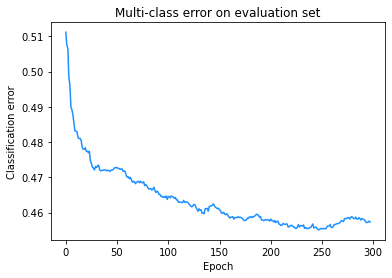

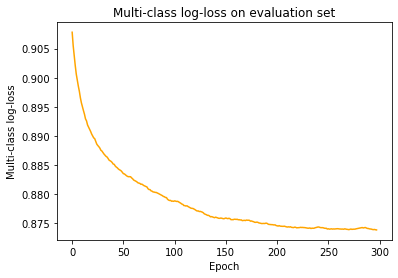

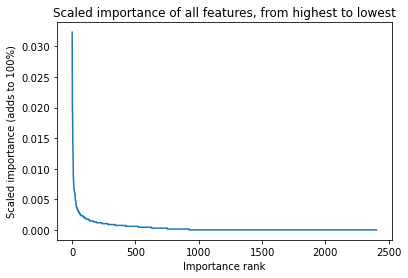

,importance,feature_number,importance_rank,importance_sc
2403,221,2403,0,0.032319
70,144,70,1,0.021059
2401,132,2401,2,0.019304
2400,132,2400,3,0.019304
1340,111,1340,4,0.016233
...,...,...,...,...
1113,0,1113,2399,0.000000
1110,0,1110,2400,0.000000
1108,0,1108,2401,0.000000
1107,0,1107,2402,0.000000


In [146]:
PlotFitByRound(gbm_models[model_vers]['model']) # Chart the fit metrics by epoch/training round, on the validation set
PlotFeatureImportance(gbm_models[model_vers]['model']) # Chart the feature importances

Time taken to score model: 0 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.543001,0.744193,0.627873,3487.000000
Increased,0.549343,0.414775,0.472668,3127.000000
Stayed same,0.500000,0.026978,0.051195,556.000000
accuracy,0.544909,0.544909,0.544909,0.544909
macro avg,0.530781,0.395315,0.383912,7170.000000
weighted avg,0.542432,0.544909,0.515466,7170.000000


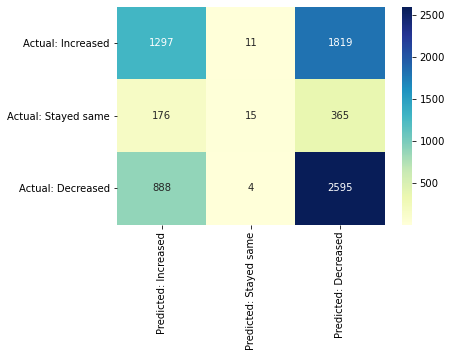

In [147]:
gbm_models[model_vers]['y_pred'] = ScoreModel(gbm_models[model_vers]['model'], testing_x['tfidf_nc'], model_type = 'gbm') # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat1d'], gbm_models[model_vers]['y_pred'], y_order)

*Commentary on GBM version 5:*

Like the neural network model, the GBM appears to be performing significantly better using the 1-day lagged share price movement as the response variable. The classification accuracy and precision across all classes has improved markedly. The balance of predictions across the Increase and Decrease classes has also improved, although very few predictions are made for the Stayed same class.

Due to the significant improvement in all goodness of fit metrics, we will progress with Iteration 5, and then experiment with changing various hyperparameters.

---

#### GBM iteration 6

Iteration 6 is identical to Iteration 5 (still built on the TF-IDF matrix and one day-lagged response variable). We now try decreasing the depth of the model. 

*   Built on the TF-IDF matrix
*   Response variable is the % change in NEC's price 1 day after a tweet
*   Model set to perform multi-class classification, with the goal of optimising (multi-class) classification error. 
*   40 leaves
*   Maximum depth of 3
*   Learning rate of 15%
*   Training for 600 rounds with early stopping after 50 rounds of no improvement 

In [148]:
def FitGBMstr2(train_x, train_y, test_x, test_y, seed = 123):
  # In this function, we construct a GBM with the purpose of multi-class classification.
  # Hyper-parameters are set to reasonable baseline figures.
  model = lgb.LGBMClassifier(
      boosting_type = 'gbdt', # Gradient-boosted decision tree is the basic GBM method
      objective = 'multiclass', # Ensure it performs multi-class classification
      num_leaves = 40,
      max_depth = 3,
      learning_rate = 0.15, # Lower learning rates preferable to avoid over-fitting
      n_estimators = 600, # Number of epochs. We will plot by this to identify where to stop fitting
      random_state = seed
  )
  model.fit(X = train_x, y = train_y, eval_set = (test_x, test_y), eval_metric = 'multi_error', verbose = 10, early_stopping_rounds = 50)
  return model

In [149]:
model_vers = 'v6'
gbm_models[model_vers] = dict()
gbm_models[model_vers]['model'] = FitGBMstr2(training_x['tfidf_nc'], train_y['ch_cat1d'], testing_x['tfidf_nc'], test_y['ch_cat1d'])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's multi_error: 0.496513	valid_0's multi_logloss: 0.899515
[20]	valid_0's multi_error: 0.483543	valid_0's multi_logloss: 0.894782
[30]	valid_0's multi_error: 0.477266	valid_0's multi_logloss: 0.891529
[40]	valid_0's multi_error: 0.475453	valid_0's multi_logloss: 0.889566
[50]	valid_0's multi_error: 0.475453	valid_0's multi_logloss: 0.888099
[60]	valid_0's multi_error: 0.475732	valid_0's multi_logloss: 0.886885
[70]	valid_0's multi_error: 0.47364	valid_0's multi_logloss: 0.885702
[80]	valid_0's multi_error: 0.472245	valid_0's multi_logloss: 0.884794
[90]	valid_0's multi_error: 0.47099	valid_0's multi_logloss: 0.88411
[100]	valid_0's multi_error: 0.470014	valid_0's multi_logloss: 0.883396
[110]	valid_0's multi_error: 0.469874	valid_0's multi_logloss: 0.88269
[120]	valid_0's multi_error: 0.470153	valid_0's multi_logloss: 0.882196
[130]	valid_0's multi_error: 0.469038	valid_0's multi_logloss: 0.881365
[140]	valid_0's 

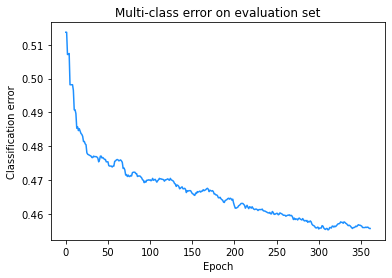

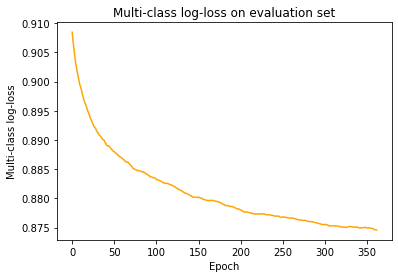

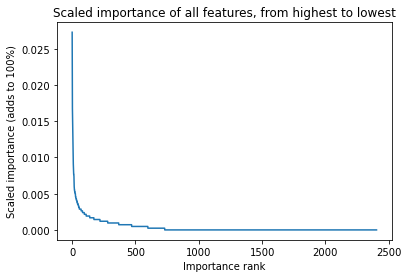

,importance,feature_number,importance_rank,importance_sc
2403,114,2403,0,0.027279
2400,78,2400,1,0.018665
2401,70,2401,2,0.016750
70,65,70,3,0.015554
2130,62,2130,4,0.014836
...,...,...,...,...
1269,0,1269,2399,0.000000
1268,0,1268,2400,0.000000
1267,0,1267,2401,0.000000
1266,0,1266,2402,0.000000


In [150]:
PlotFitByRound(gbm_models[model_vers]['model']) # Chart the fit metrics by epoch/training round, on the validation set
PlotFeatureImportance(gbm_models[model_vers]['model']) # Chart the feature importances

Time taken to score model: 0 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.540694,0.763980,0.633230,3487.00000
Increased,0.554299,0.391749,0.459059,3127.00000
Stayed same,0.484848,0.028777,0.054329,556.00000
accuracy,0.544630,0.544630,0.544630,0.54463
macro avg,0.526614,0.394836,0.382206,7170.00000
weighted avg,0.542297,0.544630,0.512379,7170.00000


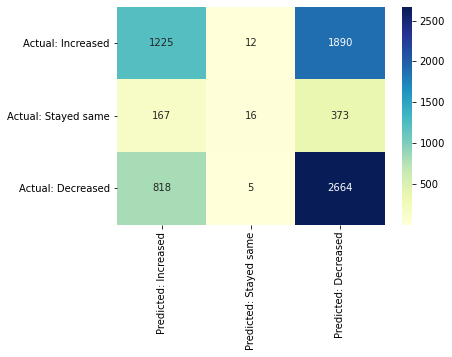

In [151]:
gbm_models[model_vers]['y_pred'] = ScoreModel(gbm_models[model_vers]['model'], testing_x['tfidf_nc'], model_type = 'gbm') # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat1d'], gbm_models[model_vers]['y_pred'], y_order)

*Commentary on GBM version 6:*

Overall classification accuracy has decreased slightly with the reduced depth of the model. Precision has also decreased across all classes relative to Iteration 5. We will next try to inrcease the depth of the model.

---

#### GBM iteration 7

Iteration 7 is identical to Iteration 6
 (still built on the TF-IDF matrix and one day-lagged response variable). We attempt increasing the depth of the model.

*   Built on the TF-IDF matrix
*   Response variable is the % change in NEC's price 1 day after a tweet
*   Model set to perform multi-class classification, with the goal of optimising (multi-class) classification error. 
*   40 leaves
*   Maximum depth of 8
*   Learning rate of 15%
*   Training for 600 rounds with early stopping after 50 rounds of no improvement

In [152]:
def FitGBMstr3(train_x, train_y, test_x, test_y, seed = 123):
  # In this function, we construct a GBM with the purpose of multi-class classification.
  # Hyper-parameters are set to reasonable baseline figures.
  model = lgb.LGBMClassifier(
      boosting_type = 'gbdt', # Gradient-boosted decision tree is the basic GBM method
      objective = 'multiclass', # Ensure it performs multi-class classification
      num_leaves = 40,
      max_depth = 8,
      learning_rate = 0.15, # Lower learning rates preferable to avoid over-fitting
      n_estimators = 600, # Number of epochs. We will plot by this to identify where to stop fitting
      random_state = seed
  )
  model.fit(X = train_x, y = train_y, eval_set = (test_x, test_y), eval_metric = 'multi_error', verbose = 10, early_stopping_rounds = 50)
  return model

In [153]:
model_vers = 'v7'
gbm_models[model_vers] = dict()
gbm_models[model_vers]['model'] = FitGBMstr3(training_x['tfidf_nc'], train_y['ch_cat1d'], testing_x['tfidf_nc'], test_y['ch_cat1d'])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's multi_error: 0.480056	valid_0's multi_logloss: 0.891511
[20]	valid_0's multi_error: 0.471967	valid_0's multi_logloss: 0.886832
[30]	valid_0's multi_error: 0.469735	valid_0's multi_logloss: 0.883841
[40]	valid_0's multi_error: 0.468898	valid_0's multi_logloss: 0.882052
[50]	valid_0's multi_error: 0.468619	valid_0's multi_logloss: 0.880229
[60]	valid_0's multi_error: 0.467225	valid_0's multi_logloss: 0.879461
[70]	valid_0's multi_error: 0.462622	valid_0's multi_logloss: 0.877967
[80]	valid_0's multi_error: 0.461088	valid_0's multi_logloss: 0.876937
[90]	valid_0's multi_error: 0.458159	valid_0's multi_logloss: 0.876347
[100]	valid_0's multi_error: 0.458159	valid_0's multi_logloss: 0.875498
[110]	valid_0's multi_error: 0.457741	valid_0's multi_logloss: 0.875311
[120]	valid_0's multi_error: 0.454672	valid_0's multi_logloss: 0.875087
[130]	valid_0's multi_error: 0.453556	valid_0's multi_logloss: 0.874621
[140]	valid_

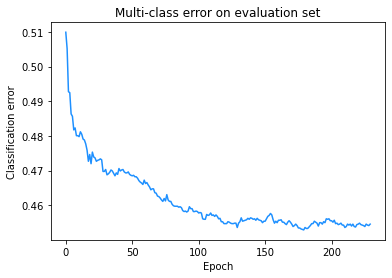

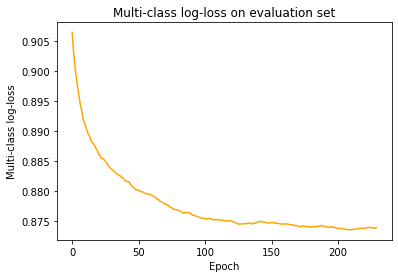

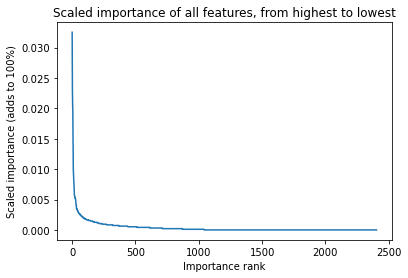

,importance,feature_number,importance_rank,importance_sc
2403,312,2403,0,0.032524
2130,236,2130,1,0.024601
2400,221,2400,2,0.023038
1340,200,1340,3,0.020849
2401,194,2401,4,0.020223
...,...,...,...,...
1138,0,1138,2399,0.000000
1137,0,1137,2400,0.000000
1135,0,1135,2401,0.000000
1134,0,1134,2402,0.000000


In [154]:
PlotFitByRound(gbm_models[model_vers]['model']) # Chart the fit metrics by epoch/training round, on the validation set
PlotFeatureImportance(gbm_models[model_vers]['model']) # Chart the feature importances

Time taken to score model: 0 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.546621,0.733008,0.626240,3487.000000
Increased,0.548741,0.432043,0.483450,3127.000000
Stayed same,0.500000,0.028777,0.054422,556.000000
accuracy,0.547141,0.547141,0.547141,0.547141
macro avg,0.531787,0.397943,0.388037,7170.000000
weighted avg,0.543930,0.547141,0.519624,7170.000000


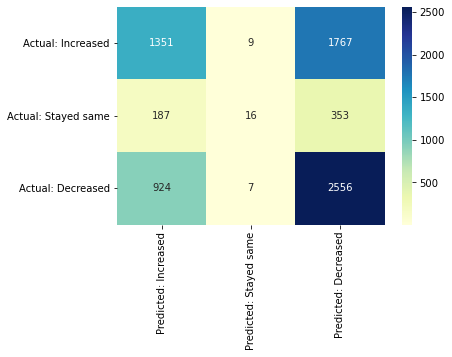

In [155]:
gbm_models[model_vers]['y_pred'] = ScoreModel(gbm_models[model_vers]['model'], testing_x['tfidf_nc'], model_type = 'gbm') # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat1d'], gbm_models[model_vers]['y_pred'], y_order)

*Commentary on GBM version 7:*

Iteration 7 has slightly superior classification accuracy and precision on the Decrease class, though precision is slightly lower on the Increase class. The model's predictions also appear to be more balanced, and less heavily skewed to predicting Decreases. 

As such, we will progress with Iteration 7. Next, we experiment with changing the number of leaves in the model.

---

#### GBM iteration 8

Iteration 8 is identical to Iteration 7
 (still built on the TF-IDF matrix and one day-lagged response variable). We now attempt increasing the number of leaves.
 
*   Built on the TF-IDF matrix
*   Response variable is the % change in NEC's price 1 day after a tweet
*   Model set to perform multi-class classification, with the goal of optimising (multi-class) classification error. 
*   60 leaves
*   Maximum depth of 8
*   Learning rate of 15%
*   Training for 600 rounds with early stopping after 50 rounds of no improvement

In [156]:
def FitGBMstr4(train_x, train_y, test_x, test_y, seed = 123):
  # In this function, we construct a GBM with the purpose of multi-class classification.
  # Hyper-parameters are set to reasonable baseline figures.
  model = lgb.LGBMClassifier(
      boosting_type = 'gbdt', # Gradient-boosted decision tree is the basic GBM method
      objective = 'multiclass', # Ensure it performs multi-class classification
      num_leaves = 60,
      max_depth = 8,
      learning_rate = 0.15, # Lower learning rates preferable to avoid over-fitting
      n_estimators = 600, # Number of epochs. We will plot by this to identify where to stop fitting
      random_state = seed
  )
  model.fit(X = train_x, y = train_y, eval_set = (test_x, test_y), eval_metric = 'multi_error', verbose = 10, early_stopping_rounds = 50)
  return model

In [157]:
model_vers = 'v8'
gbm_models[model_vers] = dict()
gbm_models[model_vers]['model'] = FitGBMstr4(training_x['tfidf_nc'], train_y['ch_cat1d'], testing_x['tfidf_nc'], test_y['ch_cat1d'])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's multi_error: 0.477266	valid_0's multi_logloss: 0.891519
[20]	valid_0's multi_error: 0.471688	valid_0's multi_logloss: 0.886529
[30]	valid_0's multi_error: 0.468619	valid_0's multi_logloss: 0.883768
[40]	valid_0's multi_error: 0.466109	valid_0's multi_logloss: 0.881685
[50]	valid_0's multi_error: 0.466388	valid_0's multi_logloss: 0.880386
[60]	valid_0's multi_error: 0.465272	valid_0's multi_logloss: 0.87904
[70]	valid_0's multi_error: 0.461785	valid_0's multi_logloss: 0.877935
[80]	valid_0's multi_error: 0.459693	valid_0's multi_logloss: 0.877173
[90]	valid_0's multi_error: 0.459135	valid_0's multi_logloss: 0.87635
[100]	valid_0's multi_error: 0.458438	valid_0's multi_logloss: 0.876074
[110]	valid_0's multi_error: 0.456904	valid_0's multi_logloss: 0.875614
[120]	valid_0's multi_error: 0.457462	valid_0's multi_logloss: 0.875273
[130]	valid_0's multi_error: 0.455927	valid_0's multi_logloss: 0.874693
[140]	valid_0'

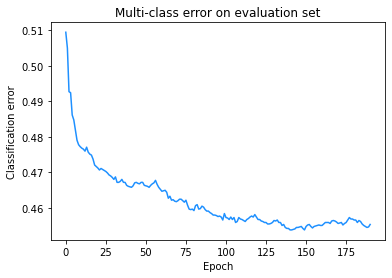

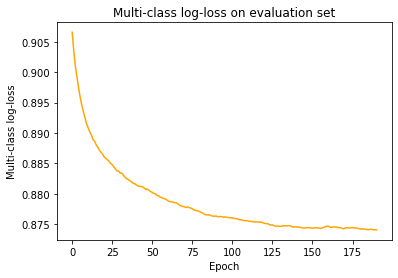

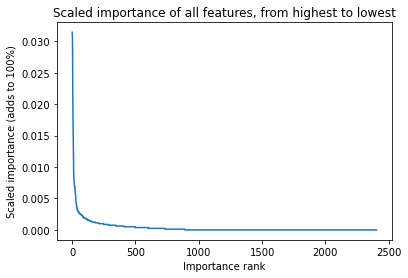

,importance,feature_number,importance_rank,importance_sc
70,253,70,0,0.031436
2130,251,2130,1,0.031188
1340,247,1340,2,0.030691
2403,234,2403,3,0.029076
2400,196,2400,4,0.024354
...,...,...,...,...
1296,0,1296,2399,0.000000
118,0,118,2400,0.000000
1293,0,1293,2401,0.000000
1292,0,1292,2402,0.000000


In [158]:
PlotFitByRound(gbm_models[model_vers]['model']) # Chart the fit metrics by epoch/training round, on the validation set
PlotFeatureImportance(gbm_models[model_vers]['model']) # Chart the feature importances

Time taken to score model: 0 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.543849,0.750502,0.630678,3487.000000
Increased,0.552451,0.410937,0.471300,3127.000000
Stayed same,0.437500,0.025180,0.047619,556.000000
accuracy,0.546165,0.546165,0.546165,0.546165
macro avg,0.511266,0.395540,0.383199,7170.000000
weighted avg,0.539353,0.546165,0.515956,7170.000000


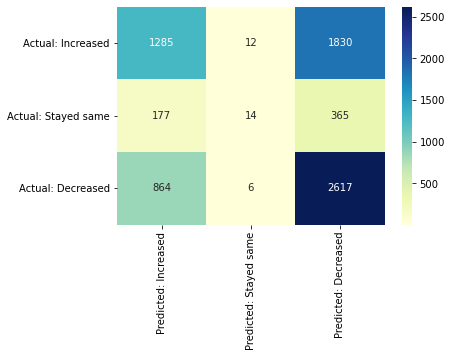

In [159]:
gbm_models[model_vers]['y_pred'] = ScoreModel(gbm_models[model_vers]['model'], testing_x['tfidf_nc'], model_type = 'gbm') # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat1d'], gbm_models[model_vers]['y_pred'], y_order)

*Commentary on GBM version 8:*

Iteration 8 performs very similarly to Iteration 7 across most metrics. Next, we experiment with decreasing the number of leaves relative to Iteration 7.

---

#### GBM iteration 9

Iteration 9 is identical to Iteration 7
 (still built on the TF-IDF matrix and one day-lagged response variable). We attempt decreasing the number of leaves instead. 
 
*   Built on the TF-IDF matrix
*   Response variable is the % change in NEC's price 1 day after a tweet
*   Model set to perform multi-class classification, with the goal of optimising (multi-class) classification error. 
*   25 leaves
*   Maximum depth of 8
*   Learning rate of 15%
*   Training for 600 rounds with early stopping after 50 rounds of no improvement

In [160]:
def FitGBMstr5(train_x, train_y, test_x, test_y, seed = 123):
  # In this function, we construct a GBM with the purpose of multi-class classification.
  # Hyper-parameters are set to reasonable baseline figures.
  model = lgb.LGBMClassifier(
      boosting_type = 'gbdt', # Gradient-boosted decision tree is the basic GBM method
      objective = 'multiclass', # Ensure it performs multi-class classification
      num_leaves = 25,
      max_depth = 8,
      learning_rate = 0.15, # Lower learning rates preferable to avoid over-fitting
      n_estimators = 600, # Number of epochs. We will plot by this to identify where to stop fitting
      random_state = seed
  )
  model.fit(X = train_x, y = train_y, eval_set = (test_x, test_y), eval_metric = 'multi_error', verbose = 10, early_stopping_rounds = 50)
  return model

In [161]:
model_vers = 'v9'
gbm_models[model_vers] = dict()
gbm_models[model_vers]['model'] = FitGBMstr5(training_x['tfidf_nc'], train_y['ch_cat1d'], testing_x['tfidf_nc'], test_y['ch_cat1d'])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's multi_error: 0.481032	valid_0's multi_logloss: 0.891909
[20]	valid_0's multi_error: 0.475593	valid_0's multi_logloss: 0.887006
[30]	valid_0's multi_error: 0.473501	valid_0's multi_logloss: 0.88425
[40]	valid_0's multi_error: 0.471269	valid_0's multi_logloss: 0.882333
[50]	valid_0's multi_error: 0.471409	valid_0's multi_logloss: 0.881195
[60]	valid_0's multi_error: 0.467922	valid_0's multi_logloss: 0.879587
[70]	valid_0's multi_error: 0.464017	valid_0's multi_logloss: 0.87832
[80]	valid_0's multi_error: 0.461227	valid_0's multi_logloss: 0.877397
[90]	valid_0's multi_error: 0.459554	valid_0's multi_logloss: 0.877064
[100]	valid_0's multi_error: 0.461367	valid_0's multi_logloss: 0.876618
[110]	valid_0's multi_error: 0.460251	valid_0's multi_logloss: 0.875799
[120]	valid_0's multi_error: 0.457601	valid_0's multi_logloss: 0.8756
[130]	valid_0's multi_error: 0.456625	valid_0's multi_logloss: 0.875292
[140]	valid_0's 

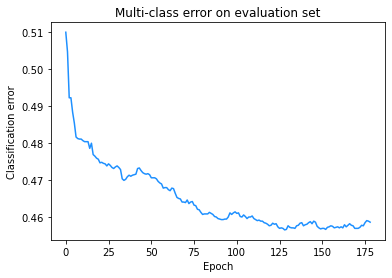

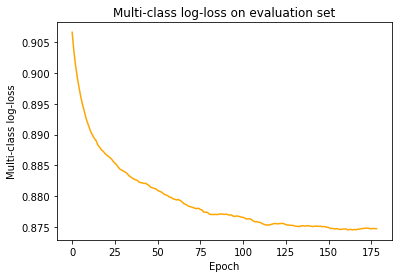

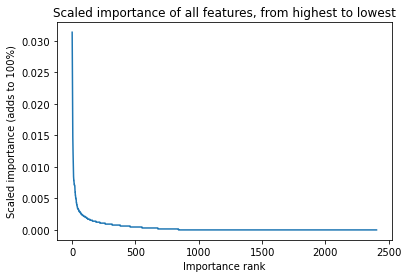

,importance,feature_number,importance_rank,importance_sc
2403,204,2403,0,0.031346
2130,179,2130,1,0.027505
2400,143,2400,2,0.021973
70,123,70,3,0.018900
2401,116,2401,4,0.017824
...,...,...,...,...
1052,0,1052,2399,0.000000
1051,0,1051,2400,0.000000
1047,0,1047,2401,0.000000
1045,0,1045,2402,0.000000


In [162]:
PlotFitByRound(gbm_models[model_vers]['model']) # Chart the fit metrics by epoch/training round, on the validation set
PlotFeatureImportance(gbm_models[model_vers]['model']) # Chart the feature importances

Time taken to score model: 0 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.541321,0.747634,0.627966,3487.000000
Increased,0.549180,0.407099,0.467585,3127.000000
Stayed same,0.472222,0.030576,0.057432,556.000000
accuracy,0.543515,0.543515,0.543515,0.543515
macro avg,0.520908,0.395103,0.384328,7170.000000
weighted avg,0.539390,0.543515,0.513778,7170.000000


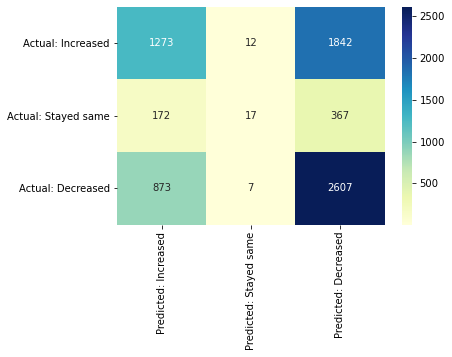

In [163]:
gbm_models[model_vers]['y_pred'] = ScoreModel(gbm_models[model_vers]['model'], testing_x['tfidf_nc'], model_type = 'gbm') # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat1d'], gbm_models[model_vers]['y_pred'], y_order)

*Commentary on GBM version 9:*

Iteration 9 has poorer overall classification accuracy and precision on the Decrease class, though it does have superior precision on the Increase class. Overall, changing the number of leaves seems to have had virtually no impact on the goodness of fit, so we will leave it unchanged from Iteration 7.

Next, we experiment with changing the learning rate of the model.

---

#### GBM iteration 10

Iteration 10 is identical to Iteration 9
 (still built on the TF-IDF matrix and one day-lagged response variable). We now attempt to increase the learning rate.
 
*   Built on the TF-IDF matrix
*   Response variable is the % change in NEC's price 1 day after a tweet
*   Model set to perform multi-class classification, with the goal of optimising (multi-class) classification error. 
*   40 leaves
*   Maximum depth of 8
*   Learning rate of 20%
*   Training for 600 rounds with early stopping after 50 rounds of no improvement

In [164]:
def FitGBMstr6(train_x, train_y, test_x, test_y, seed = 123):
  # In this function, we construct a GBM with the purpose of multi-class classification.
  # Hyper-parameters are set to reasonable baseline figures.
  model = lgb.LGBMClassifier(
      boosting_type = 'gbdt', # Gradient-boosted decision tree is the basic GBM method
      objective = 'multiclass', # Ensure it performs multi-class classification
      num_leaves = 40,
      max_depth = 8,
      learning_rate = 0.20, # Lower learning rates preferable to avoid over-fitting
      n_estimators = 600, # Number of epochs. We will plot by this to identify where to stop fitting
      random_state = seed
  )
  model.fit(X = train_x, y = train_y, eval_set = (test_x, test_y), eval_metric = 'multi_error', verbose = 10, early_stopping_rounds = 50)
  return model

In [165]:
model_vers = 'v10'
gbm_models[model_vers] = dict()
gbm_models[model_vers]['model'] = FitGBMstr6(training_x['tfidf_nc'], train_y['ch_cat1d'], testing_x['tfidf_nc'], test_y['ch_cat1d'])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's multi_error: 0.474895	valid_0's multi_logloss: 0.889641
[20]	valid_0's multi_error: 0.471409	valid_0's multi_logloss: 0.884367
[30]	valid_0's multi_error: 0.468201	valid_0's multi_logloss: 0.881987
[40]	valid_0's multi_error: 0.467085	valid_0's multi_logloss: 0.880575
[50]	valid_0's multi_error: 0.461925	valid_0's multi_logloss: 0.878988
[60]	valid_0's multi_error: 0.459972	valid_0's multi_logloss: 0.878057
[70]	valid_0's multi_error: 0.457462	valid_0's multi_logloss: 0.87715
[80]	valid_0's multi_error: 0.455091	valid_0's multi_logloss: 0.876138
[90]	valid_0's multi_error: 0.457043	valid_0's multi_logloss: 0.876089
[100]	valid_0's multi_error: 0.456625	valid_0's multi_logloss: 0.875398
[110]	valid_0's multi_error: 0.457183	valid_0's multi_logloss: 0.875422
[120]	valid_0's multi_error: 0.458577	valid_0's multi_logloss: 0.875181
[130]	valid_0's multi_error: 0.457601	valid_0's multi_logloss: 0.87503
Early stopping

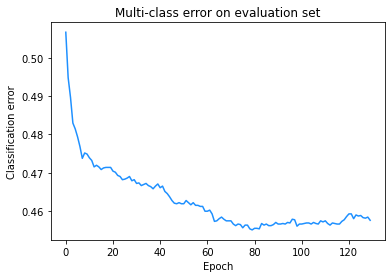

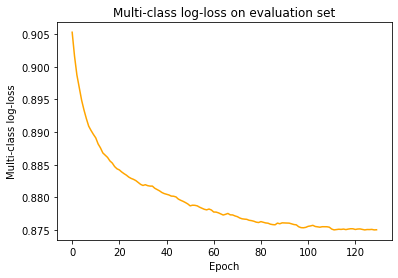

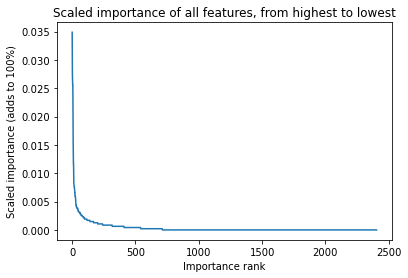

,importance,feature_number,importance_rank,importance_sc
2130,165,2130,0,0.034884
2403,135,2403,1,0.028541
70,129,70,2,0.027273
1340,122,1340,3,0.025793
2400,121,2400,4,0.025581
...,...,...,...,...
540,0,540,2399,0.000000
541,0,541,2400,0.000000
1253,0,1253,2401,0.000000
1252,0,1252,2402,0.000000


In [166]:
PlotFitByRound(gbm_models[model_vers]['model']) # Chart the fit metrics by epoch/training round, on the validation set
PlotFeatureImportance(gbm_models[model_vers]['model']) # Chart the feature importances

Time taken to score model: 0 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.541071,0.759392,0.631906,3487.000000
Increased,0.554072,0.398145,0.463342,3127.000000
Stayed same,0.482759,0.025180,0.047863,556.000000
accuracy,0.544909,0.544909,0.544909,0.544909
macro avg,0.525967,0.394239,0.381037,7170.000000
weighted avg,0.542219,0.544909,0.513101,7170.000000


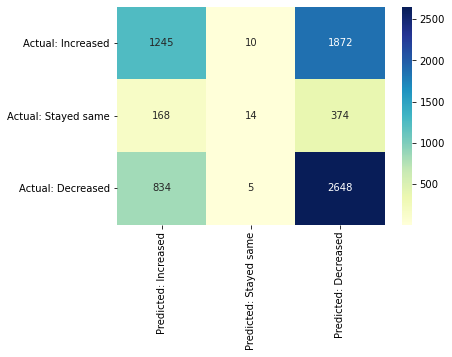

In [167]:
gbm_models[model_vers]['y_pred'] = ScoreModel(gbm_models[model_vers]['model'], testing_x['tfidf_nc'], model_type = 'gbm') # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat1d'], gbm_models[model_vers]['y_pred'], y_order)

*Commentary on GBM version 10:*

The model performs more poorly than Iteration 7, with lower precision on both Increase and Decrease classes and lower classification accuracy. The model may be over-fitting as often occurs with higher learning rates; we can also see the log-loss on the evaluation set slightly increasing towards later epochs.

Next, we will try decreasing the learning rate.

---

#### GBM iteration 11

Iteration 11 is identical to Iteration 9
 (still built on the TF-IDF matrix and one day-lagged response variable). We now attempt to decrease the learning rate. 
 
*   Built on the TF-IDF matrix
*   Response variable is the % change in NEC's price 1 day after a tweet
*   Model set to perform multi-class classification, with the goal of optimising (multi-class) classification error. 
*   40 leaves
*   Maximum depth of 8
*   Learning rate of 10%
*   Training for 600 rounds with early stopping after 50 rounds of no improvement

In [168]:
def FitGBMstr7(train_x, train_y, test_x, test_y, seed = 123):
  # In this function, we construct a GBM with the purpose of multi-class classification.
  # Hyper-parameters are set to reasonable baseline figures.
  model = lgb.LGBMClassifier(
      boosting_type = 'gbdt', # Gradient-boosted decision tree is the basic GBM method
      objective = 'multiclass', # Ensure it performs multi-class classification
      num_leaves = 40,
      max_depth = 8,
      learning_rate = 0.10, # Lower learning rates preferable to avoid over-fitting
      n_estimators = 600, # Number of epochs. We will plot by this to identify where to stop fitting
      random_state = seed
  )
  model.fit(X = train_x, y = train_y, eval_set = (test_x, test_y), eval_metric = 'multi_error', verbose = 10, early_stopping_rounds = 50)
  return model

In [169]:
model_vers = 'v11'
gbm_models[model_vers] = dict()
gbm_models[model_vers]['model'] = FitGBMstr7(training_x['tfidf_nc'], train_y['ch_cat1d'], testing_x['tfidf_nc'], test_y['ch_cat1d'])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's multi_error: 0.482566	valid_0's multi_logloss: 0.894867
[20]	valid_0's multi_error: 0.476709	valid_0's multi_logloss: 0.889169
[30]	valid_0's multi_error: 0.472943	valid_0's multi_logloss: 0.886497
[40]	valid_0's multi_error: 0.471548	valid_0's multi_logloss: 0.884717
[50]	valid_0's multi_error: 0.469317	valid_0's multi_logloss: 0.883309
[60]	valid_0's multi_error: 0.470293	valid_0's multi_logloss: 0.881894
[70]	valid_0's multi_error: 0.467085	valid_0's multi_logloss: 0.881007
[80]	valid_0's multi_error: 0.46583	valid_0's multi_logloss: 0.880123
[90]	valid_0's multi_error: 0.463877	valid_0's multi_logloss: 0.879036
[100]	valid_0's multi_error: 0.463598	valid_0's multi_logloss: 0.878473
[110]	valid_0's multi_error: 0.462901	valid_0's multi_logloss: 0.877763
[120]	valid_0's multi_error: 0.462064	valid_0's multi_logloss: 0.877283
[130]	valid_0's multi_error: 0.461367	valid_0's multi_logloss: 0.876884
[140]	valid_0

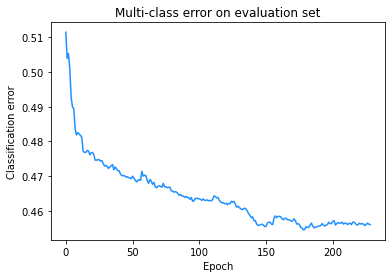

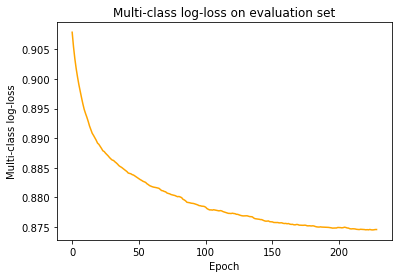

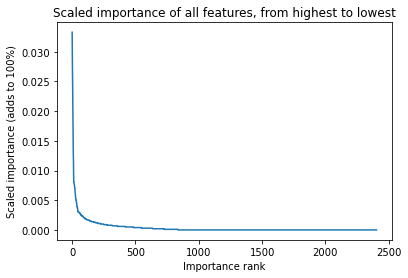

,importance,feature_number,importance_rank,importance_sc
2130,339,2130,0,0.033281
2403,292,2403,1,0.028667
70,279,70,2,0.027391
2400,250,2400,3,0.024543
1340,241,1340,4,0.023660
...,...,...,...,...
1292,0,1292,2399,0.000000
1291,0,1291,2400,0.000000
1290,0,1290,2401,0.000000
372,0,372,2402,0.000000


In [170]:
PlotFitByRound(gbm_models[model_vers]['model']) # Chart the fit metrics by epoch/training round, on the validation set
PlotFeatureImportance(gbm_models[model_vers]['model']) # Chart the feature importances

Time taken to score model: 0 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.542366,0.750789,0.629781,3487.000000
Increased,0.552620,0.408059,0.469463,3127.000000
Stayed same,0.500000,0.030576,0.057627,556.000000
accuracy,0.545467,0.545467,0.545467,0.545467
macro avg,0.531662,0.396474,0.385624,7170.000000
weighted avg,0.543553,0.545467,0.515495,7170.000000


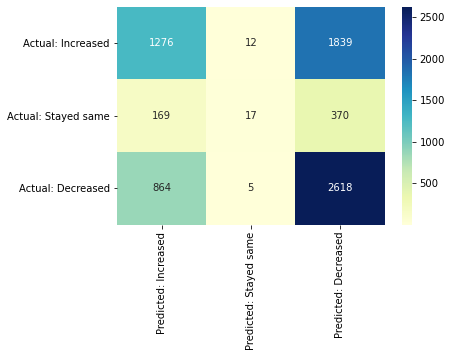

In [171]:
gbm_models[model_vers]['y_pred'] = ScoreModel(gbm_models[model_vers]['model'], testing_x['tfidf_nc'], model_type = 'gbm') # Score the model on the testing set
CalculateFitMetrics(test_y['ch_cat1d'], gbm_models[model_vers]['y_pred'], y_order)

*Commentary on GBM version 11:*

Iteration 11 has the better overall performance compared to Iteration 7 in terms of accuracy and precision on both the Increase and Decrease classes. We observe that Iteration 11 has trained more slowly, over a longer period (more epochs). Lower learning rates generally result in less over-fitting. 

As such, we will progress with Iteration 11 as the final version. 

#### **Final tree model selection**

Iteration 11 will be the final tree-based model selected. We summarise the model and **justify the selections** here.

*   The predictors used are the TF-IDF vectors. The reasons for this are the same as in the Neural Network model. We use these as predictors because: 1) The principal components were only able to explain 23% of the variation in the data, as shown in Question 3(b)ii., which means a lot of potential signal will be missed. 2) The model had superior performance on the testing set when fitted on the TF-IDF features compared to the Principal Components, and 3) Model fit time is not significantly higher on the TF-IDF features, so there are no run-time or memory-related issues.
*   The response variable used is the change in NEC's stock price 1 day after a tweet - again, just like in the Neural Network model. We use this because the model performance significantly improves when predicting the price movement 1 day after a tweet, suggesting there is less noise over longer time frames. In the context of trading, this is equivalent to purchasing the share on a tweet, holding it for a day and then selling. 
*   We set a maximum depth of 8 layers. [Bradley Boehmke's Hands-On Machine Learning](https://bradleyboehmke.github.io/HOML/gbm.html#basic-gbm) guide argues that "typical (tree depth) values range from a depth of 3 - 8", and given the high degree of complexity in the data and large number of features, picking a value on the higher end is appropriate. The model also had slightly superior performance with 8 layers compared to 3 layers or 5 layers. 
*   We use 40 leaves in the model. (Note that the package we use - LightGBM - uses a leaf-wise tree growth algorithm while other commonly used GBM packages use depth-wide tree growth algorithms). For other packages, the number of leaves used is typically set to 2 to the power of the maximum depth (i.e. 256), but [LightGBM's documentation](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) argues that this is too much and would cause over-fitting. In our Iterations, we have experimented with lower values (25, 40 and 60) and found the performance best with 40 leaves. 
*   We use a learning rate of 10%. High learning rates typically cause the model to quickly over-fit on the training dataset. Applying a lower learning rate forces the model to "slow down" and make fewer corrections to fit the residuals at each node. [Jason Brownlee argues that smaller learning rates](https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/) in the range of 10% to 30% are commonly used, and due to the high complexity of the data we have chosen 10% to avoid over-fitting of the data. 
*   We train the model for 600 rounds, but stop the training early if the performance on the testing set doesn't improve for 50 rounds. This also helps to avoid over-fitting by ceasing the training before it over-fits.



#### **Checks on the final tree model**

In this section, we run a similar set of checks on the tree-based model.

**Check 1: Ensuring that only 3 classes are predicted**

In [172]:
np.unique(gbm_models['v11']['y_pred'])

array(['Decreased', 'Increased', 'Stayed same'], dtype=object)

It is clear that only three classes can be predicted by the model - Increased, Stayed same and Decreased. This is as expected.

**Check 2: Actual vs Expected chart by corporate flag**

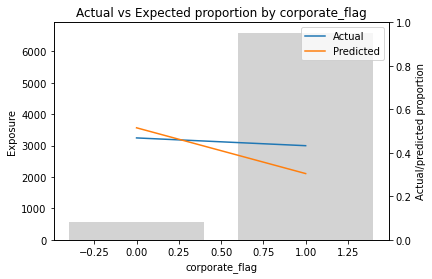

In [173]:
tweet_test['gbm_pred'] = gbm_models['v11']['y_pred']
AvsE(tweet_test, actual = 'NEC_ch_cat1d', pred = 'gbm_pred', by_var = 'corporate_flag', plot_class = 'Increased')

placeholder

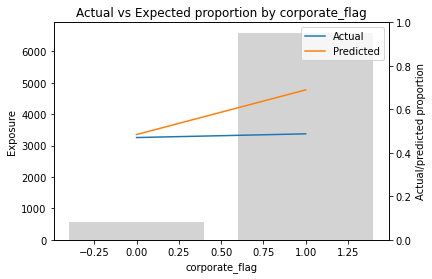

In [174]:
AvsE(tweet_test, actual = 'NEC_ch_cat1d', pred = 'gbm_pred', by_var = 'corporate_flag', plot_class = 'Decreased')

placeholder

**Check 3: Actual vs Expected chart by cluster**

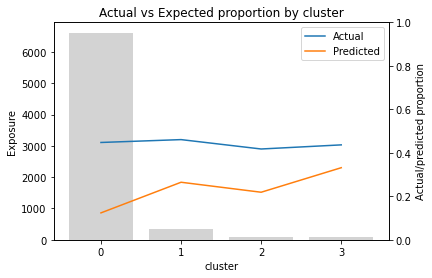

In [175]:
AvsE(tweet_test, actual = 'NEC_ch_cat1d', pred = 'gbm_pred', by_var = 'cluster', plot_class = 'Increased')

placeholder

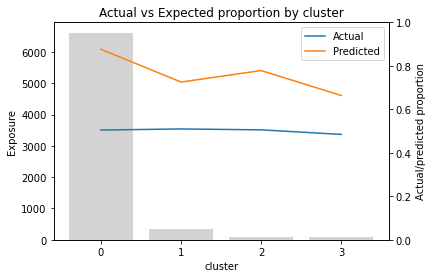

In [176]:
AvsE(tweet_test, actual = 'NEC_ch_cat1d', pred = 'gbm_pred', by_var = 'cluster', plot_class = 'Decreased')

placeholder

### **Question 4 (d) - Evaluating the neural network and tree models in meeting the objectives**

This is the approach we will use to evaluate the performance of the neural network and tree models:

1.   Combine the training and testing sets.
2.   Re-train the models on the combined training and testing set. This is to ensure that the maximum possible data is being used. These will be called the "final models". 
3.   Score the model and measure performance on the holdout set. The holdout set is an out-of-time sample, to avoid data leakage (i.e. prevent any information from "future tweets" entering the model). 

The final models will make use of the TF-IDF features as predictors, without any clustering applied (as we found its value to be insignificant). The 1-day lagged change in share price will be used as a response variable. 

Then, we will evaluate how well the model performs in meeting the goals of the analysis (i.e. to predict share price movements and boost the investment fund's performance) by considering the following measures of success:

*   Classification metrics - mainly classification accuracy and precision
*   Trading win rate
*   Cumulative percentage return. This is technically the most valid evaluation metric, because it calculates the percentage return earned if we built the model at 15 May 2021 (the holdout cut-off date) and executed the model between 15 May 2021 and 23 June 2021 (the dates spanning the holdout dataset).
*   Average return of each trade
*   Outperformance over the market (which is a very important metric because ultimately all fund managers want to outperform the market)
*   Volatility of returns
*   Time taken to score the model



#### Re-fitting the model on the combined train-test data
Note that we will only re-run the calculation of the TF-IDF matrix, and not the calculation of Principal Components or K-Means clusters. This is because the initial analysis from Question 4(b) and 4(c) found that inclusion of these variables didn't provide any significant benefit to the model fit.

In [177]:
tfidf_models['train_test'], vec_train_test, vec_holdout = TransformTFIDF(tweet_train_test['tweet_text_clean'], tweet_holdout['tweet_text_clean'], 2400, as_dense = True)

Shape of TF-IDF training matrix is (35846, 2400)
Shape of TF-IDF scoring matrix is (10139, 2400)


In [178]:
other_pred = ['retweet_flag', 'url_flag', 'corporate_flag', 'channel9_flag']
train_test_x = dict()
holdout_x = dict()

# Prepare TF-IDF matrix and y-values
train_test_x['tfidf'], holdout_x['tfidf'], train_test_y, holdout_y, y_enc  = PrepareModellingData(vec_train_test, vec_holdout, tweet_train_test[y_vars], tweet_holdout[y_vars], tweet_train_test[other_pred], tweet_holdout[other_pred])

**Final neural network model**

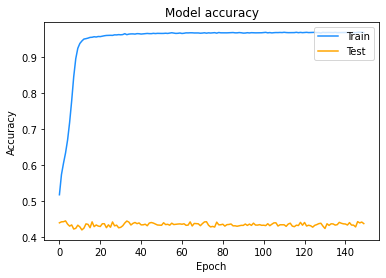

In [179]:
nn_final = dict()
model_vers = 'final'
nn_final[model_vers] = dict()
nn_final[model_vers]['model'] = FitNNstr6() # Fitting last version of neural network onto train-test data 
nn_final[model_vers]['model_history'] = nn_final[model_vers]['model'].fit(train_test_x['tfidf'], train_test_y['ch_ohe1d'], validation_data = (holdout_x['tfidf'], holdout_y['ch_ohe1d']), 
                                                                          epochs = 150, batch_size = 64, verbose = 0, callbacks=[TqdmCallback(verbose=1)])
ModelFitByEpoch(nn_final[model_vers]['model_history'])

Time taken to score model: 2 seconds
Time taken to score model: 1 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.413034,0.673882,0.512158,4204.000000
Increased,0.531355,0.294745,0.379165,5347.000000
Stayed same,0.066879,0.035714,0.046563,588.000000
accuracy,0.436927,0.436927,0.436927,0.436927
macro avg,0.337089,0.334780,0.312629,10139.000000
weighted avg,0.455358,0.436927,0.415020,10139.000000


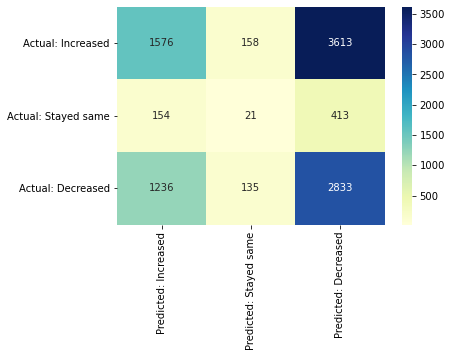

In [180]:
tweet_train_test['nn_pred'] = ScoreModel(nn_final[model_vers]['model'], train_test_x['tfidf'], model_type = 'nn', encoder = y_enc) # Score the model on the holdout set
tweet_holdout['nn_pred'] = ScoreModel(nn_final[model_vers]['model'], holdout_x['tfidf'], model_type = 'nn', encoder = y_enc) # Score the model on the holdout set
CalculateFitMetrics(holdout_y['ch_cat1d'], tweet_holdout['nn_pred'], y_order)

**Final GBM model**

In [181]:
def FitGBMfinal(train_x, train_y, test_x, test_y, seed = 123):
  # In this function, we construct a GBM with the purpose of multi-class classification.
  # Hyper-parameters are set to reasonable baseline figures.
  model = lgb.LGBMClassifier(
      boosting_type = 'gbdt', # Gradient-boosted decision tree is the basic GBM method
      objective = 'multiclass', # Ensure it performs multi-class classification
      num_leaves = 40,
      max_depth = 8,
      learning_rate = 0.10, # Lower learning rates preferable to avoid over-fitting
      n_estimators = 243, # Setting same number of epochs as was used in Iteration 11
      random_state = seed
  )
  model.fit(X = train_x, y = train_y, eval_set = (test_x, test_y), eval_metric = 'multi_error', verbose = 10)
  return model
gbm_final = dict()
model_vers = 'final'
gbm_final[model_vers] = dict()
gbm_final[model_vers]['model'] = FitGBMfinal(train_test_x['tfidf'], train_test_y['ch_cat1d'], holdout_x['tfidf'], holdout_y['ch_cat1d'])

[10]	valid_0's multi_error: 0.58132	valid_0's multi_logloss: 0.913351
[20]	valid_0's multi_error: 0.578854	valid_0's multi_logloss: 0.92956
[30]	valid_0's multi_error: 0.576783	valid_0's multi_logloss: 0.937083
[40]	valid_0's multi_error: 0.573429	valid_0's multi_logloss: 0.939003
[50]	valid_0's multi_error: 0.572838	valid_0's multi_logloss: 0.941135
[60]	valid_0's multi_error: 0.570865	valid_0's multi_logloss: 0.943338
[70]	valid_0's multi_error: 0.570865	valid_0's multi_logloss: 0.945127
[80]	valid_0's multi_error: 0.570175	valid_0's multi_logloss: 0.947185
[90]	valid_0's multi_error: 0.568399	valid_0's multi_logloss: 0.947993
[100]	valid_0's multi_error: 0.567906	valid_0's multi_logloss: 0.949023
[110]	valid_0's multi_error: 0.568695	valid_0's multi_logloss: 0.949719
[120]	valid_0's multi_error: 0.567709	valid_0's multi_logloss: 0.950391
[130]	valid_0's multi_error: 0.567314	valid_0's multi_logloss: 0.95238
[140]	valid_0's multi_error: 0.566427	valid_0's multi_logloss: 0.953159
[150

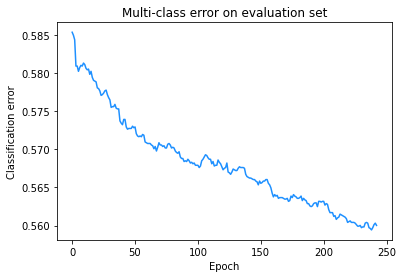

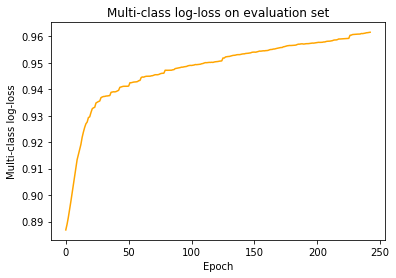

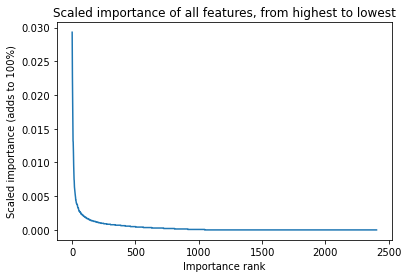

,importance,feature_number,importance_rank,importance_sc
2403,419,2403,0,0.029315
2133,354,2133,1,0.024767
2400,325,2400,2,0.022738
2401,303,2401,3,0.021199
68,287,68,4,0.020080
...,...,...,...,...
1194,0,1194,2399,0.000000
1193,0,1193,2400,0.000000
1192,0,1192,2401,0.000000
1191,0,1191,2402,0.000000


In [182]:
PlotFitByRound(gbm_final['final']['model']) # Chart the fit metrics by epoch/training round, on the validation set
PlotFeatureImportance(gbm_final['final']['model']) # Chart the feature importances

Time taken to score model: 3 seconds
Time taken to score model: 1 seconds
AxesSubplot(0.125,0.125;0.62x0.755)


,precision,recall,f1-score,support
Decreased,0.416266,0.823026,0.552892,4204.000000
Increased,0.548546,0.187021,0.278940,5347.000000
Stayed same,0.250000,0.001701,0.003378,588.000000
accuracy,0.439984,0.439984,0.439984,0.439984
macro avg,0.404937,0.337249,0.278404,10139.000000
weighted avg,0.476384,0.439984,0.376550,10139.000000


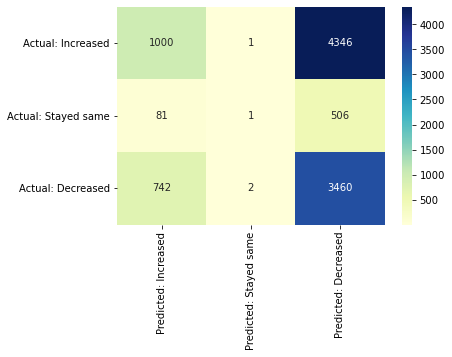

In [183]:
tweet_train_test['gbm_pred'] = ScoreModel(gbm_final['final']['model'], train_test_x['tfidf'], model_type = 'gbm', encoder = y_enc) # Score the model on the training-testing set
tweet_holdout['gbm_pred'] = ScoreModel(gbm_final['final']['model'], holdout_x['tfidf'], model_type = 'gbm', encoder = y_enc) # Score the model on the holdout set
CalculateFitMetrics(holdout_y['ch_cat1d'], tweet_holdout['gbm_pred'], y_order)

##### **Success measure 1: Classification accuracy**

Classification accuracy refers to the % of correct predictions made by the model. As with all success measures, we calculate classification accuracy on the out-of-time holdout set. 

**Justification for using this measure:** one of the goals of this analysis is to be able to correctly predict share price movements so that trades can be executed. Classification accuracy is a simple way to measure the model's ability to predict share price movements across all classes. 

The final Neural Network model has an accuracy of 46%, while the final GBM model has an accuracy of 44%. Both models are superior to a random guess, which would yield 33% accuracy. 

It is also worth noting that if one were to predict that the share price Increased 100% of the time, you would still yield an accuracy of 5347/10139 = 52.7%, and if one always predicted Decrease, the accuracy would be 41.5%. So the overall accuracy is fairly similar to making a one-sided prediction. 

Overall, both model's performance is not particularly strong on this measure, given that one could simply achieve a greater accuracy by always predicting a share price Increse. 

##### **Success measure 2: Precision**

A model's precision in predicting the increase class can be defined as: out of the tweets we predicted to cause a share price Increase, how many actually did cause an Increase? A similar definition holds for the Decrease and Stayed same classes. 

**Justification for using this measure:** Consider a long-only trading strategy, which are employed by many investment funds due to the lower costs of long trades relative to short trades. A long-only trading strategy will only make purchases when the model predicts a tweet to cause a share price Increase. Therefore, the percentage of profitable trades can be calculated using precision, since it measures how often we are correct out of the times we predict an Increase. Likewise, for a short-only trading strategy, precision on the Decrease class is of great importance. 

The final Neural Network model has a precision of 53.3% on the Increase class, while the GBM has 54.5% precision. 

The final Neural Network model has a precision of 41.4% on the Decrease class, while the GBM has 41.6% precision. 

We don't consider the precision on the Stayed same class as the model won't trade on tweets that don't move the share price. 

Overall, both models have especially strong precision on the Increase class. They would perform quite well in a long-only trading strategy, as 53.3% of trades that the neural network makes and 54.5% of trades the GBM model makes would be profitable. This is a good outcome as the models are correct more often than it is wrong. Assuming market conditions stay the same (which is a very strong assumption), this would suggest the models are profitable in the long run. A great deal of testing across different time windows will be needed to confirm this, so this would be a critical next step for the investment fund. However, the models would perform poorly in a short-only trading strategy, and likely would be close to break-even on a long and short trading strategy. 

##### **Success measure 3: Recall**

Recall is also of interest because it measures how often we are able to capture a particular share price movement. Recall on the Increase class could be defined as: out of the records where an increase actually occurred, how often was our model able to predict it correctly? In other words, how likely is our model to capitalise on a share price movement? 

**Justification for using this measure:** Recall essentially answers the following question: how likely is our model to capitalise on a share price Increase (or Decrease)? This is a useful measure in understanding how well our model performs in capturing profitable trading opportunities in the market, though Precision is arguably a more useful metric in this context since Precision can be used to measure the fund's win rate. 

On the Increase class, the Neural Network model has a recall of 44% and the GBM has a recall of 19%. 

On the Decrease class, the Neural Network model has a recall of 54% and the GBM has a recall of 82%.

Overall, this suggests that the Neural Network model is fairly balanced in its predictions while the GBM is heavily skewed towards predicting share price Decreases. This is obvious from looking at the confusion matrices above. The GBM's very high recall on the Decrease class and very low recall on the Increase class is simply a result of making an excessive number of Decrease predictions, and therefore missing out on many profitable trades from share price Increases. This is a very useful insight. While the Precision metrics suggested that the GBM may have a good win rate on a long-only trading strategy, the Recall metrics show that this is because the GBM is extremely selective in recommending long trades. So the GBM may not be the best model if it turns out that it's actually missing out on a lot of profitable trading opportunities by being so selective. It also highlights a potential issue with the extreme imbalance of the GBM's predictions. If the model predicts so many share price Decreases on this holdout set, it may be heavily biased towards Decrease predictions on other time periods too. An important next step to consider is to perform further out-of-time testing. 

#### **Backtest helper functions**

In this section, we simulate how well this model will perform when trading on a real set of data. 

Having trained the model on data up to 15 May 2021, we then run the model on tweet data between 15 May 2021 and the last day (23 June 2021) and calculate the % return achieved on each trade over this period.

In [184]:
def TweetMovementPerDay(indata, move_col, move_types, plot_title = None):
  '''
  Before we backtest a trading strategy, we must first decide on a strategy. This function is intended to assist with that. 

  This function charts the number of tweets made per day where the model predicts (for example) an increase in the stock price (as specified in move_types). 

  The Backtest functions test a strategy where a maximum of N tweets can be made per day, where the % of the portfoio invested = 1/N. This function supports the Backtest 
  functions by helping with the selection of an appropriate choice of N (e.g. for a long-only strategy, this should be roughly the average number of tweets made
  per day where the model predicts an increase in stock price). 

  indata is a Pandas DataFrame containing the tweets, with model predictions as columns on the DataFrame.

  move_col is a string containing the name of the column with the model predictions (you could also supply the actual stock movements if that is of interest).

  move_types is a list of strings specifying the type of movements we are interested in. For a long-only strategy, you are only interested in buying when the price is predicted to increase, so
  you would set move_types to ['Increased']. For a long-short strategy, you are interested in both increases and decreases, so this would be ['Increased', 'Decreased']. 

  plot_title is a string containing the text used in the title of the backtest results chart (or None to use the automatic title of "Number of tweets per day")
  '''

  dt = indata.copy() # Copy indata so we don't accidentally modify it by reference
  dt['tweet_post_date'] = [datetime.datetime.date(j) for j in dt['tweet_post_time']] # Truncate tweet datetimes to date, as we will aggregate the return per day.

  # Cross-tabulate the number of tweets we want per day
  tweet_moves = pd.crosstab(dt['tweet_post_date'], dt[move_col]) # Tabulates number of predicted 'Increase', 'Decrease' and 'Stayed same' tweets per day 
  tweet_moves_sel = tweet_moves[move_types] # Select only the ones we're interested in (e.g. 'Increased' for long-only strategy)
  tweet_moves_sel['total_tweets'] = tweet_moves_sel.sum(axis = 1) # Sum across rows
  tweet_moves_sel['MA14_total_tweets'] = tweet_moves_sel['total_tweets'].rolling(window = 14).mean() # Calculate number of tweets per day of interest, but as 14-day moving average instead
  # We chart the 14-day moving average because it helps to smooth out the volatile tweet counts, which assists in setting assumptions. 

  # Chart the number of tweets per day by predicted stock movement
  plt.plot(tweet_moves_sel.index, tweet_moves_sel['total_tweets'])
  plt.plot(tweet_moves_sel.index, tweet_moves_sel['MA14_total_tweets'], color = 'r', linestyle = 'dashed')
  if plot_title is None:
    plt.title('Number of tweets per day')
  else:
    plt.title(plot_title)
  plt.xlabel('Date')
  plt.ylabel('Number of tweets')
  plt.legend(['# of tweets', '# of tweets (14-day moving avg)'], loc = 'upper left')
  plt.show()

  # Output tabulated results
  return tweet_moves_sel

In [185]:
def Backtest(indata, pred_move, actual_return, strategy = 'long_only', trades_per_day = 25, init_funds = 1000, plot_title = None):
  '''
  This function is designed to carry out a backtest to assess the model's performance. 
  The intended use is to supply the holdout dataset with the model's predicted movement (Increased/Stayed same/Decreased) attached, as well as the actual % return following that tweet. 
  Then, for a Long Only strategy, this function applies the following strategy:
  Purchase any stock when a tweet is posted if the model predicts an Increase. 
  The % of the portfolio invested at each purchase will equal 1 / trades_per_day (so if you allow a maximum of 25 trades per day, then each purchase will be for 4% of the portfolio).
  Sell after the relevant holding period (e.g. if the actual_return variable used is 1-day lagged, that means the algorithm sells the stock 1 day after purchasing). 
  The final return calculated by this function also accounts for compounding (i.e. any profits made from previous trades are re-invested in later trades). 
  A similar methodology is used for Short Only and Long-Short strategies. 

  indata is a Pandas DataFrame containing the tweets, with the model predictions and actual stock returns as columns on the DataFrame.

  pred_move is a string containing the name of the column that has the model's predictions.

  actual_return is a string containing the name of the column that has the actual return of the stock.
  
  strategy is a string specifying the trading strategy implemented. Accepted values are: 'long_only', 'short_only', or 'long_short'.

  trades_per_day is an integer representing the maximum number of trades the model can perform per day. 1 / trades_per_day is also the % of the portfolio invested.
  Therefore, if trades_per_day is 25 then the model will perform at maximum 25 trades per day, each one representing 4% of the portfolio. If fewer than 25 trades are 
  executed by the model, then the remaining amount will just be held in cash (so 0% return assumed). 

  init_funds is a number representing the initial amount of funds provided to the model to trade with. e.g. if init_funds is 1000, then we assume we start with $1000 and trade with that. 

  plot_title is a string containing the text used in the title of the backtest results chart (or None to use the automatic title of "Backtest results")
  '''
  dt = indata.copy() # Copy indata so we don't accidentally modify it by reference
  dt['tweet_post_date'] = [datetime.datetime.date(j) for j in dt['tweet_post_time']] # Truncate tweet datetimes to date, as we will aggregate the return per day. 

  # Get the tweets that the model will trade on. That is, the first (trades_per_day) tweets on each day where the model predicted an Increase (for the long-only strategy), and likewise for other strategies.
  # We also create the return_used column. For long-only strategies, it's just the % return on that stock during the holding period, if the model predicts an Increase. 
  # For short-only strategies, it's the negative of that when the model predicts a Decrease.
  # For long-short strategies, it's the combination of both. 
  if strategy == 'long_only':
    backtest = dt[dt[pred_move] == 'Increased'].sort_values(by = 'tweet_post_time').groupby('tweet_post_date').head(trades_per_day)
    backtest['return_used'] = backtest[actual_return]
  elif strategy == 'short_only':
    backtest = dt[dt[pred_move] == 'Decreased'].sort_values(by = 'tweet_post_time').groupby('tweet_post_date').head(trades_per_day)
    backtest['return_used'] = -1 * backtest[actual_return]
  elif strategy == 'long_short':
    backtest = dt[dt[pred_move].isin(['Increased', 'Decreased'])].sort_values(by = 'tweet_post_time').groupby('tweet_post_date').head(trades_per_day)
    backtest['return_used'] = 1 * (dt[pred_move] == 'Increased') * dt[actual_return] + -1 * (dt[pred_move] == 'Decreased') * dt[actual_return]

  # Calculate the average return generated per day by each trade. Note that we use sum() / trades_per_day instead of mean() because we need to account for the fact that 
  # sometimes there won't be enough tweets to reach the maximum number of trades per day. 
  returns = backtest.groupby('tweet_post_date').agg(
      mean_pct_ret = pd.NamedAgg('return_used', lambda x: x.sum() / trades_per_day)
  )

  # Factor in compounding. That is, the profit/loss made from each day's trades get re-invested into the next day's trades. 
  returns['mean_pct_ret+1'] = 1 + returns['mean_pct_ret']
  returns['cumul_ret'] = returns['mean_pct_ret+1'].cumprod()
  returns['portfolio_value'] = init_funds * returns['cumul_ret']

  # Chart the return over the backtest period
  plt.plot(returns.index, returns['portfolio_value'])
  plt.axhline(y = init_funds, color = 'r', linestyle = 'dashed')
  if plot_title is None:
    plt.title('Backtest results')
  else:
    plt.title(plot_title)
  plt.xlabel('Date')
  plt.ylabel('Portfolio value at end of day')
  plt.legend(['Portfolio value at date', 'Starting portfolio value'], loc = 'lower right')
  plt.show()

  # Output
  out = returns[['mean_pct_ret', 'portfolio_value']]
  return out


In [186]:
def BacktestMetrics(indata):
  '''
  BacktestMetrics compiles a number of typical metrics used in monitoring the performance of a portfolio. 

  indata is the output of the Backtest() function, which runs the backtest and outputs daily returns and portfolio values. 

  The output generated includes: cumulative return, the cumulative % return over the entire period; annualised cumulative return; average return (the average daily return over the whole backtest period); 
  win rate (the % of trades that were profitable); and annualised volatility of returns. 

  Note that annualised metrics are scaled according to the number of trading days in a year (252), not the total number of days in a year (365). 
  '''
  cumul_ret = (indata['mean_pct_ret']+1).prod() - 1
  out = pd.DataFrame({
      'Cumulative Return': cumul_ret,
      'Cumulative Return (annualised)': (1 + cumul_ret)**(252 / len(indata)) - 1,
      'Average Return': np.mean(indata['mean_pct_ret']),
      'Win Rate': np.sum((indata['mean_pct_ret'] > 0) == True) / len(indata['mean_pct_ret']),
      'Annualised Volatility': np.std(indata['mean_pct_ret']) * np.sqrt(252)
  }, index = ['Model'])
  return out

#### **Backtesting a long-only trading strategy**
In this section, we design a strategy where we purchase NEC shares when the model (NN or GBM) predicts an Increase, hold for one day, then sell.

We allow the model to perform at maximum N trades per day, where N is selected by charting the number of times per day the model predicts an Increase in the stock price on the training data, and setting an appropriate assumption. We end up selecting N = 50, which means that the weight of each purchase in the portfolio is 2% (i.e. 1/N).

Note that we use the training data for this because in a proper backtest, we will not be able to view the holdout data since it is in the "future". 

The 1 day holding period is selected because the model had the greatest predictive power on a one-day lagged response variable.

At the end of the section, we backtest this strategy to calculate the % return generated.

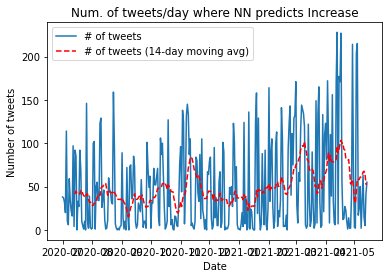

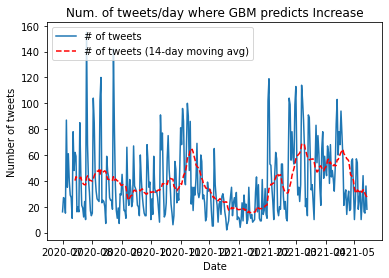

In [187]:
tweet_move_nn = TweetMovementPerDay(tweet_train_test, 'nn_pred', ['Increased'], plot_title='Num. of tweets/day where NN predicts Increase')
tweet_move_gbm = TweetMovementPerDay(tweet_train_test, 'gbm_pred', ['Increased'], plot_title='Num. of tweets/day where GBM predicts Increase')

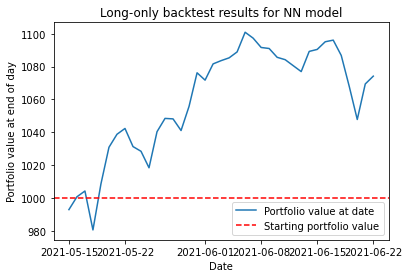

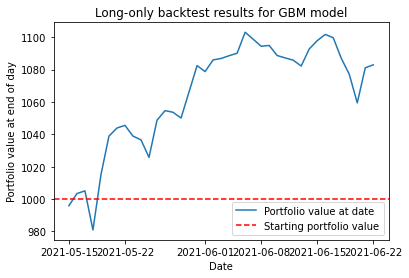

In [188]:
# Based on the above charts, both the NN and GBM models predict about 50 tweets per day to observe a stock price increase 1 day later. 
# Therefore, we will set the maximum number of tweets per day to 50. 
# We set the initial amount of funds to $1000 just for illustrative purposes. In any case, it is the % return that matters.
backtest_nn  = Backtest(tweet_holdout,  'nn_pred', 'NEC_ch1d', strategy = 'long_only', trades_per_day=50, init_funds=1000, plot_title = 'Long-only backtest results for NN model')
backtest_gbm = Backtest(tweet_holdout, 'gbm_pred', 'NEC_ch1d', strategy = 'long_only', trades_per_day=50, init_funds=1000, plot_title = 'Long-only backtest results for GBM model')

In [189]:
BacktestMetrics(backtest_nn)

,Cumulative Return,Cumulative Return (annualised),Average Return,Win Rate,Annualised Volatility
Model,0.0742,0.588026,0.0019,0.538462,0.178512


In [190]:
BacktestMetrics(backtest_gbm)

,Cumulative Return,Cumulative Return (annualised),Average Return,Win Rate,Annualised Volatility
Model,0.082923,0.673222,0.002105,0.538462,0.175395


#### **Backtesting a short-only trading strategy**
We repeat the analysis from the previous section, but instead using a short-only strategy (i.e. we only trade when the model predicts a Decrease). The features of the strategy are otherwise identical.

Accounting for the uptrend in the number of tweets posted towards the end of the training period, we select a value of N = 100 for this strategy, meaning that the weight of each investment in the portfolio is 1%. 

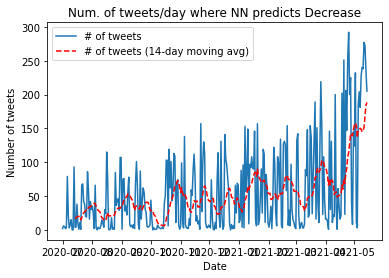

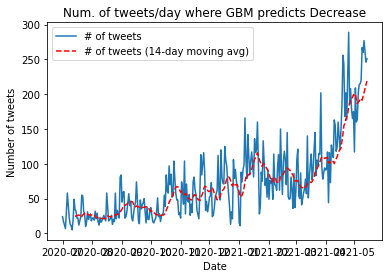

In [191]:
tweet_move_nn = TweetMovementPerDay(tweet_train_test, 'nn_pred', ['Decreased'], plot_title='Num. of tweets/day where NN predicts Decrease')
tweet_move_gbm = TweetMovementPerDay(tweet_train_test, 'gbm_pred', ['Decreased'], plot_title='Num. of tweets/day where GBM predicts Decrease')

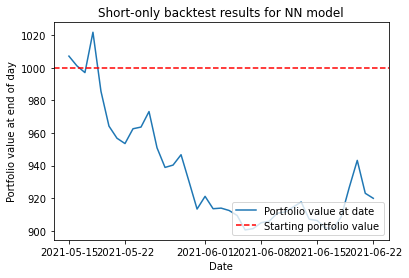

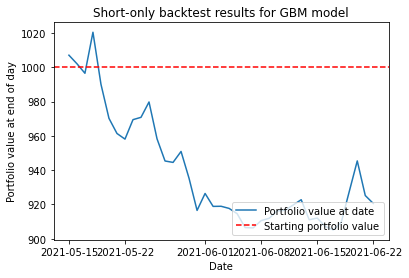

In [192]:
# Based on the above charts, both the NN and GBM models predict about 100 tweets per day to observe a stock price decrease 1 day later, particularly towards the end of the training period. 
# Therefore, we will set the maximum number of tweets per day to 100. 
backtest_nn  = Backtest(tweet_holdout,  'nn_pred', 'NEC_ch1d', strategy = 'short_only', trades_per_day=100, init_funds=1000, plot_title = 'Short-only backtest results for NN model')
backtest_gbm = Backtest(tweet_holdout, 'gbm_pred', 'NEC_ch1d', strategy = 'short_only', trades_per_day=100, init_funds=1000, plot_title = 'Short-only backtest results for GBM model')

In [193]:
BacktestMetrics(backtest_nn)

,Cumulative Return,Cumulative Return (annualised),Average Return,Win Rate,Annualised Volatility
Model,-0.080048,-0.416733,-0.002065,0.487179,0.190487


In [194]:
BacktestMetrics(backtest_gbm)

,Cumulative Return,Cumulative Return (annualised),Average Return,Win Rate,Annualised Volatility
Model,-0.079403,-0.414085,-0.002051,0.461538,0.185278


#### **Backtesting a long-short trading strategy**
We repeat the analysis from the previous section, but instead using a long-short strategy (i.e. we only purchase/go long when the model predicts a share price increase, and short sell when the model predicts a decrease). The features of the strategy are otherwise identical.

Accounting for the uptrend in the number of tweets posted towards the end of the training period, we select a value of N = 200 for this strategy, meaning that the weight of each investment in the portfolio is 0.5%. 

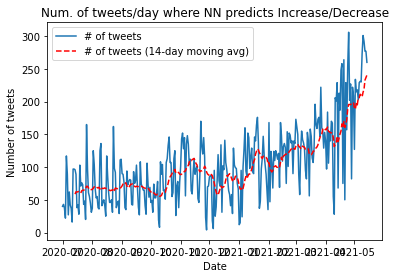

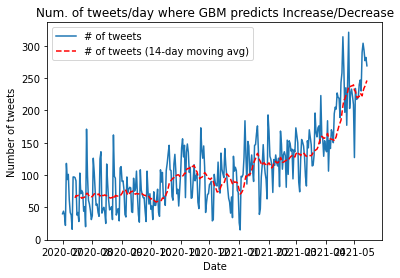

In [195]:
tweet_move_nn = TweetMovementPerDay(tweet_train_test, 'nn_pred', ['Increased', 'Decreased'], plot_title='Num. of tweets/day where NN predicts Increase/Decrease')
tweet_move_gbm = TweetMovementPerDay(tweet_train_test, 'gbm_pred', ['Increased', 'Decreased'], plot_title='Num. of tweets/day where GBM predicts Increase/Decrease')

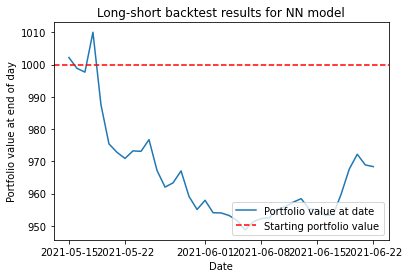

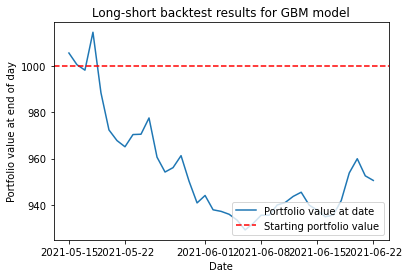

In [196]:
# Based on the above charts, both the NN and GBM models predict about 200 tweets per day to observe a stock price increase or decrease 1 day later, particularly towards the end of the training period. 
backtest_nn  = Backtest(tweet_holdout,  'nn_pred', 'NEC_ch1d', strategy = 'long_short', trades_per_day=200, init_funds=1000, plot_title = 'Long-short backtest results for NN model')
backtest_gbm = Backtest(tweet_holdout, 'gbm_pred', 'NEC_ch1d', strategy = 'long_short', trades_per_day=200, init_funds=1000, plot_title = 'Long-short backtest results for GBM model')

In [197]:
BacktestMetrics(backtest_nn)

,Cumulative Return,Cumulative Return (annualised),Average Return,Win Rate,Annualised Volatility
Model,-0.031648,-0.187629,-0.000808,0.461538,0.090464


In [198]:
BacktestMetrics(backtest_gbm)

,Cumulative Return,Cumulative Return (annualised),Average Return,Win Rate,Annualised Volatility
Model,-0.049441,-0.279373,-0.001268,0.461538,0.124883


#### **Commentary on backtesting metrics**

##### **Success measure 4: Trading win rate**

The trading win rate metric tracks the percentage of trades that were calculated to be profitable on the out-of-time holdout set. We calculate the trading win rate for all three strategies - the long-only, short-only and long-short strategies, each for the neural network and GBM models. 

**Justification for using this measure:** trading win rate is a metric frequently tracked by fund managers because it is an easy-to-communicate way of showing how often the fund's trades have been profitable. However, it is worth acknowledging its limitations - the primary one being that it doesn't account for the size of share price movements, so a win rate above 50% could still generate losses overall if the size of downwards movements are larger than the upwards ones on average. 

The best win rates were observed on the long-only strategy, with a win rate of 54% for the Neural Network model and 51% for the GBM model. The observed win rates for the short and long-short strategies ranged between 43% and 47%. 

Overall, this metric suggests that the models yield better performance when predicting the Increase class, though this may simply be because the out-of-time holdout set has a larger proportion of share price Increases. However, it suggests that a profitable long-only trading strategy may be possible using these models. 

##### **Success measure 5: Cumulative % return (including annualised figures)**
The cumulative % return is calculated by measuring the return made on each trade (in the out-of-time holdout set) and cumulating it. That means that the cumulative % return accommodates for the reinvestment of profits made on previous trades. The annualised % return is calculated by assuming that the % return generated during the backtest is obtained consistently throughout the year. 

**Justification for using this measure:** this is a measure of the actual performance of the model when used for trading. In other words, if you were to actually trade using the model and following the strategies tested above (long-only, short-only and long-short), the cumulative % return tells you how much profit or loss you would make. This is, of course, perhaps the single most important measure of success for a fund manager. The annualised returns are also of interest as investors often select between various active funds based on their annualised return; however these figures can be unreliable if backtested only on a short timeframe of data. 

Under the long-only strategy, the neural network model yielded a cumulative % return of 7.9% over the ~40 day-long backtest period. This annualises to 63% return. The GBM, on the other hand, yielded 8.4% cumulative return, annualising to 68%. Both the short-only and long-short strategies, on the other hand, yielded losses. 

Overall, this metric suggests that good profits can be made trading using the long-only strategy, for both the Neural Network and GBM model. 8% return in a single month is quite large given that stock markets typically only return about 7% over a year. However, it is worth pointing out that this may just be due to the backtest time period used, where a large number of Increases were observed. The annualised figures are likely unreliable since the backtest only covered 40 days. Again, more testing across different time periods is necessary to see how profitable each model and trading strategy is. 

**Note that calculations for the benchmarks (ASX200 and NEC) are not included in this script, because we can't submit other CSV files (containing the historic prices of the ASX200 and NEC) as part of the assignment. We simply discuss the results here.** 

##### **Success measure 6: Outperformance over the benchmarks**
Outperformance over the benchmarks is calculated as the percentage return generated by the model (for each trading strategy) over the backtesting period, minus the percentage return generated by the benchmarks. In this case, the benchmarks will be:

Holding the ASX200 index, as this is the standard index used to capture the performance of the top companies in the ASX. Nine Entertainment is a part of this index.
Holding Nine Entertainment over the backtest period, as this is the profit that can be generated without involving any complex trading strategies. 

**Justification for using this measure:** a key metric that investment fund managers frequently track is Alpha, also referred to as excess return. The only reason for active funds to exist is if they can generate Alpha; otherwise, simply tracking the market (e.g. by using an Exchange Traded index fund) would be sufficient. Therefore, for this fund to be able to justify using this strategy and charging fees to clients, it must be able to prove to its clients that it can outperform the benchmark. Proving that we can outperform the benchmark will help convince investors to place their money with this fund.

We find that the Neural Network long-only strategy outperforms the market by 3.5%, and outperforms simply holding Nine Entertainment by 0.4%. For the GBM long-only strategy, this is 3.7% and 0.6% respectively. However, the short-only and long-short strategies underperformed both benchmarks. This once again reinforces the idea that this model is best suited to a long-only strategy.

Overall, this metric shows that the model performs very well in meeting the objectives of the analysis. The long-only strategies outperformed the market. While Nine Entertainment already significantly already outperformed the market, the model was able to extract additional performance through its active purchasing and selling of the shares. This is strong justification that the Neural Network and GBM models could boost the investment fund's performance. 

##### **Success measure 7: Volatility of returns**

The annualised volatility of returns is calculated by taking the standard deviation of daily returns over the backtest period, and annualising it by multiplying this by the square root of 252 (the total number of trading days in one year). 

**Justification for using this measure**: The volatility of returns is of great interest to many investors and fund managers. An investment fund that promises a high expected return may still be unpopular among potential clients if it has to take excessive amounts of risk (and thus be exposed to a very high volatility of returns) in doing so. Therefore, measuring the volatility of returns generated by the Neural Network and GBM models is very important. Lower volatility metrics are preferable to convince clients that the investment fund's strategies are sound. 

Over the backtest period, we calculate the annualised volatility of returns for the ASX200 to be 12%, and 26% for Nine Entertainment. This is expected because the volatility of a single company will naturally be higher than that of an index, which "averages" across 200 companies. Further, Nine is a relatively small company compared to most ASX200 companies, and thus would be expected to have high volatility. The long and short strategies both yielded annualised volatility metrics around 18% (for both the Neural Network and GBM models), though this was much lower for the Long-Short strategy. 

Overall, this metric shows that the model generates superior performance relative to the benchmark (holding NEC). Comparing against the ASX200's volatility is not appropriate for the aforementioned reasons. We have shown that using the long-only strategy, both the Neural Network and GBM models are able to generate superior returns to just holding Nine Entertainment, with a lower volatility of returns. Therefore, by this metric, the predictions have been very successful in meeting the objectives of the analysis, since it appears to be able to boost the fund's performance. 

##### **Success measure 8: Time taken to score the model**
This metric refers to how long it takes for the model to make a prediction after receiving a tweet.

**Justification for using this measure:** Trading can be extremely time-sensitive. Profitable trading opportunities can often evaporate in seconds, having been arbitraged out by trading algorithms and high frequency traders. A complex model that takes an entire minute to score a single tweet may be deemed unfeasible for use, if the window for making a profitable trade is gone by the time the model has made its prediction. Therefore, in order to meet the objectives of the analysis (boost the investment fund's performance), implementing the model must actually be feasible. 

In the section on Re-fitting the model on the combined train-test data (Question 4(d)), we see that the Neural Network model takes less than 1 second to score on the holdout set (10,139 tweets), while the GBM model takes about 1 second. Therefore, scoring a single tweet will take a split second to perform. 

It is worth noting that the TF-IDF model has to score a tweet as well before the neural network or GBM can score it; however, running this also takes a split second on all 10,139 tweets of the holdout set, so the additional run-time caused is negligible. 

Therefore, by this measure, the neural network and GBM models perform very well as they can predict share price movements based on tweet contents in well under a second. This is critical to ensuring that the models can actually boost the fund's performance. 

#### **Final conclusions on model's ability to meet objectives**
Overall, both the final neural network and tree-based model perform well in meeting the objectives of this analysis. Both models are able to achieve decent classification accuracy and good precision on the Increase class, which provide confidence that the model is reasonably accurate. When employed in a long-only trading strategy, we can see that both models have achieved greater returns than their benchmarks. Ultimately, the goal of the analysis is to investigate if the investment fund's performance can be boosted by trading on tweets, and we conclude that the answer is: **Yes - the model is able to improve performance using tweets.** Out of the two models, we prefer the neural network model given that its predictions are slightly less biased towards predicting Decreases (which is necessary to ensure that the model generalises well to other out-of-time samples). 